In [1]:
import numpy as np
import matplotlib.pylab as plt
from gf45clo_sin_neff_ng_calculator import mode_data_calculator

import tidy3d as td
from tidy3d.constants import C_0

from tqdm import tqdm
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")
plt.style.use("plot_style.mplstyle")


# Single mode (wg width = 800 nm)

In [2]:
Lx, Ly, Lz = 10, 10, 10
dl = 0.01

min_steps_per_wvl = 30

wg_width = 0.8
wg_height = 0.3
wg_n = 1.968
wg_k = 0

wvl_um = 1.31
freq0 = C_0/wvl_um

wg_medium = td.Medium.from_nk(n=1.968, k=0, freq=freq0)

wg_sidewall_angle = np.pi/2.0 - 87.0/180.0*np.pi

num_freqs = 3

fwidth = 3200e9  # 3200 Ghz
freqs = np.linspace(freq0-fwidth/2.0, freq0+fwidth/2.0, num_freqs)

thickness_3sigma = 0.03
width_3sigma = 0.02
sidewall_angle_3sigma = 2/90*np.pi/2

num_samples = 1500

In [3]:
mode_solver, mode_data_df = mode_data_calculator(
    wg_width, wg_height, wg_sidewall_angle, wg_n, wg_k, freqs, freq0, Lx=Lx, Ly=Ly, Lz=Lz, dl=dl, min_steps_per_wvl=min_steps_per_wvl
    )


[22:11:04] WARNING: Use the remote mode solver with subpixel averaging for      
           better accuracy through 'tidy3d.plugins.mode.web.run(...)'.          

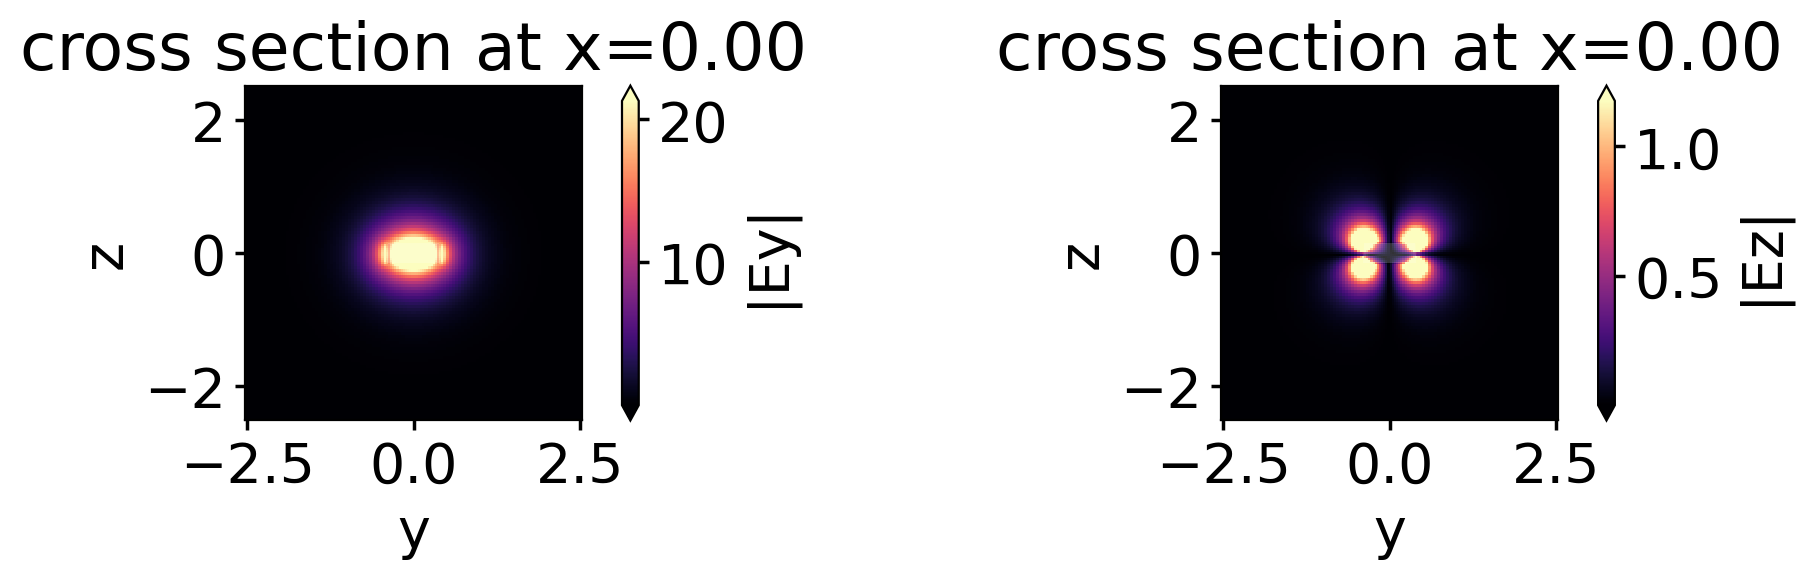

In [4]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
mode_solver.plot_field("Ey", "abs", mode_index=0, f=freq0, ax=ax1)
mode_solver.plot_field("Ez", "abs", mode_index=0, f=freq0, ax=ax2)
plt.show()


In [5]:
## Calculating the group index

fundamental_mode_data_df = mode_data_df[mode_data_df["wavelength"] == 1.31]
ng_freq0 = fundamental_mode_data_df["group index"].values[0]
ng_dfreq = (mode_data_df["group index"].values[-1] - mode_data_df["group index"].values[0])/2
neff_freq0 = fundamental_mode_data_df["n eff"].values[0]
neff_dfreq = (mode_data_df["n eff"].values[-1] - mode_data_df["n eff"].values[0])/2
print(ng_freq0, ng_dfreq, neff_freq0, neff_dfreq)

1.9306324 0.0036483407020568848 1.587703 0.0023966431617736816


In [6]:
wg_height_spread, wg_width_spread, wg_sidewall_angle_spread = [], [], []

for i in tqdm(range(num_samples),desc = "variation sweep"):
  wg_height_spread.append(
    (1+np.random.normal(0, thickness_3sigma/3/wg_height)) * wg_height
  )
  wg_width_spread.append(
    (1+np.random.normal(0, width_3sigma/3/wg_width)) * wg_width
  )
  wg_sidewall_angle_spread.append(
    (1+np.random.normal(0,sidewall_angle_3sigma/3/wg_sidewall_angle)) * wg_sidewall_angle
  )

permutation_choice_width, permutation_choice_height, permutation_choice_sidewall_angle = np.random.permutation(num_samples), np.random.permutation(num_samples), np.random.permutation(num_samples)

variation sweep: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 641919.80it/s]


In [7]:
print(np.median(wg_sidewall_angle_spread), 3 *np.std(wg_sidewall_angle_spread), wg_sidewall_angle)
print(np.median(wg_height_spread), 3*np.std(wg_height_spread), wg_height)
print(np.median(wg_width_spread), 3*np.std(wg_width_spread),wg_width)


0.05254205923940587 0.03581234205295047 0.05235987755982996
0.30061420198263233 0.0292943178893958 0.3
0.8001104805751343 0.0197721288152911 0.8


## Width variation only

In [8]:
wg_width_choice, wg_height_choice, wg_sidewall_angle_choice = [], [], []
ng_freq0_spread = []
ng_dfreq_spread = []
neff_freq0_spread = []
neff_dfreq_spread = []


for i in tqdm(range(num_samples), desc="mode_simulations"):
  rand_wg_width_choice = wg_width_spread[permutation_choice_width[i]]
  # rand_wg_height_choice = wg_height_spread[permutation_choice_height[i]]
  # rand_wg_sidewall_angle_choice = wg_sidewall_angle_spread[permutation_choice_sidewall_angle[i]]
  rand_wg_height_choice = wg_height
  rand_wg_sidewall_angle_choice = wg_sidewall_angle

  wg_width_choice.append(rand_wg_width_choice)
  wg_height_choice.append(rand_wg_height_choice)
  wg_sidewall_angle_choice.append(rand_wg_sidewall_angle_choice)

  mode_solver, mode_data_df = mode_data_calculator(
      rand_wg_width_choice, 
      rand_wg_height_choice, 
      rand_wg_sidewall_angle_choice, 
      wg_n, wg_k, freqs, freq0, 
      Lx=Lx, Ly=Ly, Lz=Lz, dl=dl,
      min_steps_per_wvl=min_steps_per_wvl
  )

  fundamental_mode_data_df = mode_data_df[mode_data_df["wavelength"] == 1.31]
  ng_freq0 = fundamental_mode_data_df["group index"].values[0]
  ng_dfreq = (mode_data_df["group index"].values[-1] -
              mode_data_df["group index"].values[0])/2
  neff_freq0 = fundamental_mode_data_df["n eff"].values[0]
  neff_dfreq = (mode_data_df["n eff"].values[-1] -
                mode_data_df["n eff"].values[0])/2
  
  ng_freq0_spread.append(ng_freq0)
  ng_dfreq_spread.append(ng_dfreq)
  neff_freq0_spread.append(neff_freq0)
  neff_dfreq_spread.append(neff_dfreq)

rand_wg_width_dataset = pd.DataFrame(data=wg_width_choice)
rand_wg_width_dataset.columns = ['wg_width (nm)']
rand_wg_width_dataset['wg_height (nm)']=wg_height_choice
rand_wg_width_dataset['wg_sidewall_angle (rad)'] = wg_sidewall_angle_choice
rand_wg_width_dataset['rand_wg_width'] = True
rand_wg_width_dataset['rand_wg_height'] = False
rand_wg_width_dataset['rand_wg_sidewall_angle'] = False
rand_wg_width_dataset['neff_freq0'] = neff_freq0_spread
rand_wg_width_dataset['neff_dfreq'] = neff_dfreq_spread
rand_wg_width_dataset['ng_freq0'] = ng_freq0_spread
rand_wg_width_dataset['ng_dfreq'] = ng_dfreq_spread
rand_wg_width_dataset['freq0 (Hz)']=freq0
rand_wg_width_dataset['freq_lo (Hz)'] = freqs[0]
rand_wg_width_dataset['freq_hi (Hz)'] = freqs[-1]

gf45clo_pdk_sin_neff_ng_variability = rand_wg_width_dataset.copy(deep=True)

gf45clo_pdk_sin_neff_ng_variability.to_csv("gf45clo_pdk_sin_neff_ng_variability.csv")

mode_simulations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [1:15:44<00:00,  3.03s/it]


Text(0.5, 1.0, 'Median = 87.00 deg, 1-sigma = 0.00 deg')

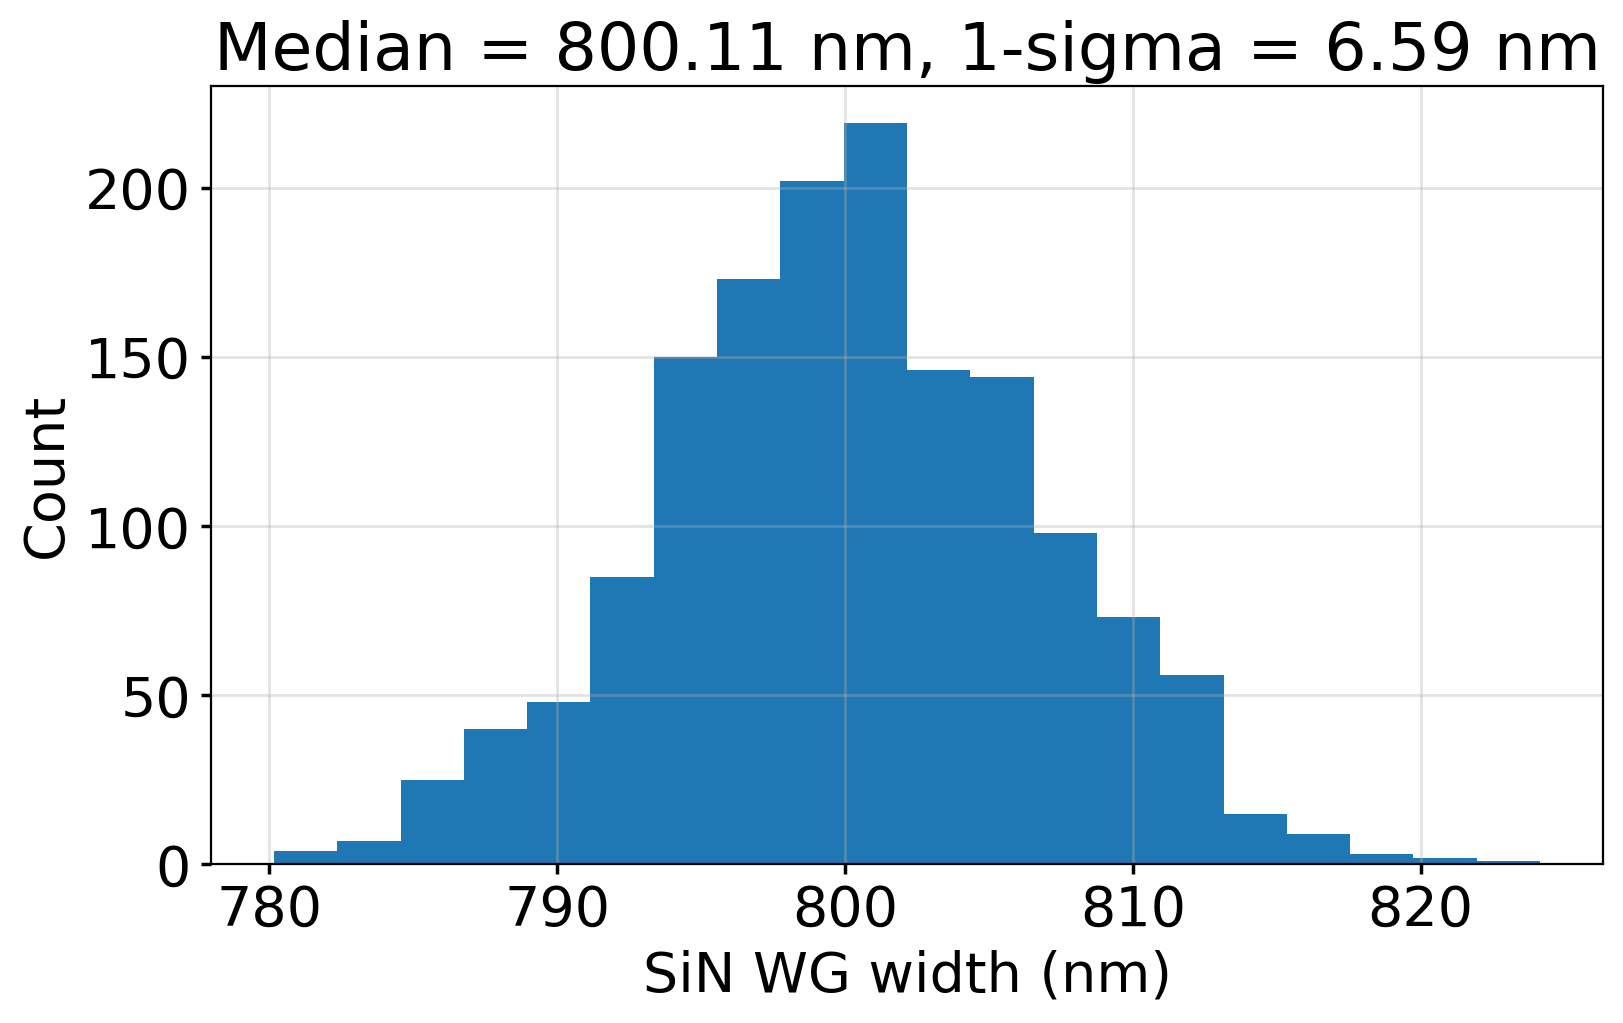

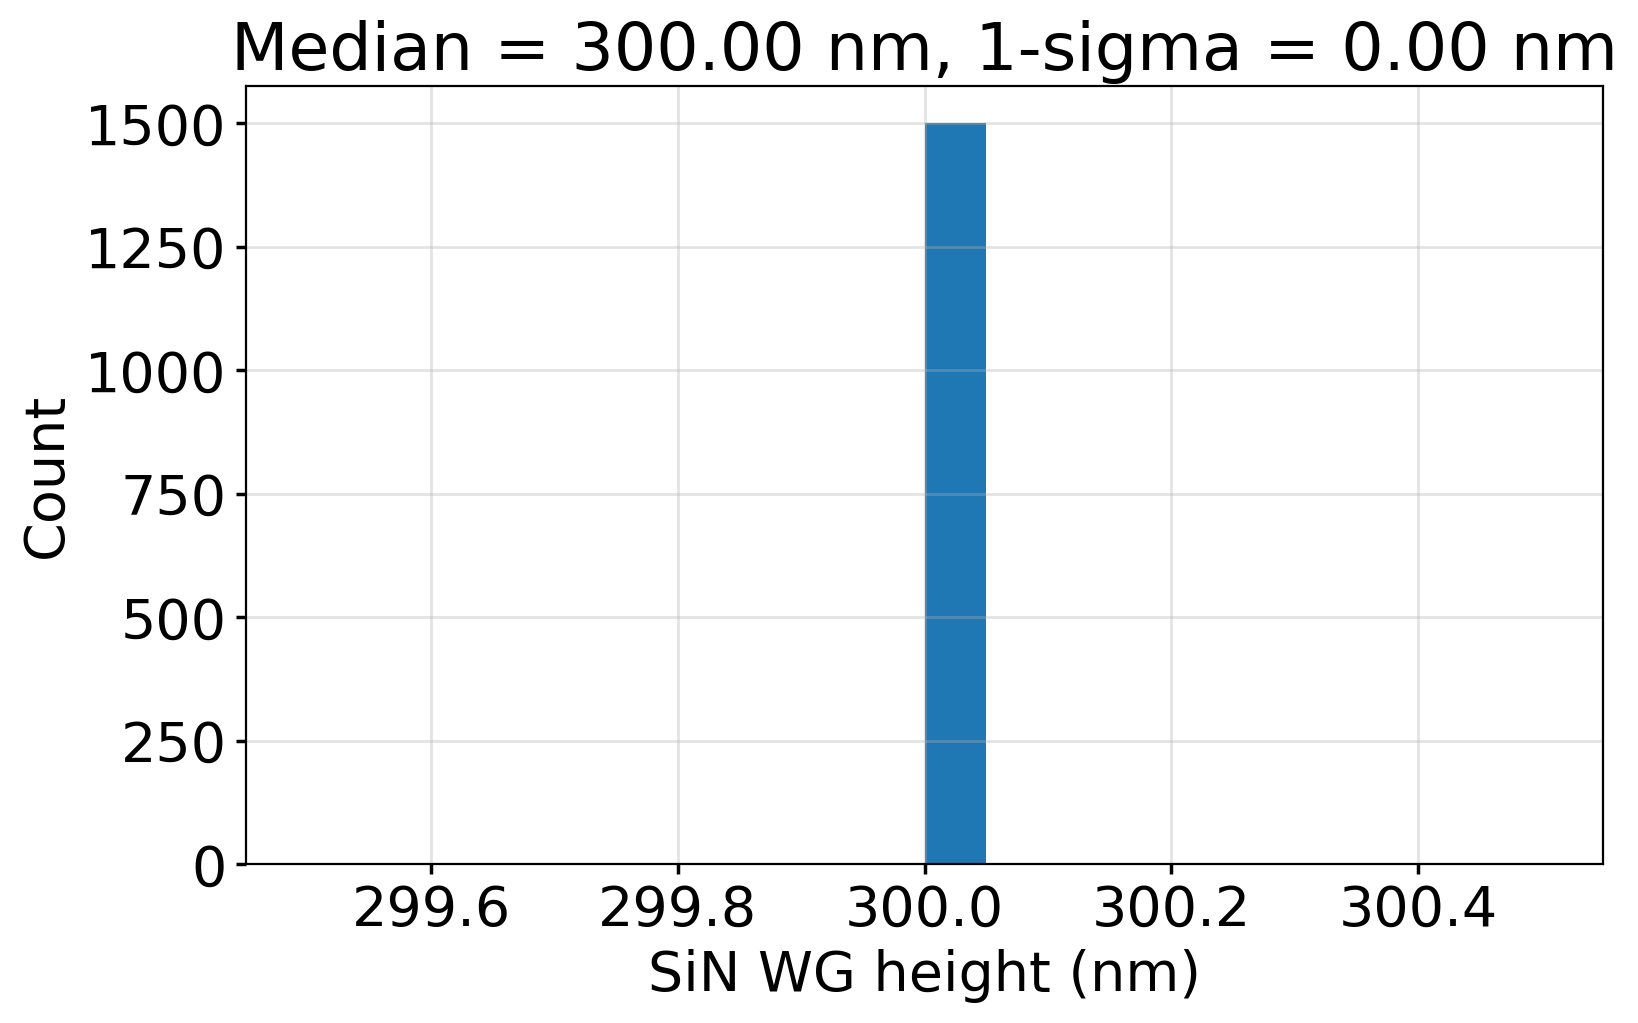

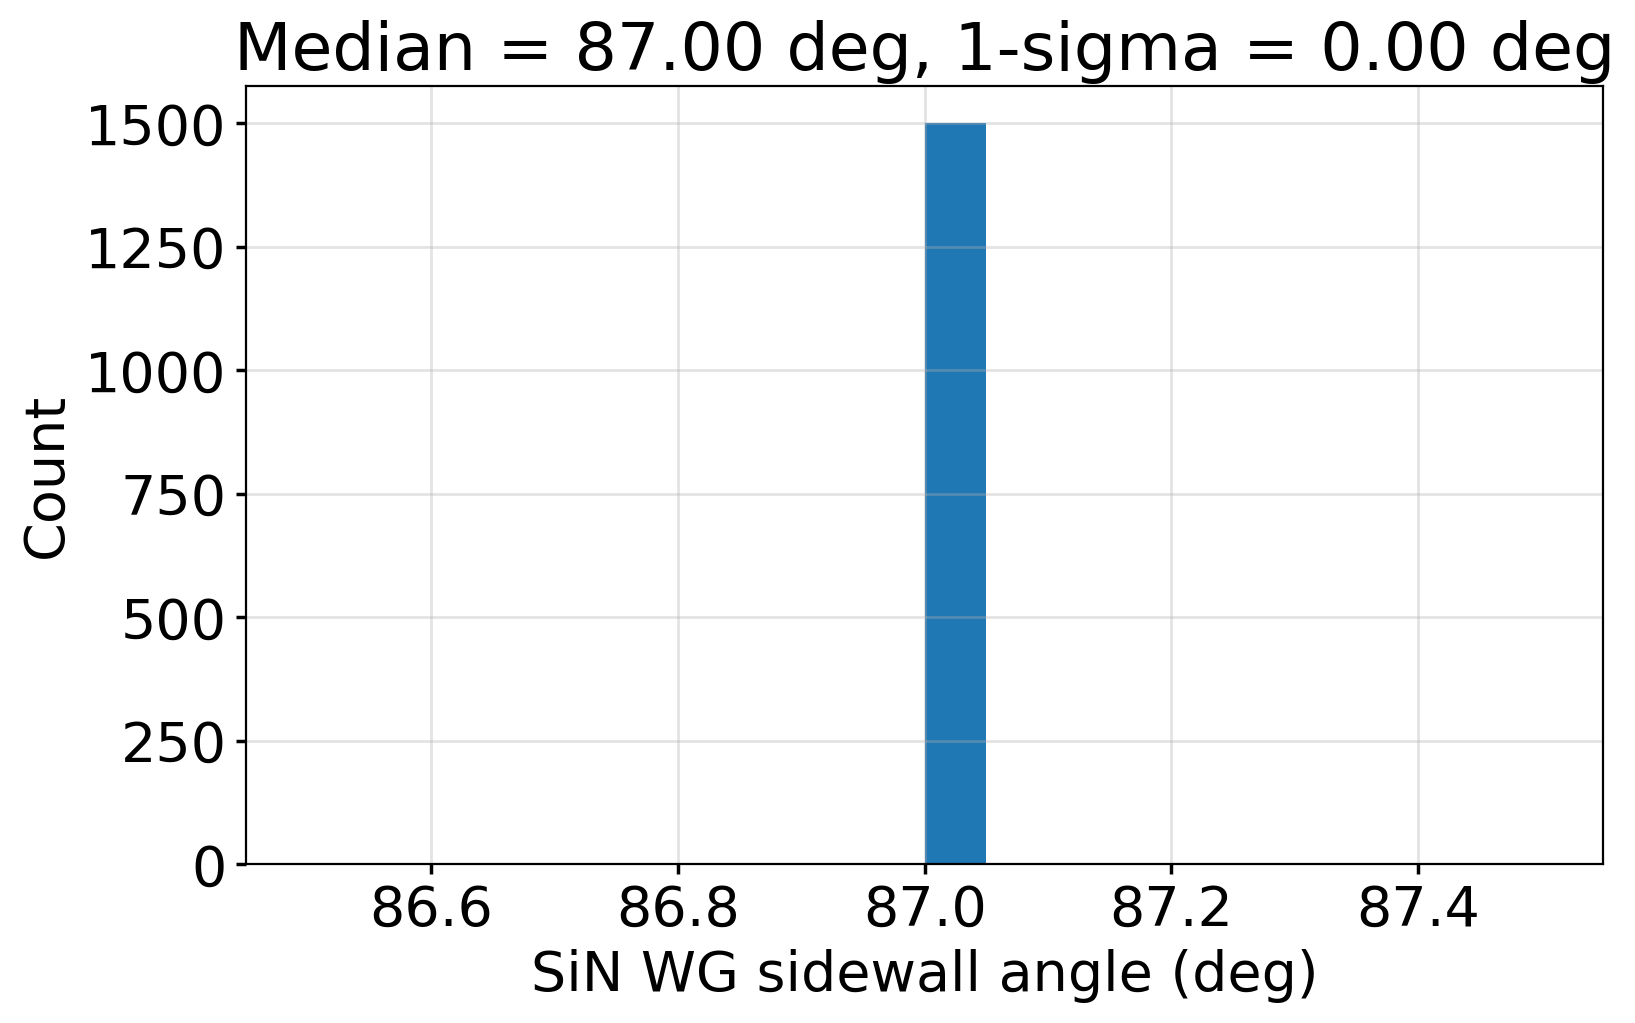

In [9]:
plt.figure()
plt.hist(rand_wg_width_dataset["wg_width (nm)"]*1000, bins=20)
plt.grid(True)
plt.xlabel('SiN WG width (nm)')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_width_dataset["wg_width (nm)"]*1000):0.2f} nm, 1-sigma = {np.std(rand_wg_width_dataset["wg_width (nm)"]*1000):0.2f} nm')

plt.figure()
plt.hist(rand_wg_width_dataset["wg_height (nm)"]*1000, bins=20)
plt.grid(True)
plt.xlabel('SiN WG height (nm)')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_width_dataset["wg_height (nm)"]*1000):0.2f} nm, 1-sigma = {np.std(rand_wg_width_dataset["wg_height (nm)"]*1000):0.2f} nm')

plt.figure()
plt.hist(
    90-rand_wg_width_dataset["wg_sidewall_angle (rad)"].values/np.pi*180, bins=20)
plt.grid(True)
plt.xlabel('SiN WG sidewall angle (deg)')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(90-rand_wg_width_dataset["wg_sidewall_angle (rad)"].values/np.pi*180):0.2f} deg, 1-sigma = {np.std(90-rand_wg_width_dataset["wg_sidewall_angle (rad)"].values/np.pi*180):0.2f} deg')


Text(0.5, 1.0, 'Median = 1.9305, 1-sigma = 0.0012')

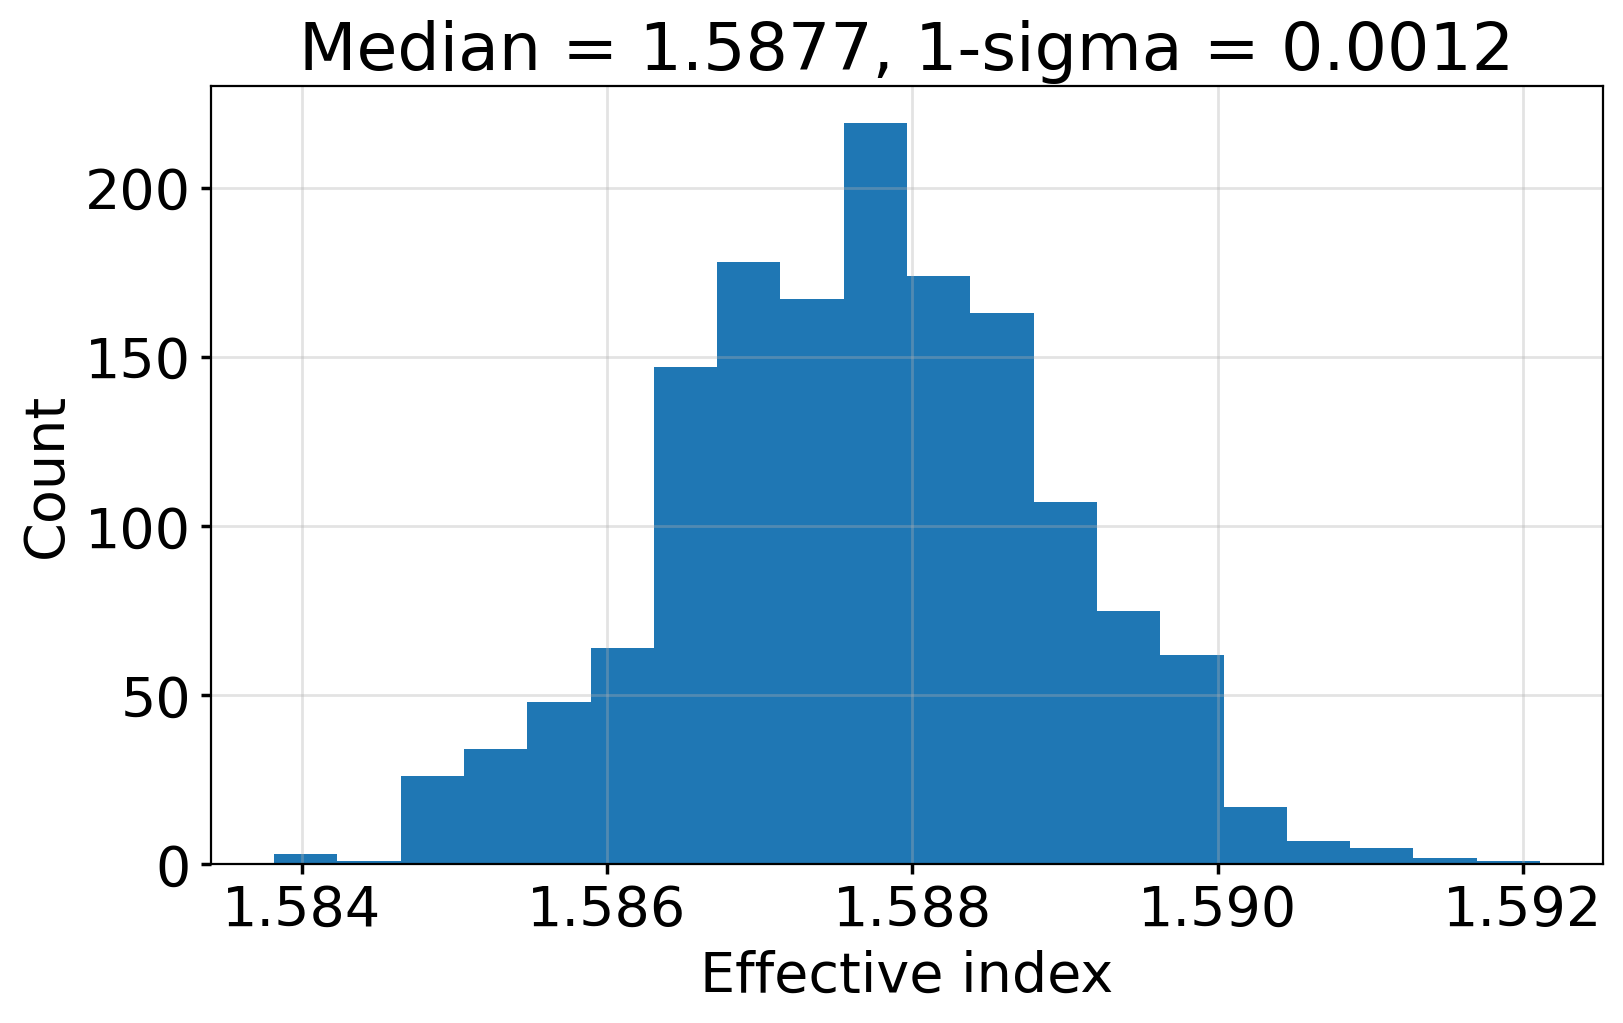

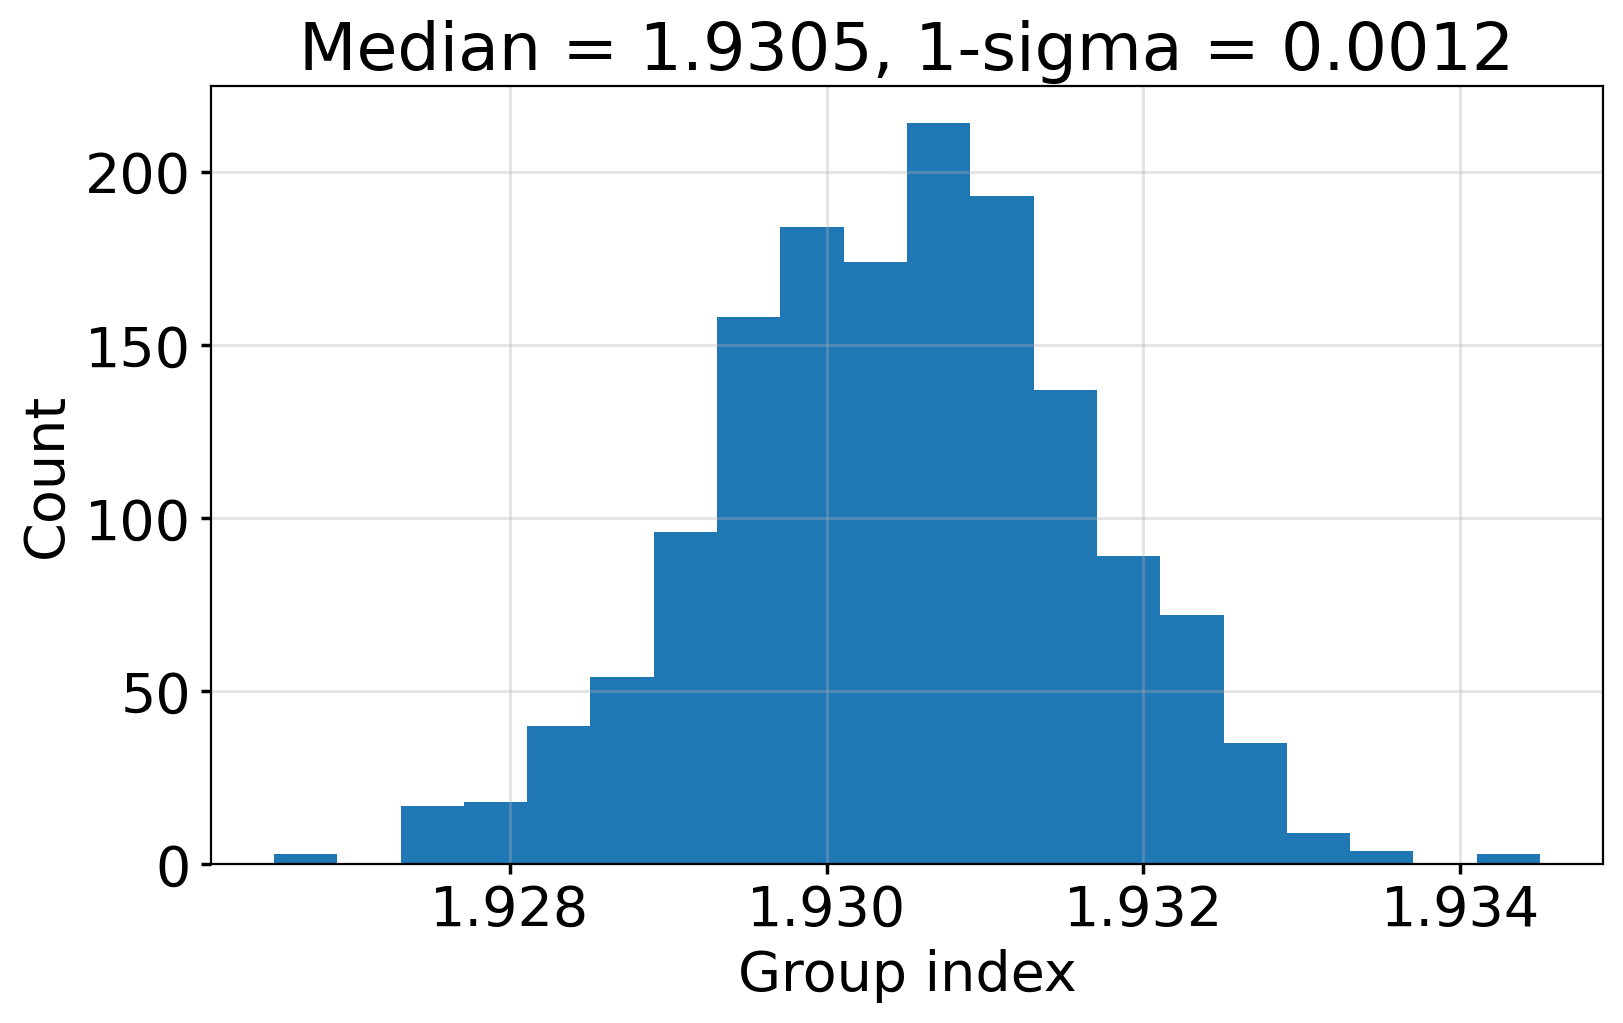

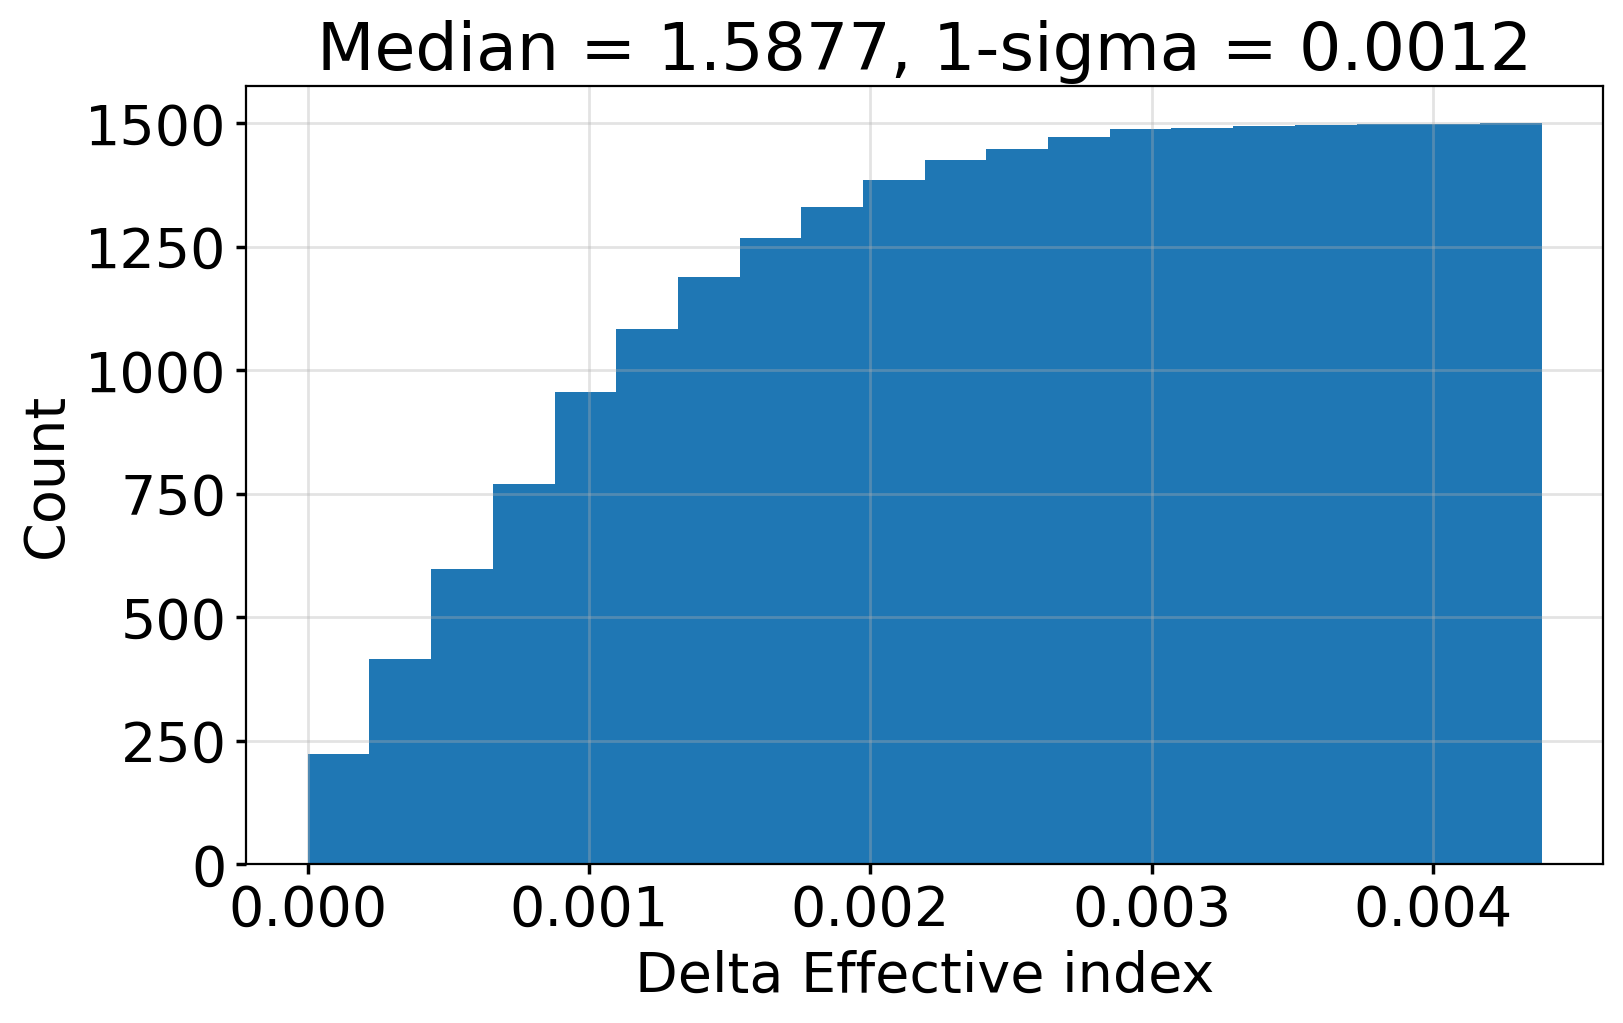

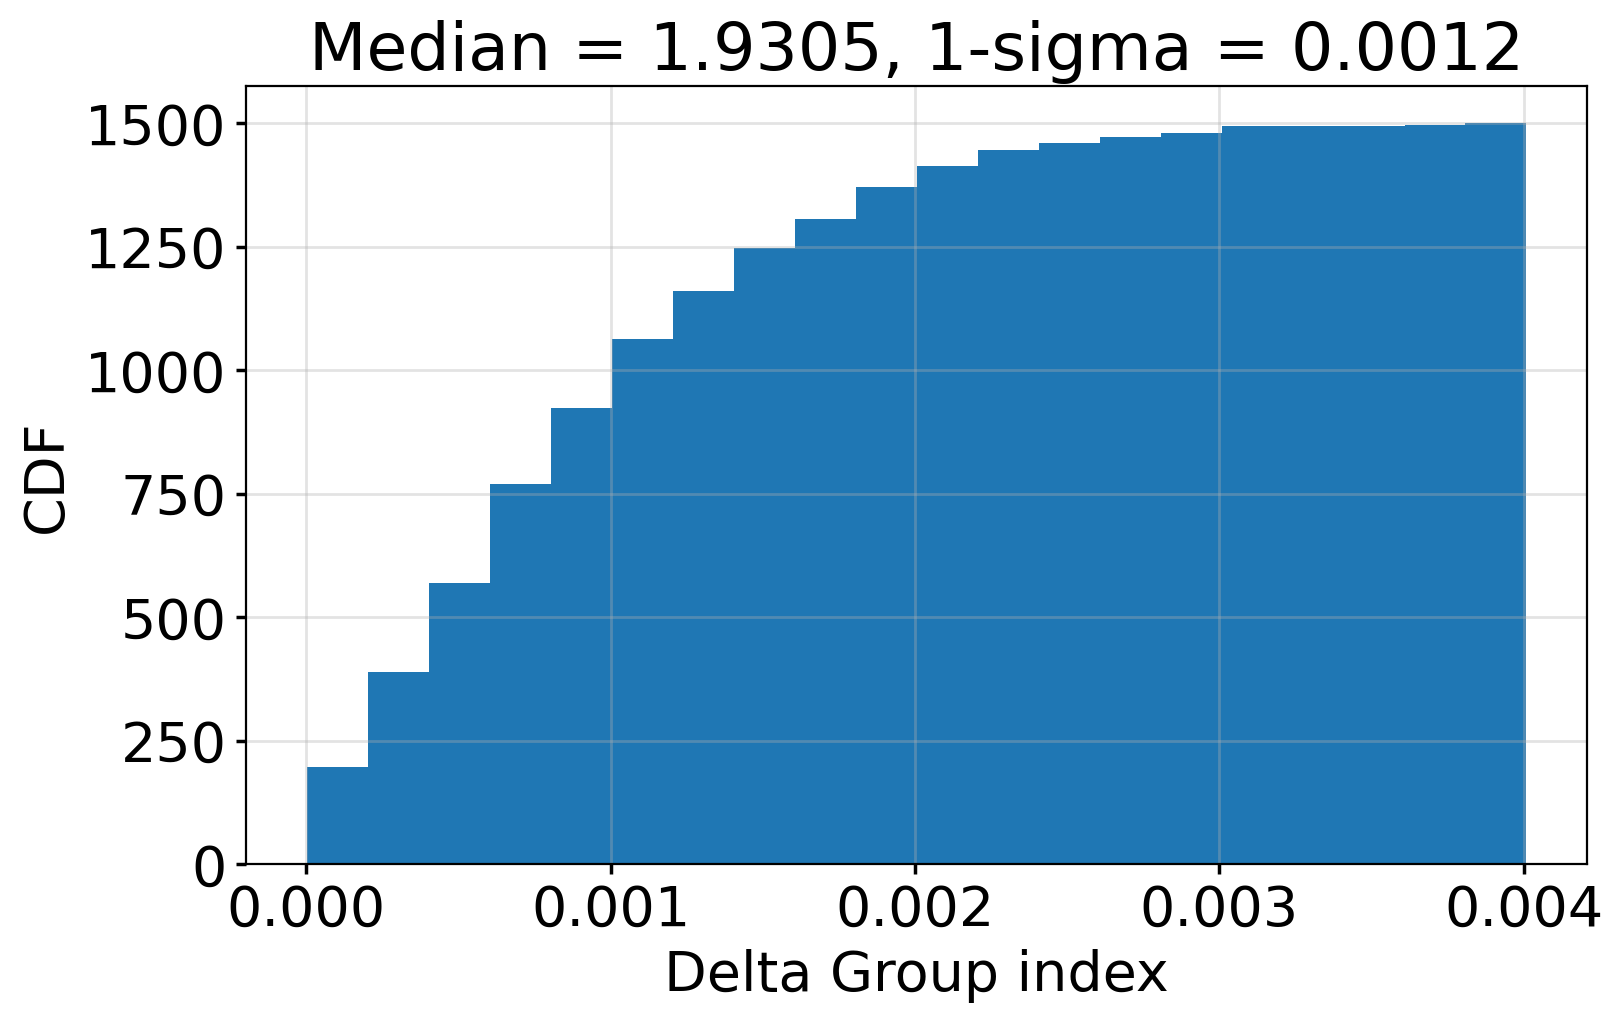

In [10]:
plt.figure()
plt.hist(rand_wg_width_dataset["neff_freq0"], bins=20)
plt.grid(True)
plt.xlabel('Effective index')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_width_dataset["neff_freq0"]):0.4f}, 1-sigma = {np.std(rand_wg_width_dataset["neff_freq0"]):0.4f}')

plt.figure()
plt.hist(rand_wg_width_dataset["ng_freq0"], bins=20)
plt.grid(True)
plt.xlabel('Group index')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_width_dataset["ng_freq0"]):0.4f}, 1-sigma = {np.std(rand_wg_width_dataset["ng_freq0"]):0.4f}')

plt.figure()
plt.hist(np.abs(rand_wg_width_dataset["neff_freq0"]-np.median(rand_wg_width_dataset["neff_freq0"])), bins=20, cumulative = True)
plt.grid(True)
plt.xlabel('Delta Effective index')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_width_dataset["neff_freq0"]):0.4f}, 1-sigma = {np.std(rand_wg_width_dataset["neff_freq0"]):0.4f}')

plt.figure()
plt.hist(np.abs(rand_wg_width_dataset["ng_freq0"]-np.median(rand_wg_width_dataset["ng_freq0"])), bins=20, cumulative = True)
plt.grid(True)
plt.xlabel('Delta Group index')
plt.ylabel('CDF')
plt.title(
    f'Median = {np.median(rand_wg_width_dataset["ng_freq0"]):0.4f}, 1-sigma = {np.std(rand_wg_width_dataset["ng_freq0"]):0.4f}')



## Sidewall angle variation only

In [11]:
wg_width_choice, wg_height_choice, wg_sidewall_angle_choice = [], [], []
ng_freq0_spread = []
ng_dfreq_spread = []
neff_freq0_spread = []
neff_dfreq_spread = []

for i in tqdm(range(num_samples), desc="mode_simulations"):
  # rand_wg_width_choice = wg_width_spread[permutation_choice_width[i]]
  rand_wg_width_choice = wg_width
  # rand_wg_height_choice = wg_height_spread[permutation_choice_height[i]]
  rand_wg_sidewall_angle_choice = wg_sidewall_angle_spread[permutation_choice_sidewall_angle[i]]
  rand_wg_height_choice = wg_height
  # rand_wg_sidewall_anle_choice = wg_sidewall_angle

  wg_width_choice.append(rand_wg_width_choice)
  wg_height_choice.append(rand_wg_height_choice)
  wg_sidewall_angle_choice.append(rand_wg_sidewall_angle_choice)

  mode_solver, mode_data_df = mode_data_calculator(
      rand_wg_width_choice, 
      rand_wg_height_choice, 
      rand_wg_sidewall_angle_choice, 
      wg_n, wg_k, freqs, freq0, 
      Lx=Lx, Ly=Ly, Lz=Lz, dl=dl,
      min_steps_per_wvl=min_steps_per_wvl
  )

  fundamental_mode_data_df = mode_data_df[mode_data_df["wavelength"] == 1.31]
  ng_freq0 = fundamental_mode_data_df["group index"].values[0]
  ng_dfreq = (mode_data_df["group index"].values[-1] -
              mode_data_df["group index"].values[0])/2
  neff_freq0 = fundamental_mode_data_df["n eff"].values[0]
  neff_dfreq = (mode_data_df["n eff"].values[-1] -
                mode_data_df["n eff"].values[0])/2
  
  ng_freq0_spread.append(ng_freq0)
  ng_dfreq_spread.append(ng_dfreq)
  neff_freq0_spread.append(neff_freq0)
  neff_dfreq_spread.append(neff_dfreq)

rand_wg_sidewall_angle_dataset = pd.DataFrame(data=wg_width_choice)
rand_wg_sidewall_angle_dataset.columns = ['wg_width (nm)']
rand_wg_sidewall_angle_dataset['wg_height (nm)']=wg_height_choice
rand_wg_sidewall_angle_dataset['wg_sidewall_angle (rad)'] = wg_sidewall_angle_choice
rand_wg_sidewall_angle_dataset['rand_wg_width'] = False
rand_wg_sidewall_angle_dataset['rand_wg_height'] = False
rand_wg_sidewall_angle_dataset['rand_wg_sidewall_angle'] = True
rand_wg_sidewall_angle_dataset['neff_freq0'] = neff_freq0_spread
rand_wg_sidewall_angle_dataset['neff_dfreq'] = neff_dfreq_spread
rand_wg_sidewall_angle_dataset['ng_freq0'] = ng_freq0_spread
rand_wg_sidewall_angle_dataset['ng_dfreq'] = ng_dfreq_spread
rand_wg_sidewall_angle_dataset['freq0 (Hz)']=freq0
rand_wg_sidewall_angle_dataset['freq_lo (Hz)'] = freqs[0]
rand_wg_sidewall_angle_dataset['freq_hi (Hz)'] = freqs[-1]


gf45clo_pdk_sin_neff_ng_variability = pd.concat([rand_wg_width_dataset, rand_wg_sidewall_angle_dataset])
gf45clo_pdk_sin_neff_ng_variability.to_csv("gf45clo_pdk_sin_neff_ng_variability.csv")

mode_simulations: 100%|███████████████████████████████████████████████████████████████████████████| 1500/1500 [1:14:32<00:00,  2.98s/it]


Text(0.5, 1.0, 'Median = 86.99 deg, 1-sigma = 0.68 deg')

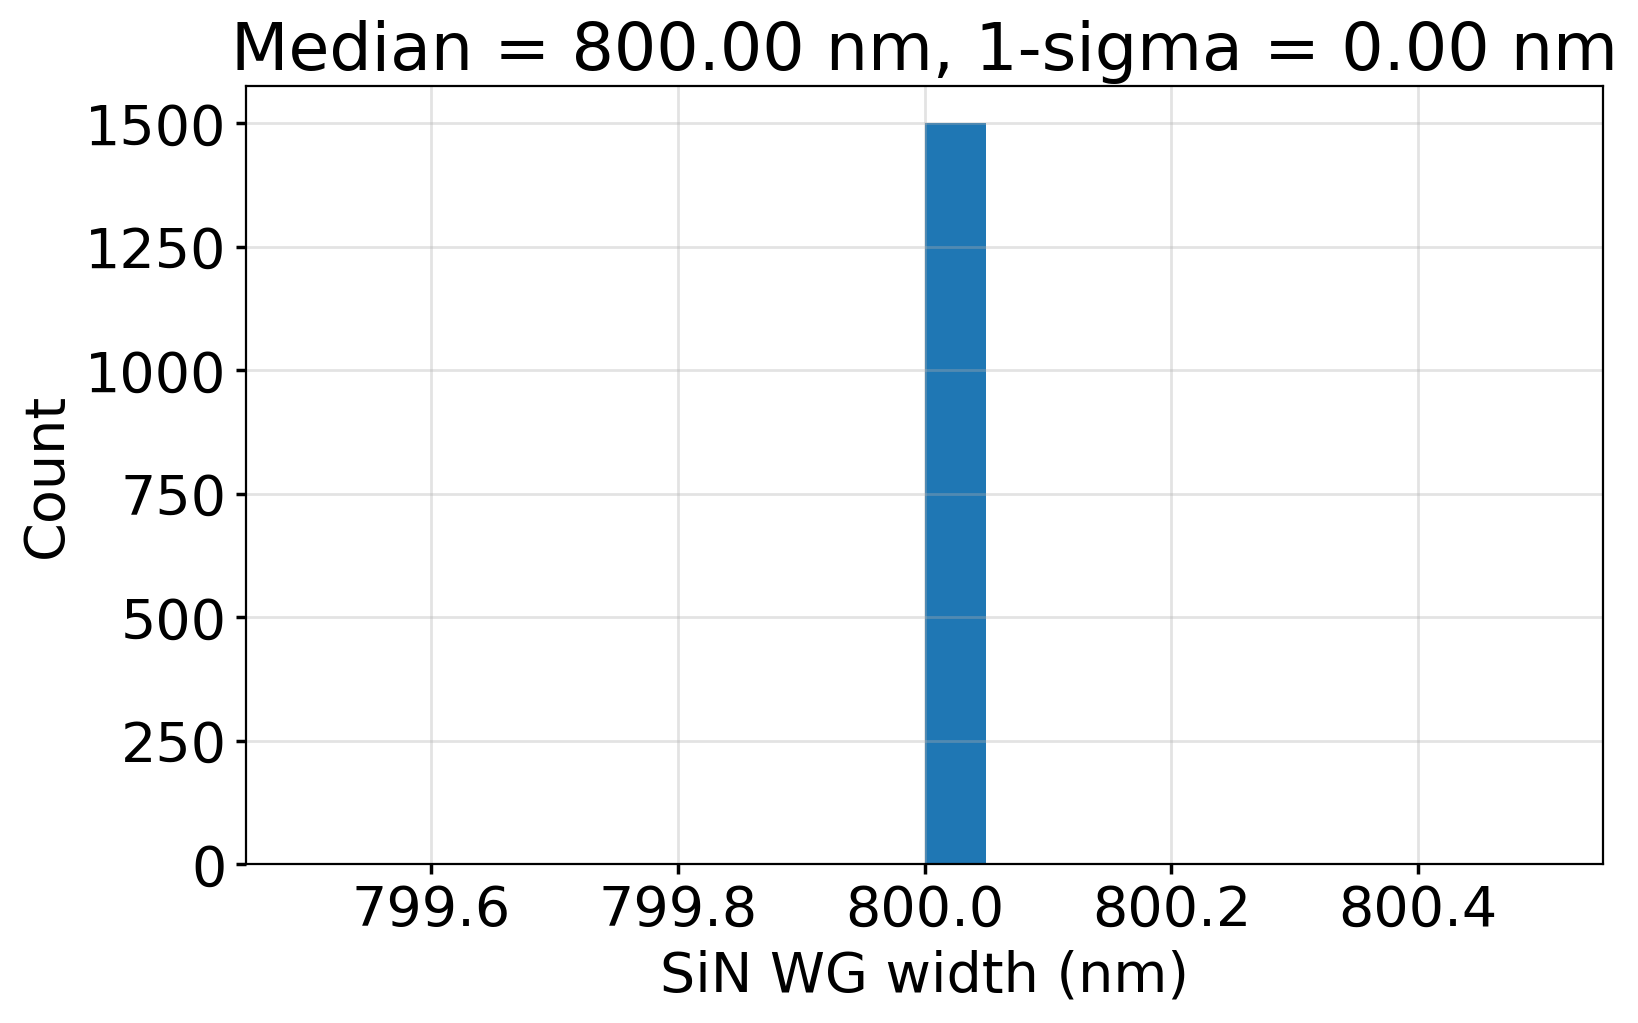

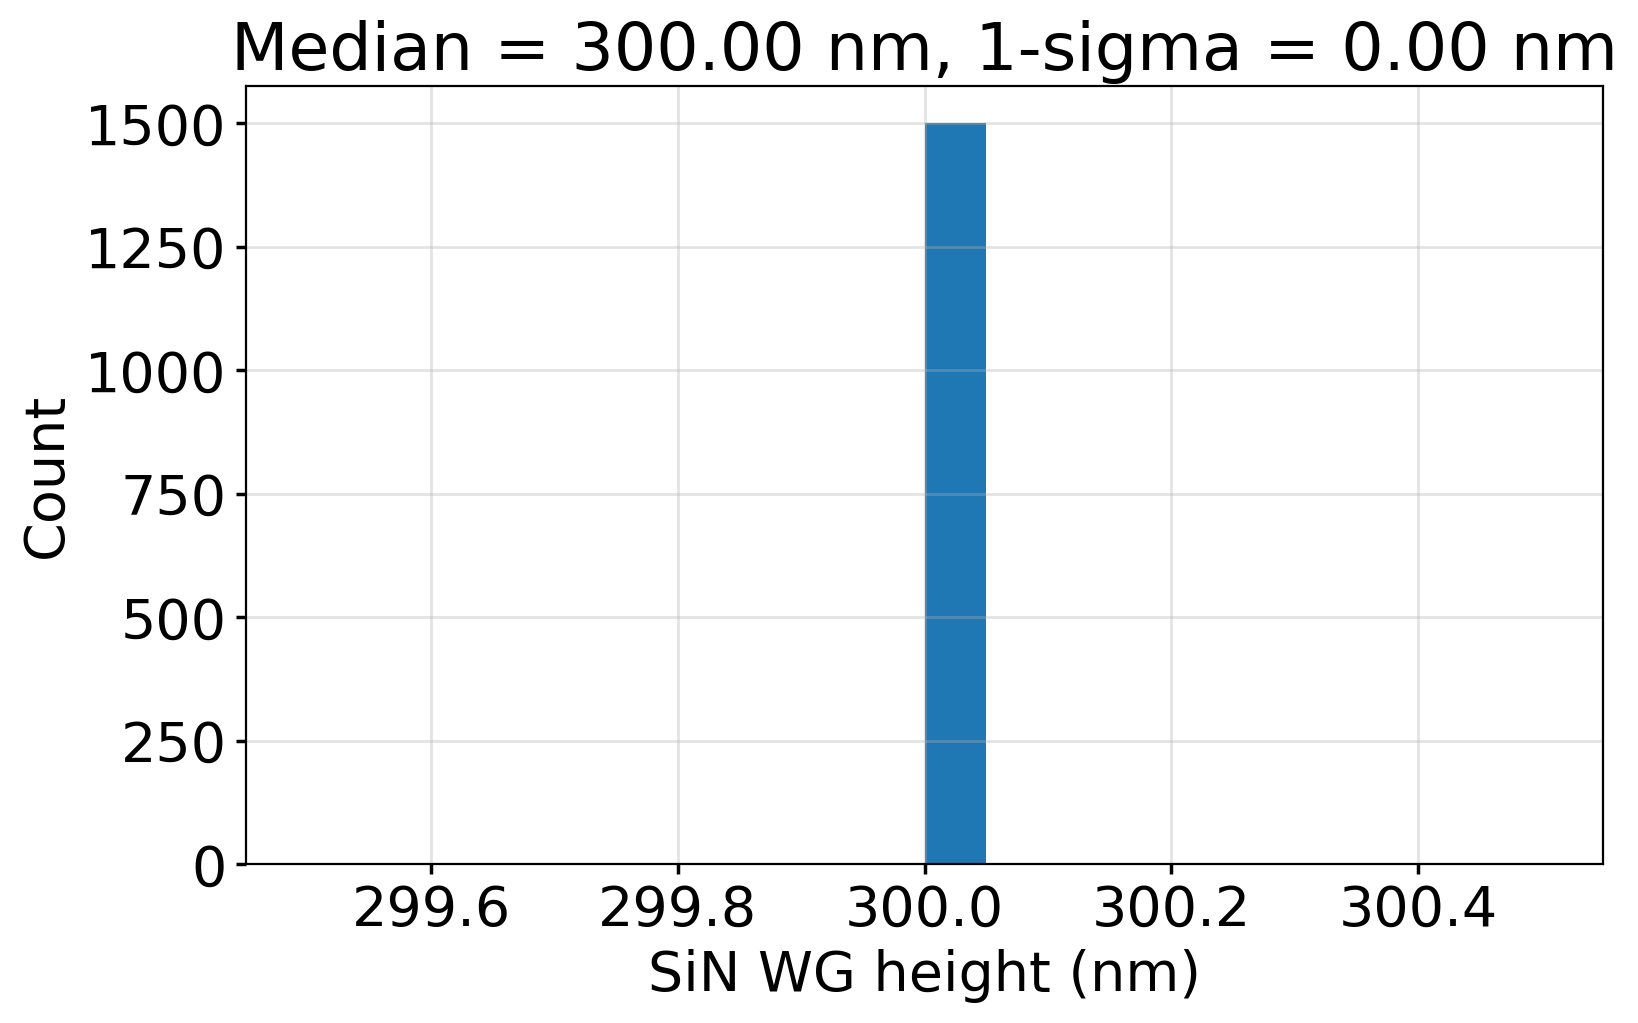

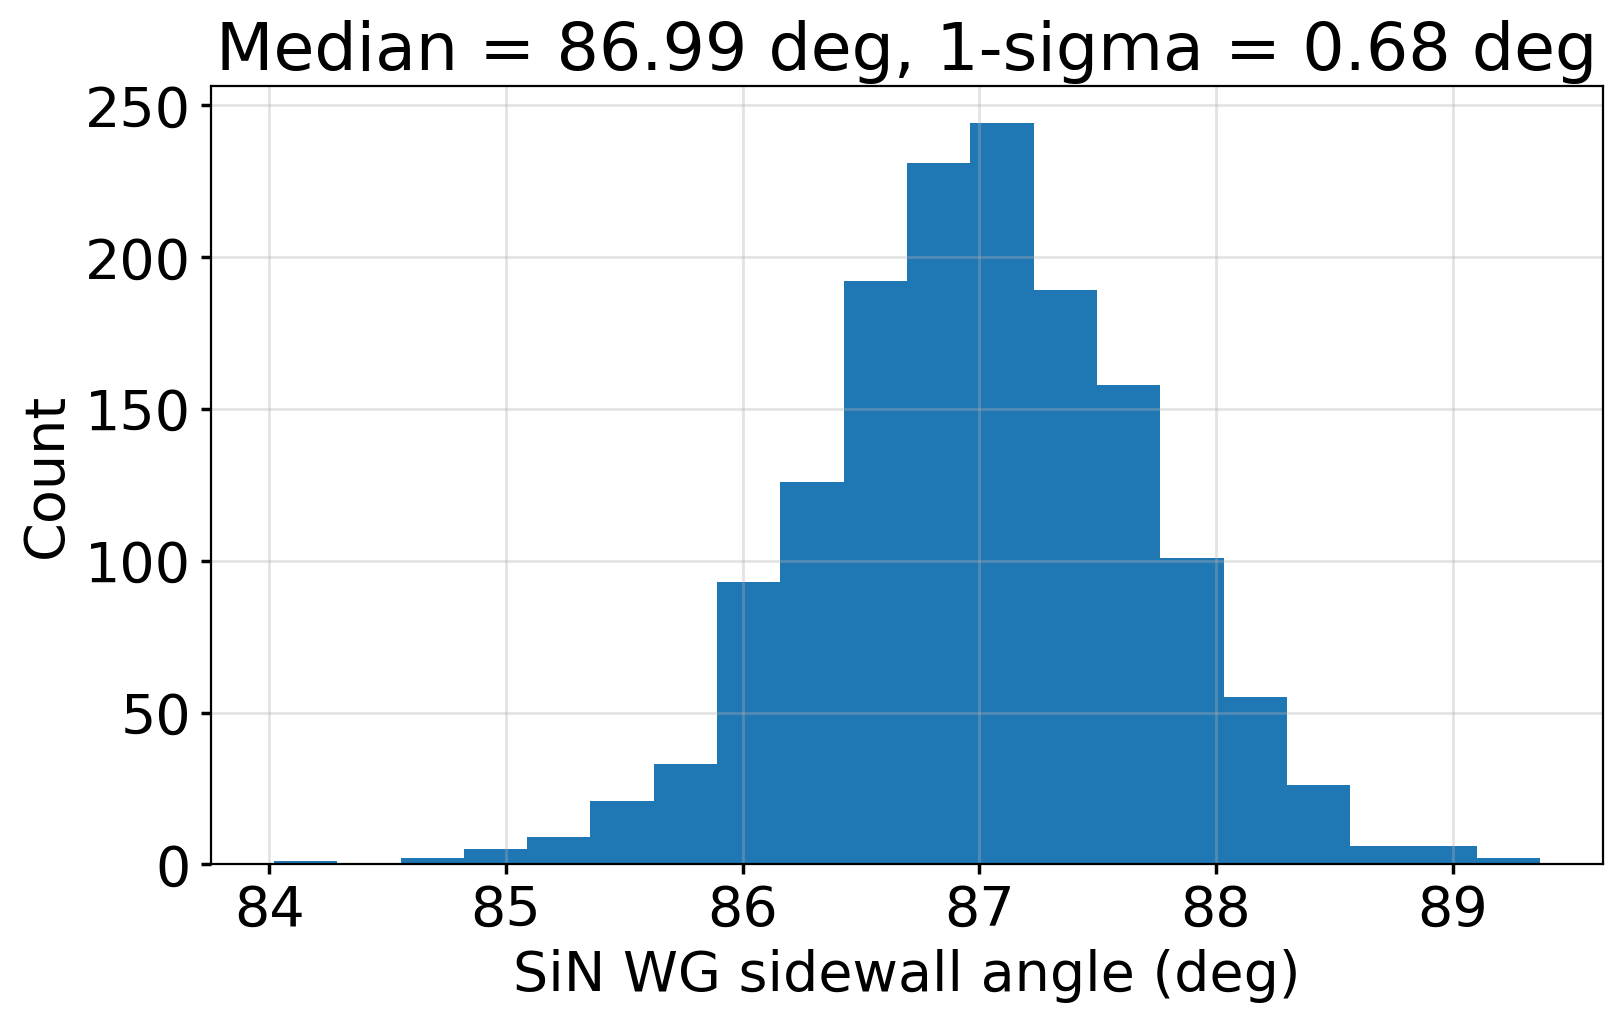

In [12]:
plt.figure()
plt.hist(rand_wg_sidewall_angle_dataset["wg_width (nm)"]*1000, bins=20)
plt.grid(True)
plt.xlabel('SiN WG width (nm)')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_sidewall_angle_dataset["wg_width (nm)"]*1000):0.2f} nm, 1-sigma = {np.std(rand_wg_sidewall_angle_dataset["wg_width (nm)"]*1000):0.2f} nm')

plt.figure()
plt.hist(rand_wg_sidewall_angle_dataset["wg_height (nm)"]*1000, bins=20)
plt.grid(True)
plt.xlabel('SiN WG height (nm)')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_sidewall_angle_dataset["wg_height (nm)"]*1000):0.2f} nm, 1-sigma = {np.std(rand_wg_sidewall_angle_dataset["wg_height (nm)"]*1000):0.2f} nm')

plt.figure()
plt.hist(
    90-rand_wg_sidewall_angle_dataset["wg_sidewall_angle (rad)"].values/np.pi*180, bins=20)
plt.grid(True)
plt.xlabel('SiN WG sidewall angle (deg)')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(90-rand_wg_sidewall_angle_dataset["wg_sidewall_angle (rad)"].values/np.pi*180):0.2f} deg, 1-sigma = {np.std(90-rand_wg_sidewall_angle_dataset["wg_sidewall_angle (rad)"].values/np.pi*180):0.2f} deg')


Text(0.5, 1.0, 'Median = 1.9306, 1-sigma = 0.0003')

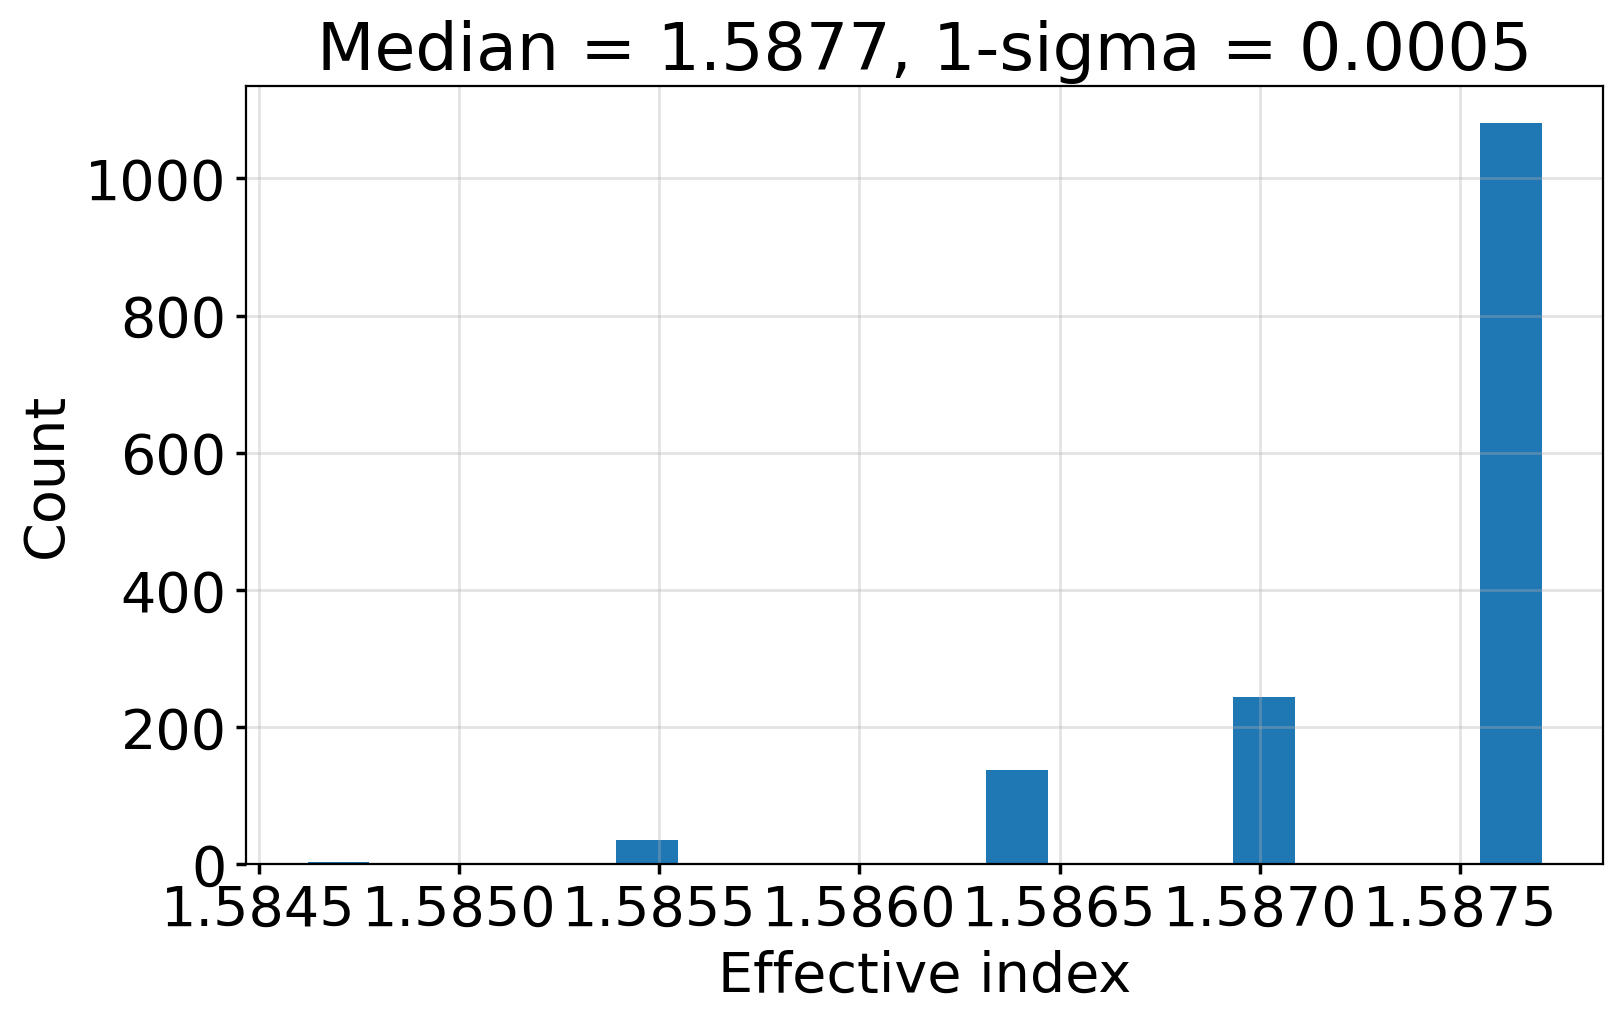

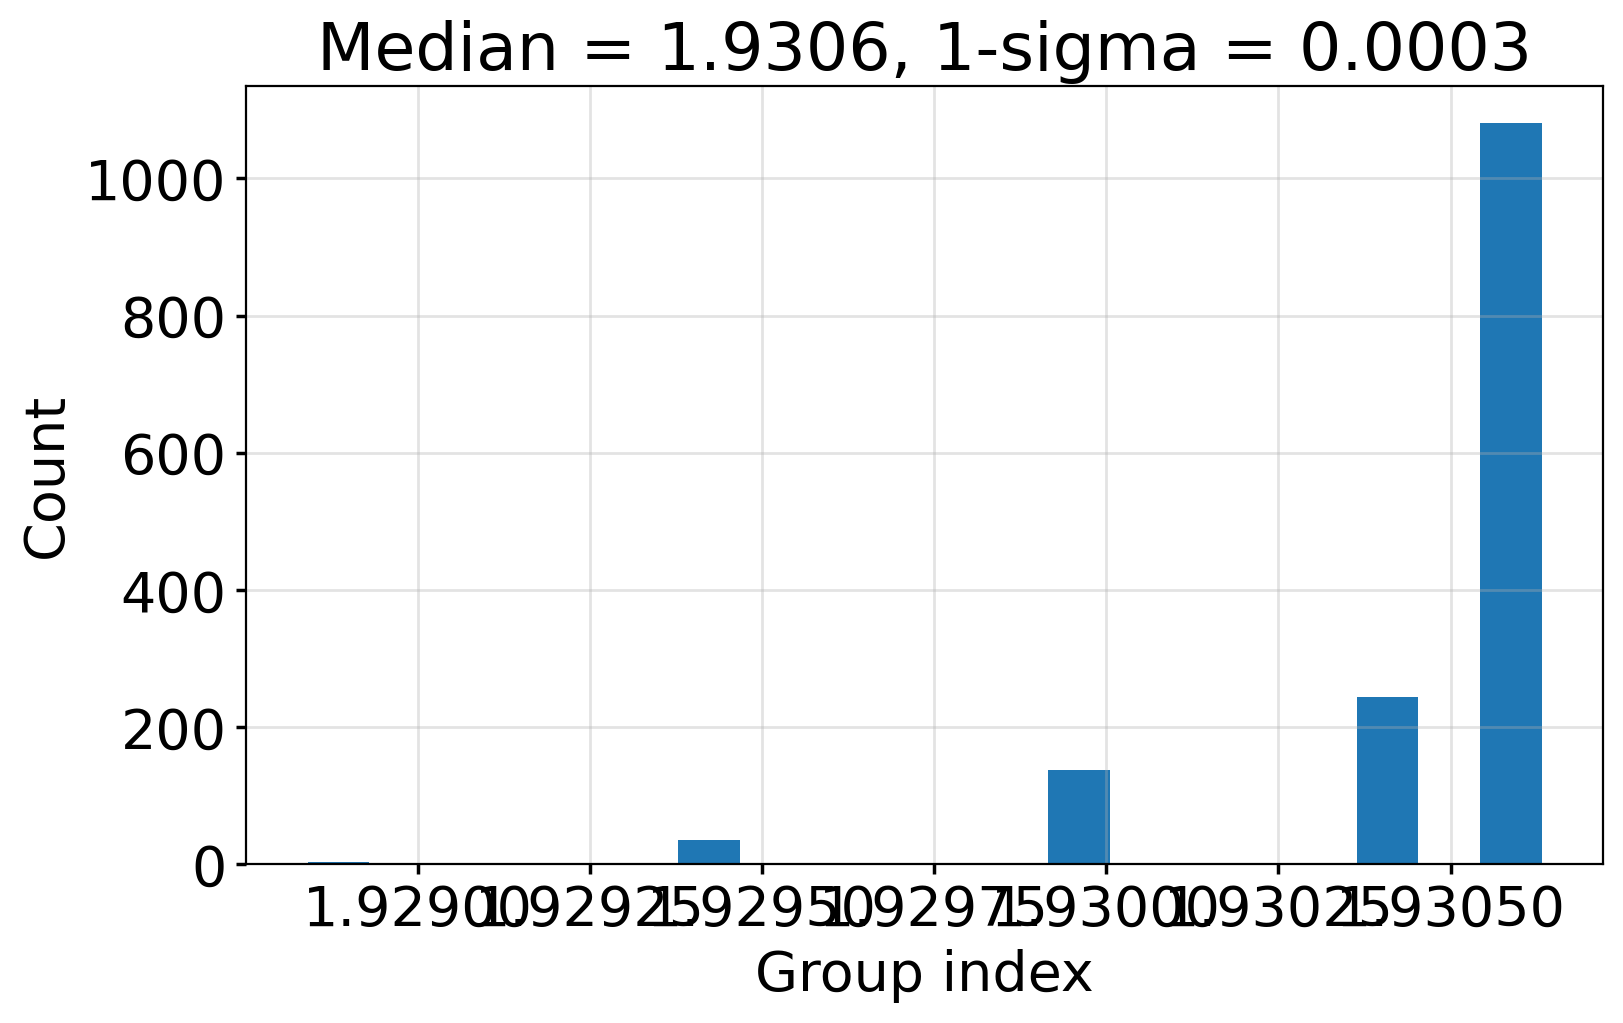

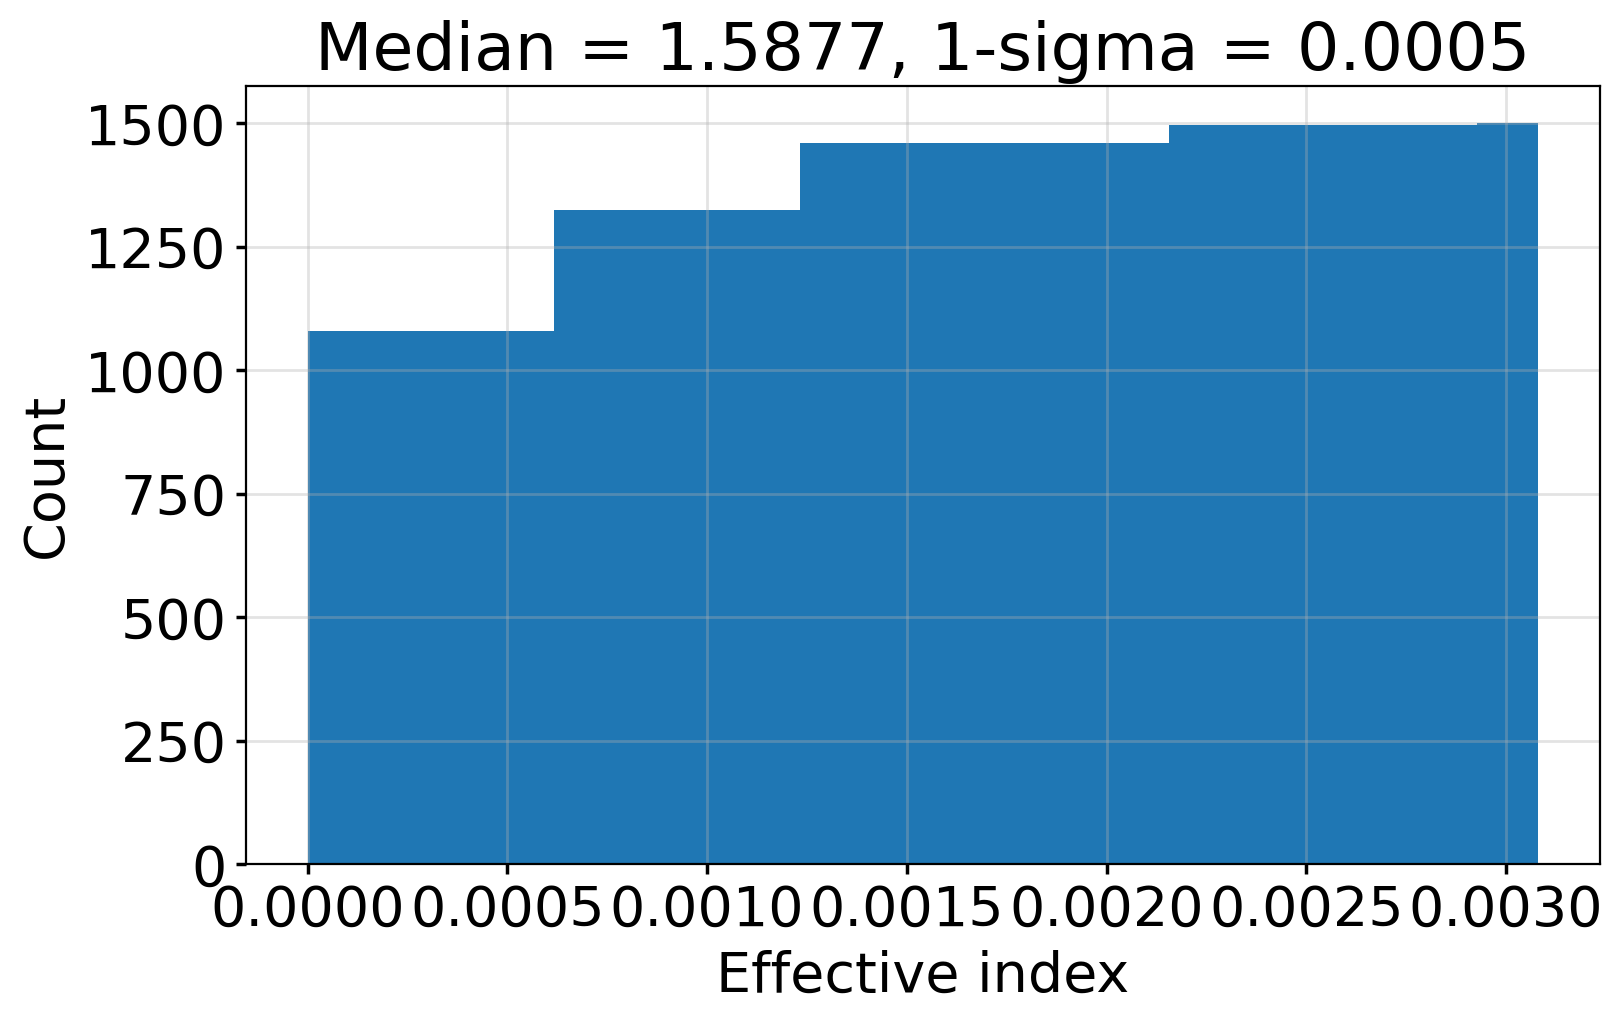

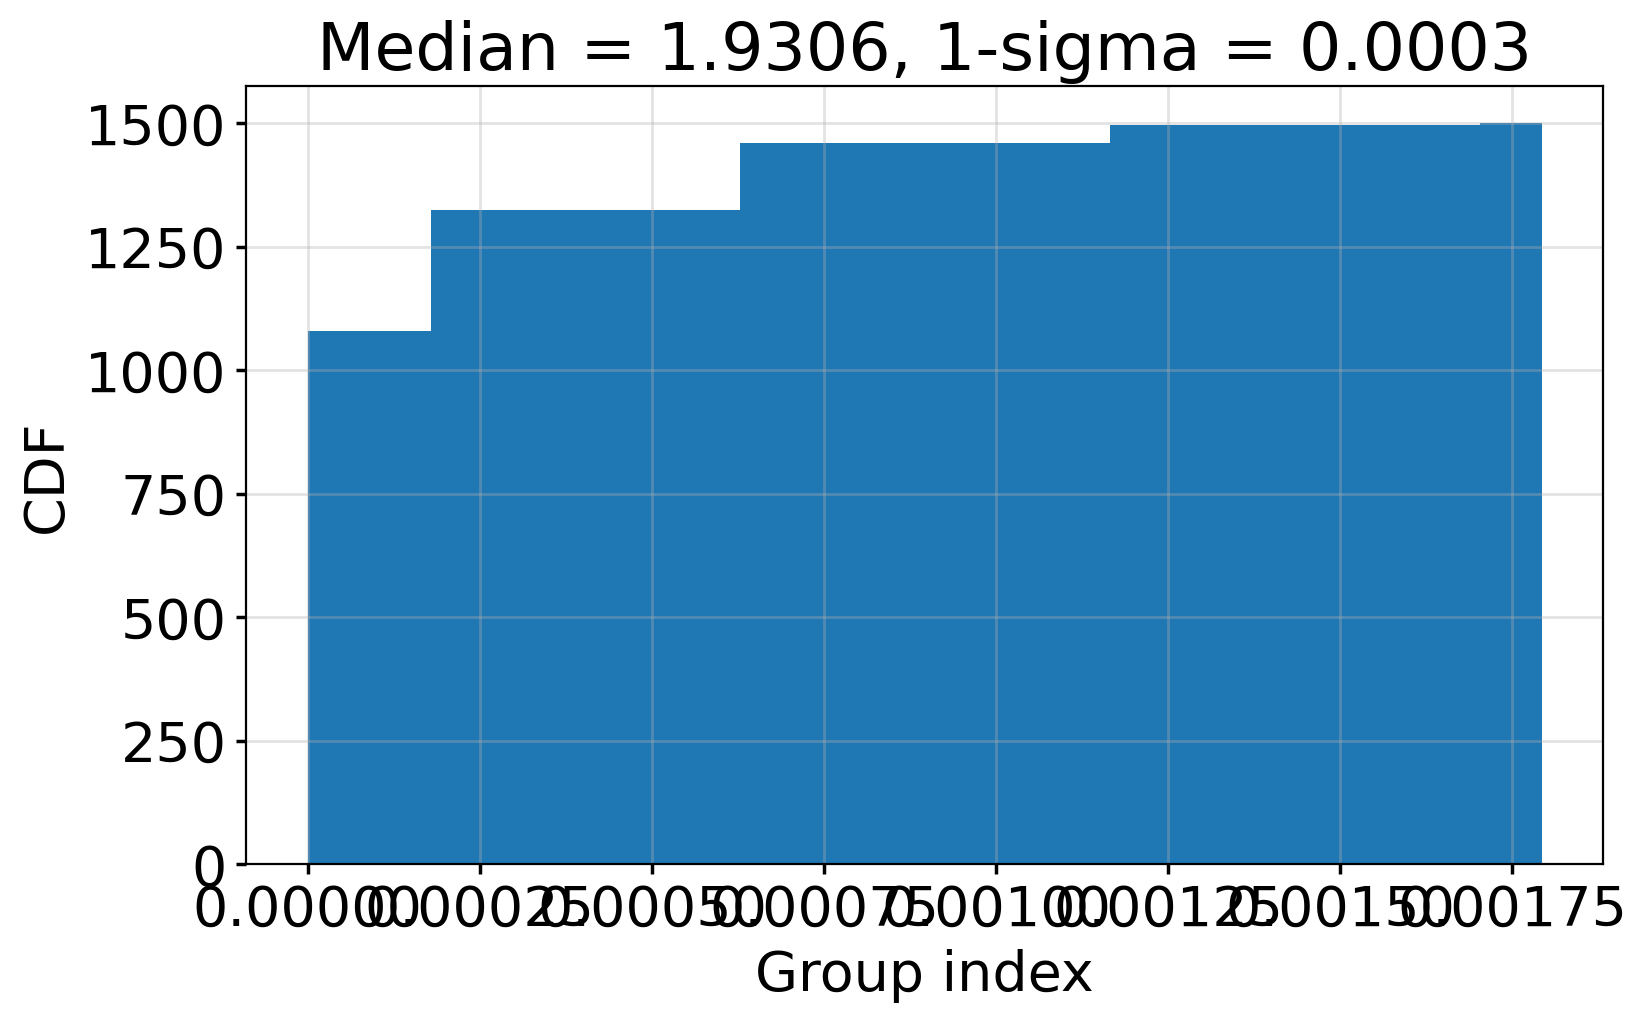

In [13]:
plt.figure()
plt.hist(rand_wg_sidewall_angle_dataset["neff_freq0"], bins=20)
plt.grid(True)
plt.xlabel('Effective index')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_sidewall_angle_dataset["neff_freq0"]):0.4f}, 1-sigma = {np.std(rand_wg_sidewall_angle_dataset["neff_freq0"]):0.4f}')

plt.figure()
plt.hist(rand_wg_sidewall_angle_dataset["ng_freq0"], bins=20)
plt.grid(True)
plt.xlabel('Group index')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_sidewall_angle_dataset["ng_freq0"]):0.4f}, 1-sigma = {np.std(rand_wg_sidewall_angle_dataset["ng_freq0"]):0.4f}')

plt.figure()
plt.hist(np.abs(rand_wg_sidewall_angle_dataset["neff_freq0"]-np.median(rand_wg_sidewall_angle_dataset["neff_freq0"])), bins=20, cumulative = True)
plt.grid(True)
plt.xlabel('Effective index')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_sidewall_angle_dataset["neff_freq0"]):0.4f}, 1-sigma = {np.std(rand_wg_sidewall_angle_dataset["neff_freq0"]):0.4f}')

plt.figure()
plt.hist(np.abs(rand_wg_sidewall_angle_dataset["ng_freq0"]-np.median(rand_wg_sidewall_angle_dataset["ng_freq0"])), bins=20, cumulative = True)
plt.grid(True)
plt.xlabel('Group index')
plt.ylabel('CDF')
plt.title(
    f'Median = {np.median(rand_wg_sidewall_angle_dataset["ng_freq0"]):0.4f}, 1-sigma = {np.std(rand_wg_sidewall_angle_dataset["ng_freq0"]):0.4f}')



## Thickness variation only

In [14]:
wg_width_choice, wg_height_choice, wg_sidewall_angle_choice = [], [], []
ng_freq0_spread = []
ng_dfreq_spread = []
neff_freq0_spread = []
neff_dfreq_spread = []

for i in tqdm(range(num_samples), desc="mode_simulations"):
  # rand_wg_width_choice = wg_width_spread[permutation_choice_width[i]]
  rand_wg_width_choice = wg_width
  rand_wg_height_choice = wg_height_spread[permutation_choice_height[i]]
  # rand_wg_sidewall_angle_choice = wg_sidewall_angle_spread[permutation_choice_sidewall_angle[i]]
  # rand_wg_height_choice = wg_height
  rand_wg_sidewall_angle_choice = wg_sidewall_angle

  wg_width_choice.append(rand_wg_width_choice)
  wg_height_choice.append(rand_wg_height_choice)
  wg_sidewall_angle_choice.append(rand_wg_sidewall_angle_choice)

  mode_solver, mode_data_df = mode_data_calculator(
      rand_wg_width_choice, 
      rand_wg_height_choice, 
      rand_wg_sidewall_angle_choice, 
      wg_n, wg_k, freqs, freq0, 
      Lx=Lx, Ly=Ly, Lz=Lz, dl=dl,
      min_steps_per_wvl=min_steps_per_wvl
  )

  fundamental_mode_data_df = mode_data_df[mode_data_df["wavelength"] == 1.31]
  ng_freq0 = fundamental_mode_data_df["group index"].values[0]
  ng_dfreq = (mode_data_df["group index"].values[-1] -
              mode_data_df["group index"].values[0])/2
  neff_freq0 = fundamental_mode_data_df["n eff"].values[0]
  neff_dfreq = (mode_data_df["n eff"].values[-1] -
                mode_data_df["n eff"].values[0])/2
  
  ng_freq0_spread.append(ng_freq0)
  ng_dfreq_spread.append(ng_dfreq)
  neff_freq0_spread.append(neff_freq0)
  neff_dfreq_spread.append(neff_dfreq)

rand_wg_height_dataset = pd.DataFrame(data=wg_width_choice)
rand_wg_height_dataset.columns = ['wg_width (nm)']
rand_wg_height_dataset['wg_height (nm)']=wg_height_choice
rand_wg_height_dataset['wg_sidewall_angle (rad)'] = wg_sidewall_angle_choice
rand_wg_height_dataset['rand_wg_width'] = False
rand_wg_height_dataset['rand_wg_height'] = True
rand_wg_height_dataset['rand_wg_sidewall_angle'] = False
rand_wg_height_dataset['neff_freq0'] = neff_freq0_spread
rand_wg_height_dataset['neff_dfreq'] = neff_dfreq_spread
rand_wg_height_dataset['ng_freq0'] = ng_freq0_spread
rand_wg_height_dataset['ng_dfreq'] = ng_dfreq_spread
rand_wg_height_dataset['freq0 (Hz)']=freq0
rand_wg_height_dataset['freq_lo (Hz)'] = freqs[0]
rand_wg_height_dataset['freq_hi (Hz)'] = freqs[-1]


gf45clo_pdk_sin_neff_ng_variability = pd.concat([rand_wg_width_dataset, rand_wg_sidewall_angle_dataset, rand_wg_height_dataset])
gf45clo_pdk_sin_neff_ng_variability.to_csv("gf45clo_pdk_sin_neff_ng_variability.csv")

mode_simulations: 100%|███████████████████████████████████████████████████████████████████████████| 1500/1500 [1:12:58<00:00,  2.92s/it]


Text(0.5, 1.0, 'Median = 87.00 deg, 1-sigma = 0.00 deg')

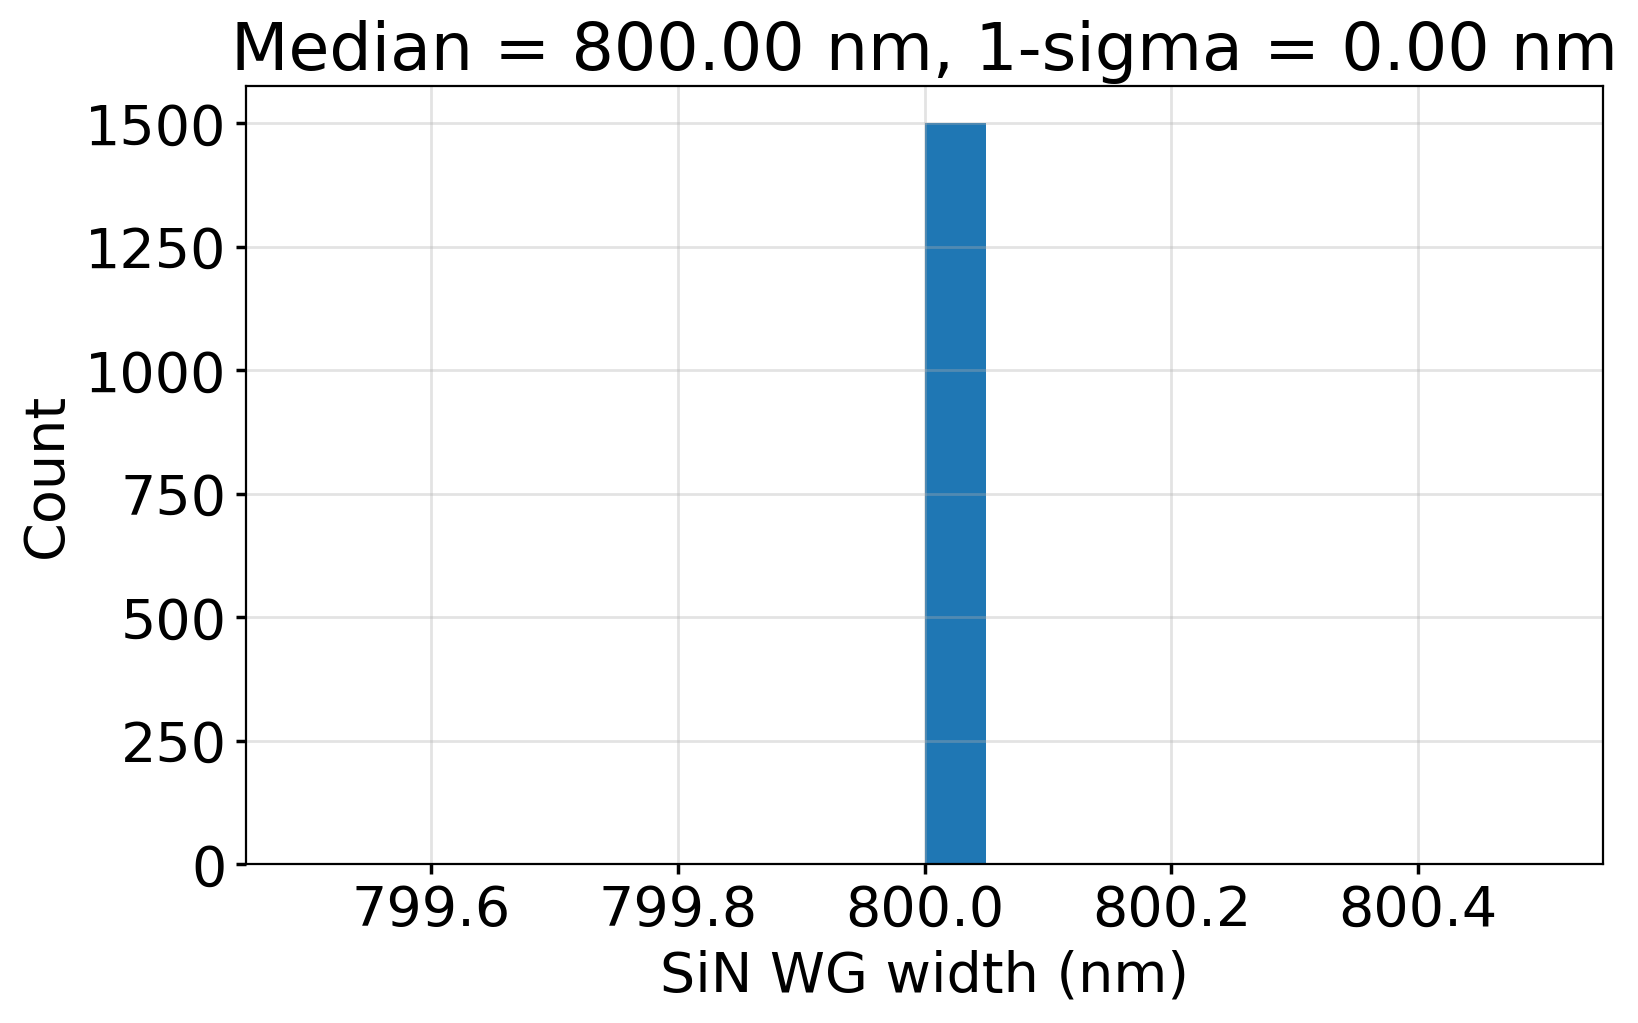

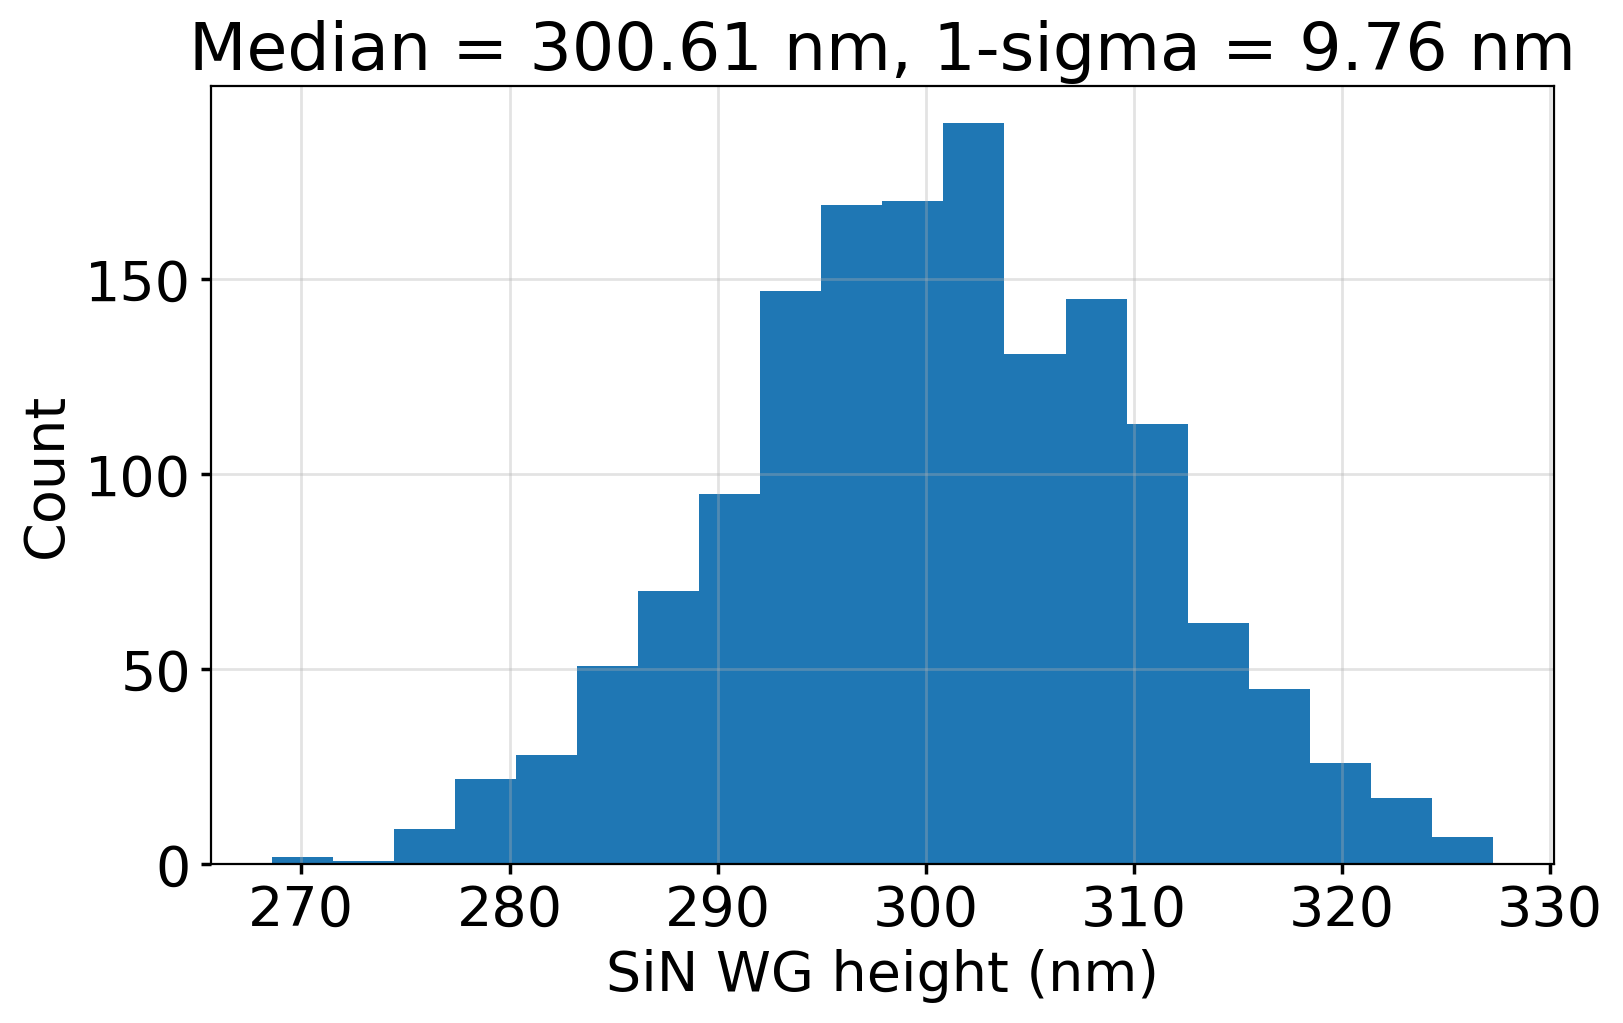

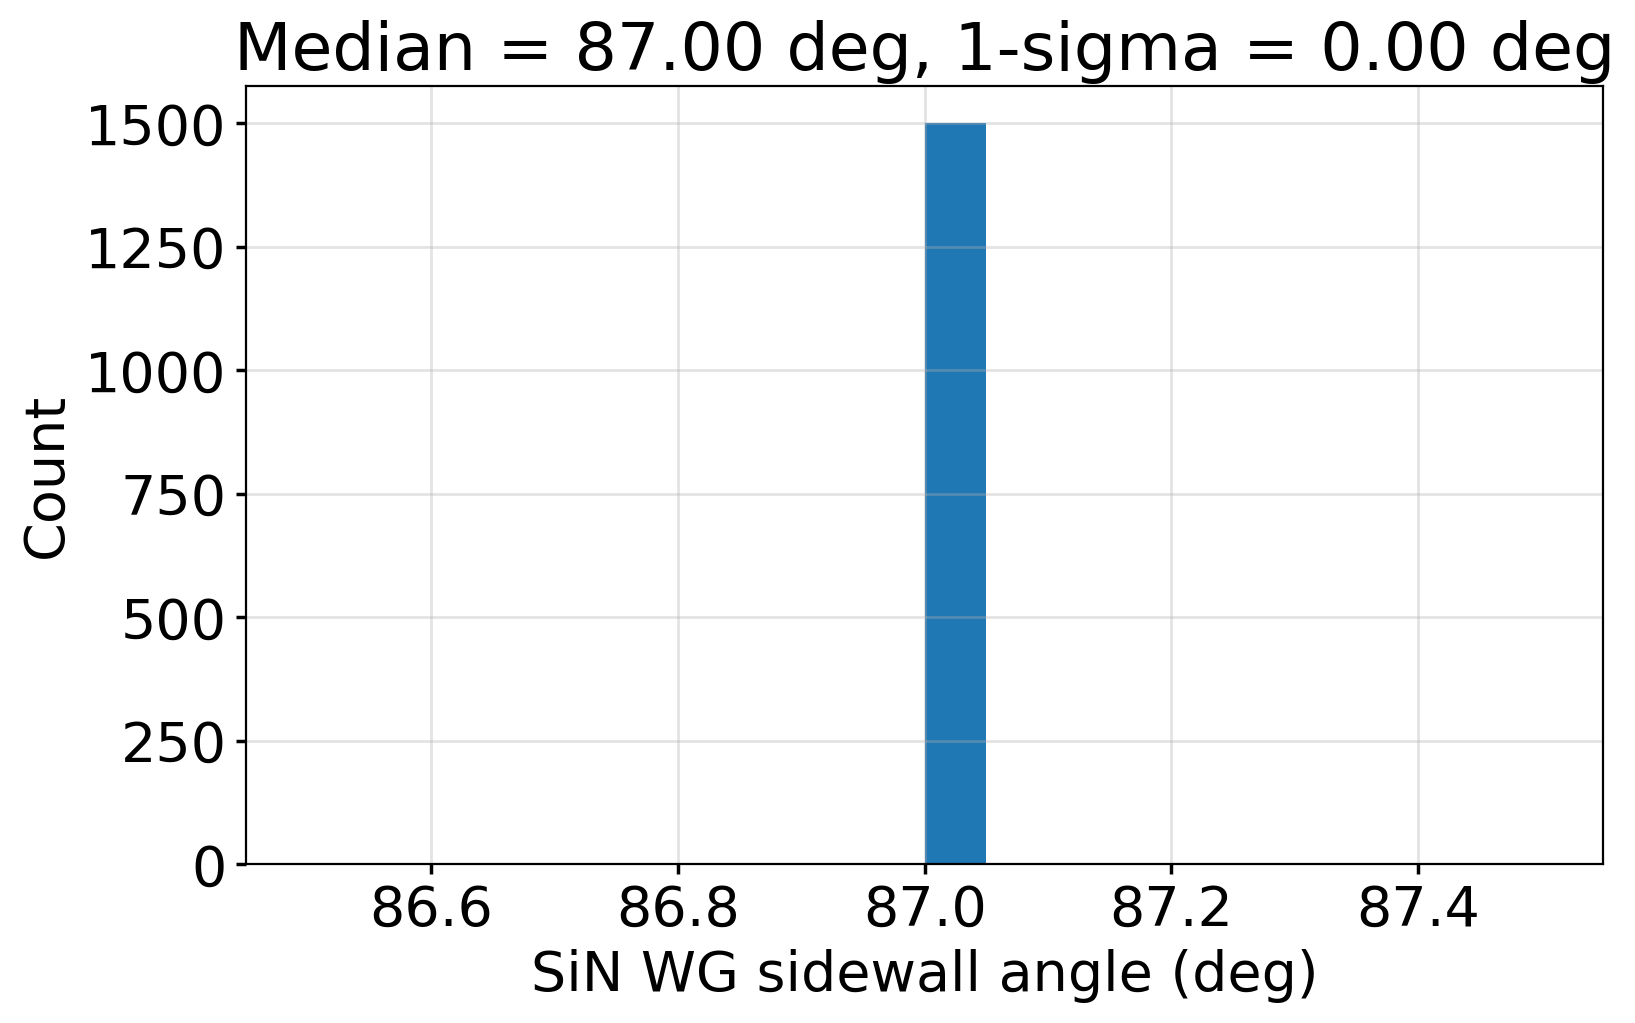

In [15]:
plt.figure()
plt.hist(rand_wg_height_dataset["wg_width (nm)"]*1000, bins=20)
plt.grid(True)
plt.xlabel('SiN WG width (nm)')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_height_dataset["wg_width (nm)"]*1000):0.2f} nm, 1-sigma = {np.std(rand_wg_height_dataset["wg_width (nm)"]*1000):0.2f} nm')

plt.figure()
plt.hist(rand_wg_height_dataset["wg_height (nm)"]*1000, bins=20)
plt.grid(True)
plt.xlabel('SiN WG height (nm)')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_height_dataset["wg_height (nm)"]*1000):0.2f} nm, 1-sigma = {np.std(rand_wg_height_dataset["wg_height (nm)"]*1000):0.2f} nm')

plt.figure()
plt.hist(
    90-rand_wg_height_dataset["wg_sidewall_angle (rad)"].values/np.pi*180, bins=20)
plt.grid(True)
plt.xlabel('SiN WG sidewall angle (deg)')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(90-rand_wg_height_dataset["wg_sidewall_angle (rad)"].values/np.pi*180):0.2f} deg, 1-sigma = {np.std(90-rand_wg_height_dataset["wg_sidewall_angle (rad)"].values/np.pi*180):0.2f} deg')


Text(0.5, 1.0, 'Median = 1.9315, 1-sigma = 0.0176')

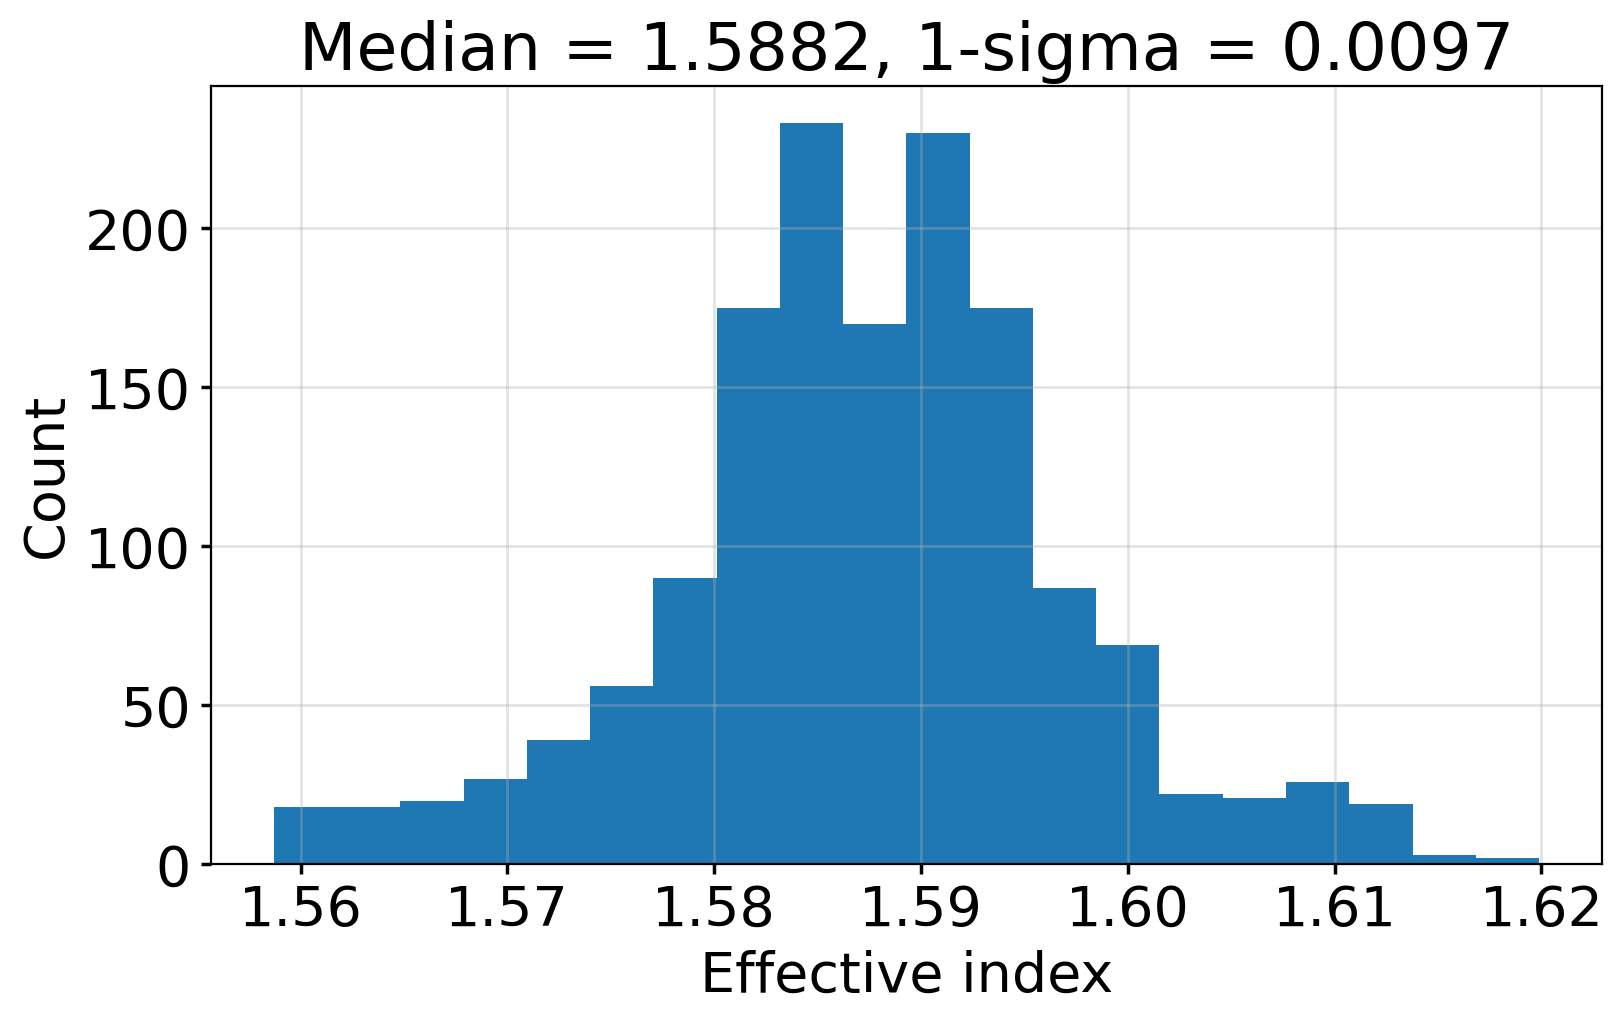

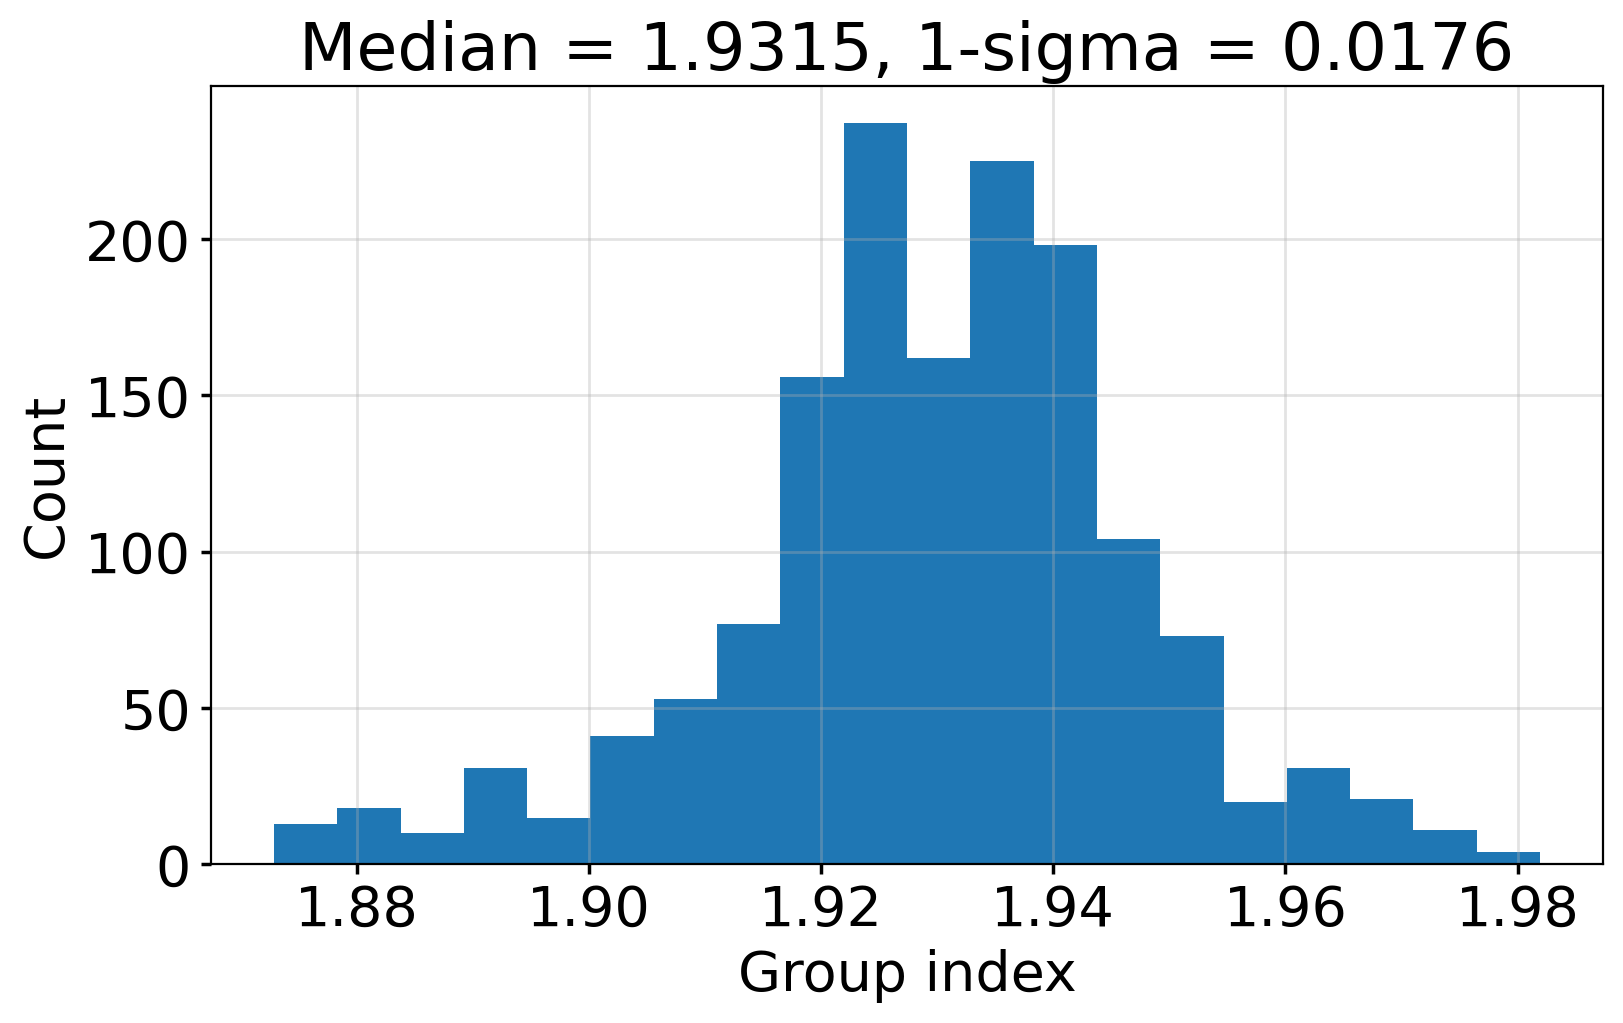

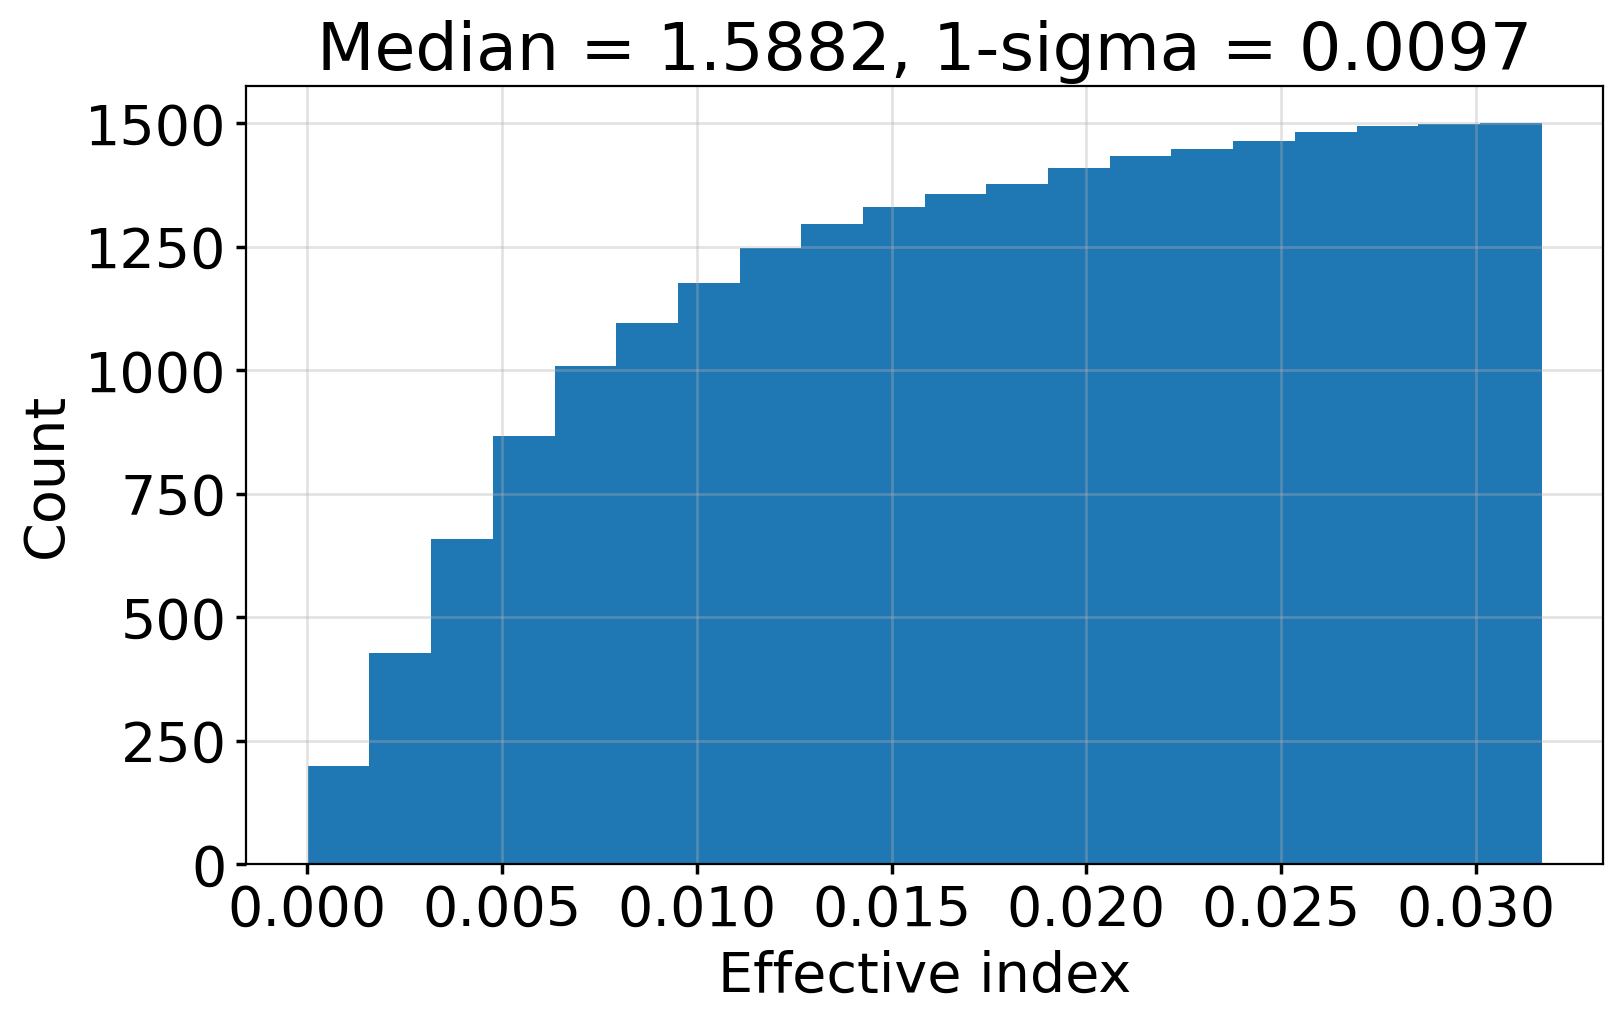

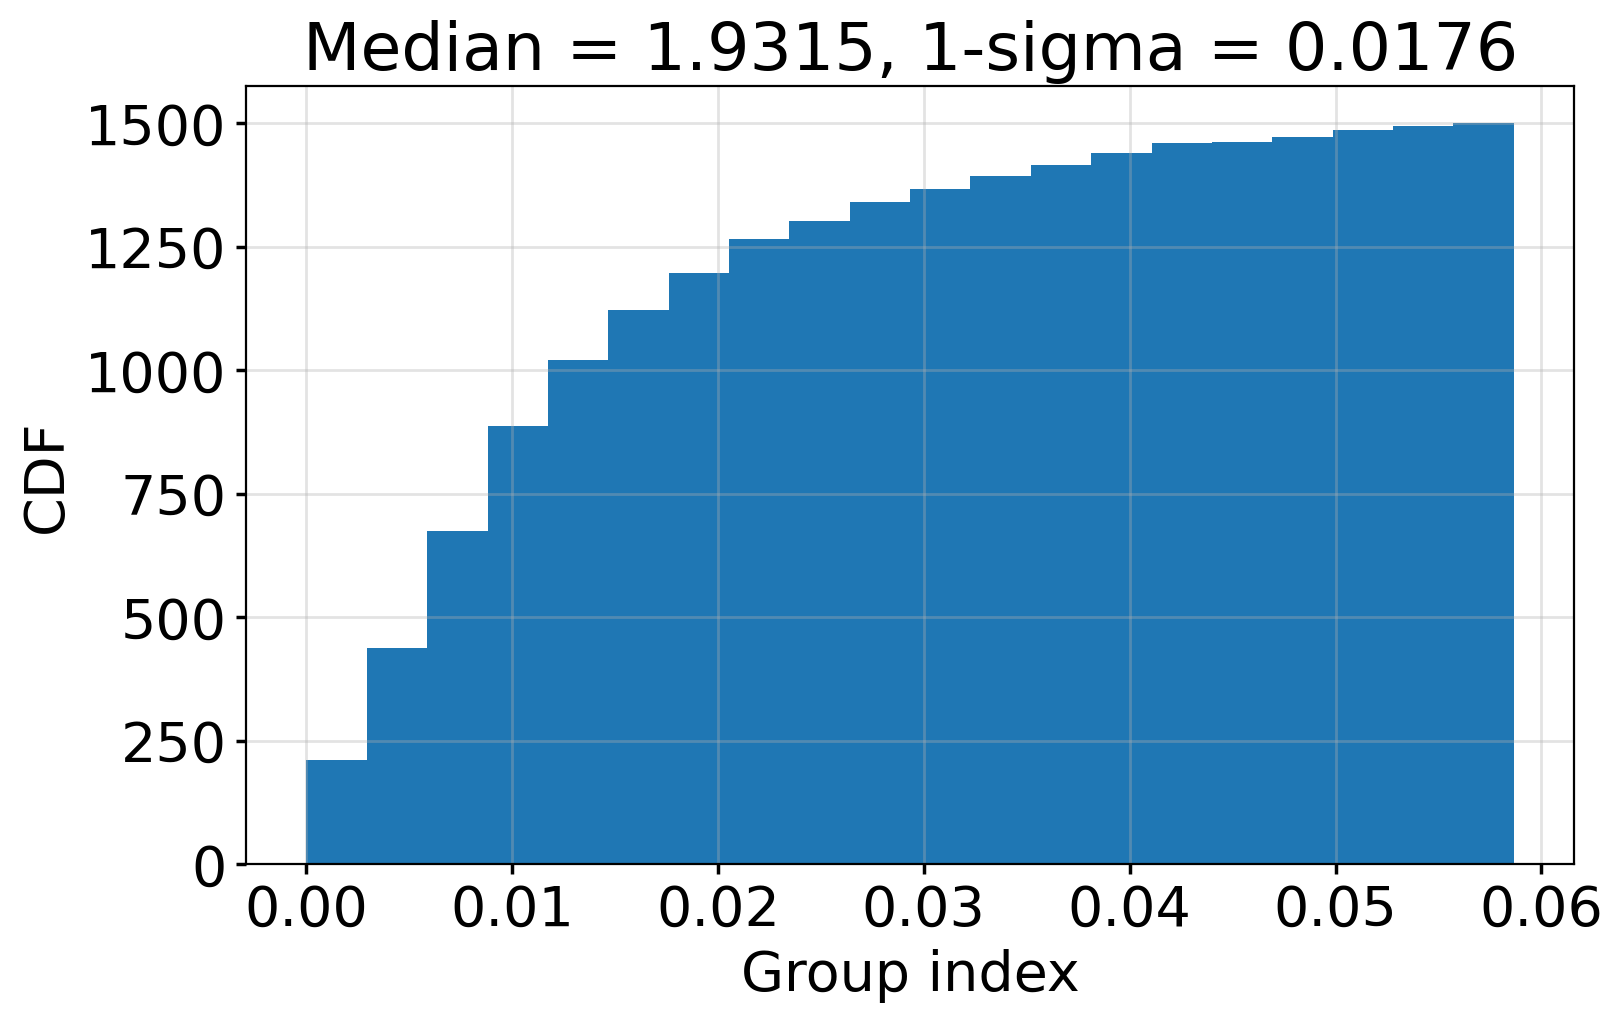

In [16]:
plt.figure()
plt.hist(rand_wg_height_dataset["neff_freq0"], bins=20)
plt.grid(True)
plt.xlabel('Effective index')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_height_dataset["neff_freq0"]):0.4f}, 1-sigma = {np.std(rand_wg_height_dataset["neff_freq0"]):0.4f}')

plt.figure()
plt.hist(rand_wg_height_dataset["ng_freq0"], bins=20)
plt.grid(True)
plt.xlabel('Group index')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_height_dataset["ng_freq0"]):0.4f}, 1-sigma = {np.std(rand_wg_height_dataset["ng_freq0"]):0.4f}')

plt.figure()
plt.hist(np.abs(rand_wg_height_dataset["neff_freq0"]-np.median(rand_wg_height_dataset["neff_freq0"])), bins=20, cumulative = True)
plt.grid(True)
plt.xlabel('Effective index')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_height_dataset["neff_freq0"]):0.4f}, 1-sigma = {np.std(rand_wg_height_dataset["neff_freq0"]):0.4f}')

plt.figure()
plt.hist(np.abs(rand_wg_height_dataset["ng_freq0"]-np.median(rand_wg_height_dataset["ng_freq0"])), bins=20, cumulative = True)
plt.grid(True)
plt.xlabel('Group index')
plt.ylabel('CDF')
plt.title(
    f'Median = {np.median(rand_wg_height_dataset["ng_freq0"]):0.4f}, 1-sigma = {np.std(rand_wg_height_dataset["ng_freq0"]):0.4f}')



## Full Monte Carlo

In [17]:
wg_width_choice, wg_height_choice, wg_sidewall_angle_choice = [], [], []
ng_freq0_spread = []
ng_dfreq_spread = []
neff_freq0_spread = []
neff_dfreq_spread = []

for i in tqdm(range(num_samples), desc="mode_simulations"):
  rand_wg_width_choice = wg_width_spread[permutation_choice_width[i]]
  rand_wg_height_choice = wg_height_spread[permutation_choice_height[i]]
  rand_wg_sidewall_angle_choice = wg_sidewall_angle_spread[permutation_choice_sidewall_angle[i]]

  wg_width_choice.append(rand_wg_width_choice)
  wg_height_choice.append(rand_wg_height_choice)
  wg_sidewall_angle_choice.append(rand_wg_sidewall_angle_choice)

  mode_solver, mode_data_df = mode_data_calculator(
      rand_wg_width_choice, 
      rand_wg_height_choice, 
      rand_wg_sidewall_angle_choice, 
      wg_n, wg_k, freqs, freq0, 
      Lx=Lx, Ly=Ly, Lz=Lz, dl=dl,
      min_steps_per_wvl=min_steps_per_wvl
  )

  fundamental_mode_data_df = mode_data_df[mode_data_df["wavelength"] == 1.31]
  ng_freq0 = fundamental_mode_data_df["group index"].values[0]
  ng_dfreq = (mode_data_df["group index"].values[-1] -
              mode_data_df["group index"].values[0])/2
  neff_freq0 = fundamental_mode_data_df["n eff"].values[0]
  neff_dfreq = (mode_data_df["n eff"].values[-1] -
                mode_data_df["n eff"].values[0])/2
  
  ng_freq0_spread.append(ng_freq0)
  ng_dfreq_spread.append(ng_dfreq)
  neff_freq0_spread.append(neff_freq0)
  neff_dfreq_spread.append(neff_dfreq)

rand_dataset = pd.DataFrame(data=wg_width_choice)
rand_dataset.columns = ['wg_width (nm)']
rand_dataset['wg_height (nm)']=wg_height_choice
rand_dataset['wg_sidewall_angle (rad)'] = wg_sidewall_angle_choice
rand_dataset['rand_wg_width'] = True
rand_dataset['rand_wg_height'] = True
rand_dataset['rand_wg_sidewall_angle'] = True
rand_dataset['neff_freq0'] = neff_freq0_spread
rand_dataset['neff_dfreq'] = neff_dfreq_spread
rand_dataset['ng_freq0'] = ng_freq0_spread
rand_dataset['ng_dfreq'] = ng_dfreq_spread
rand_dataset['freq0 (Hz)']=freq0
rand_dataset['freq_lo (Hz)'] = freqs[0]
rand_dataset['freq_hi (Hz)'] = freqs[-1]


gf45clo_pdk_sin_neff_ng_variability = pd.concat([rand_wg_width_dataset, rand_wg_sidewall_angle_dataset, rand_wg_height_dataset, rand_dataset])
gf45clo_pdk_sin_neff_ng_variability.to_csv("gf45clo_pdk_sin_neff_ng_variability.csv")

mode_simulations: 100%|███████████████████████████████████████████████████████████████████████████| 1500/1500 [1:14:04<00:00,  2.96s/it]


Text(0.5, 1.0, 'Median = 86.99 deg, 1-sigma = 0.68 deg')

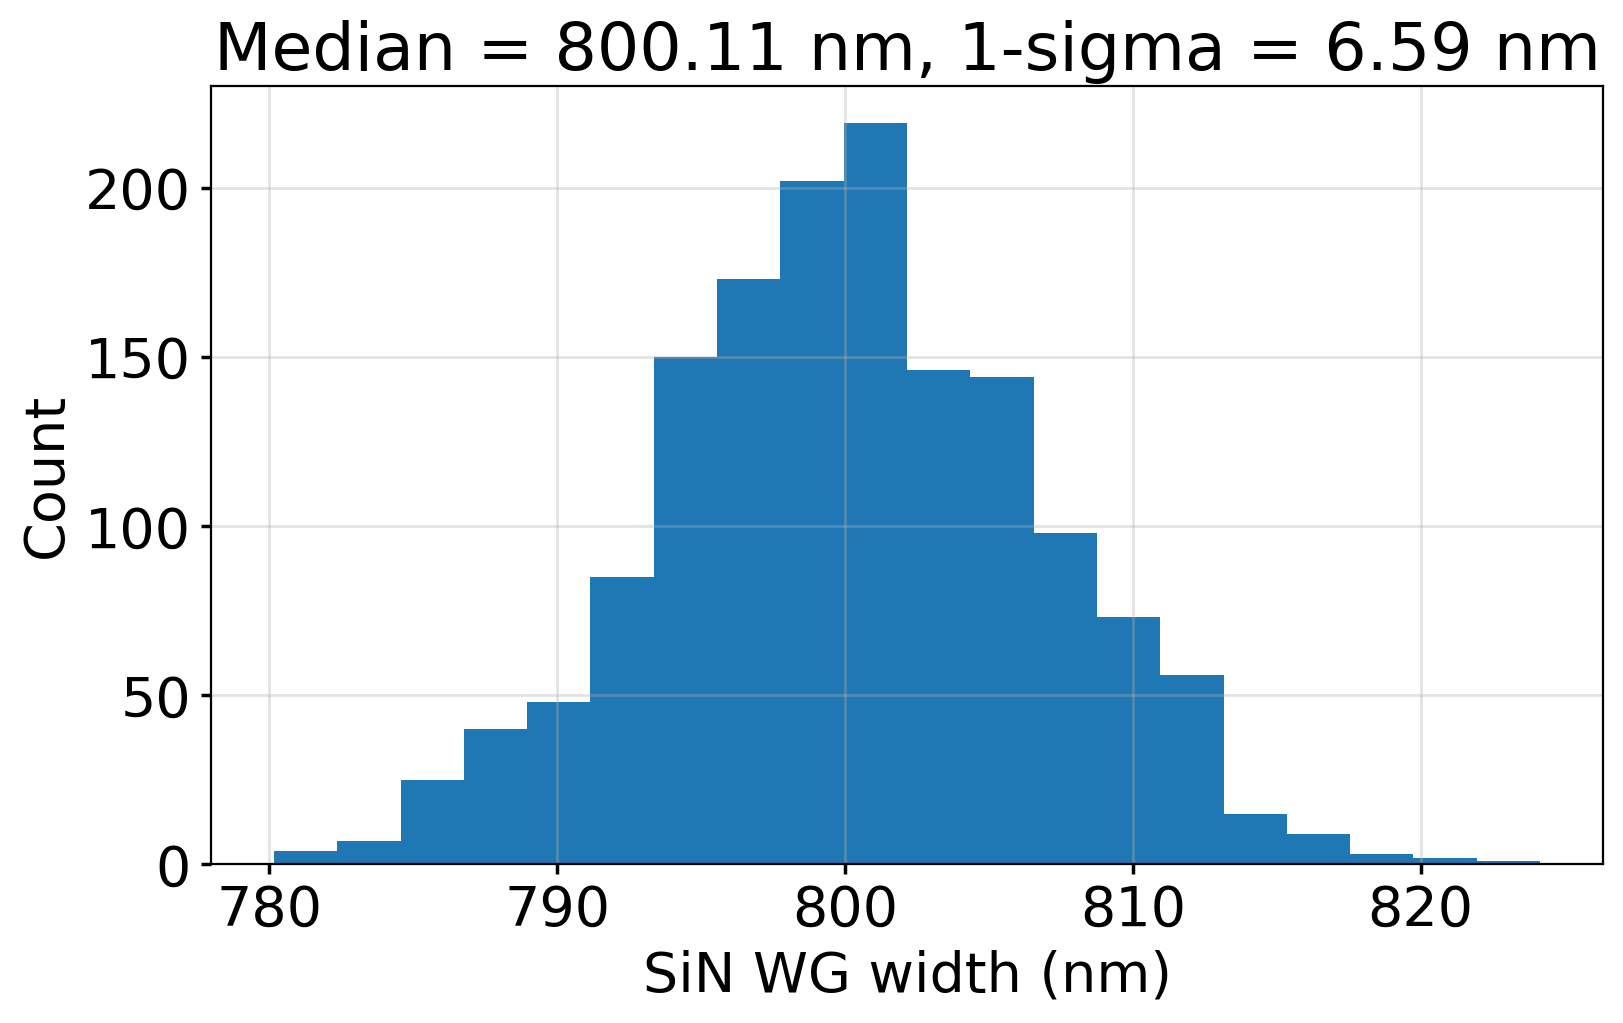

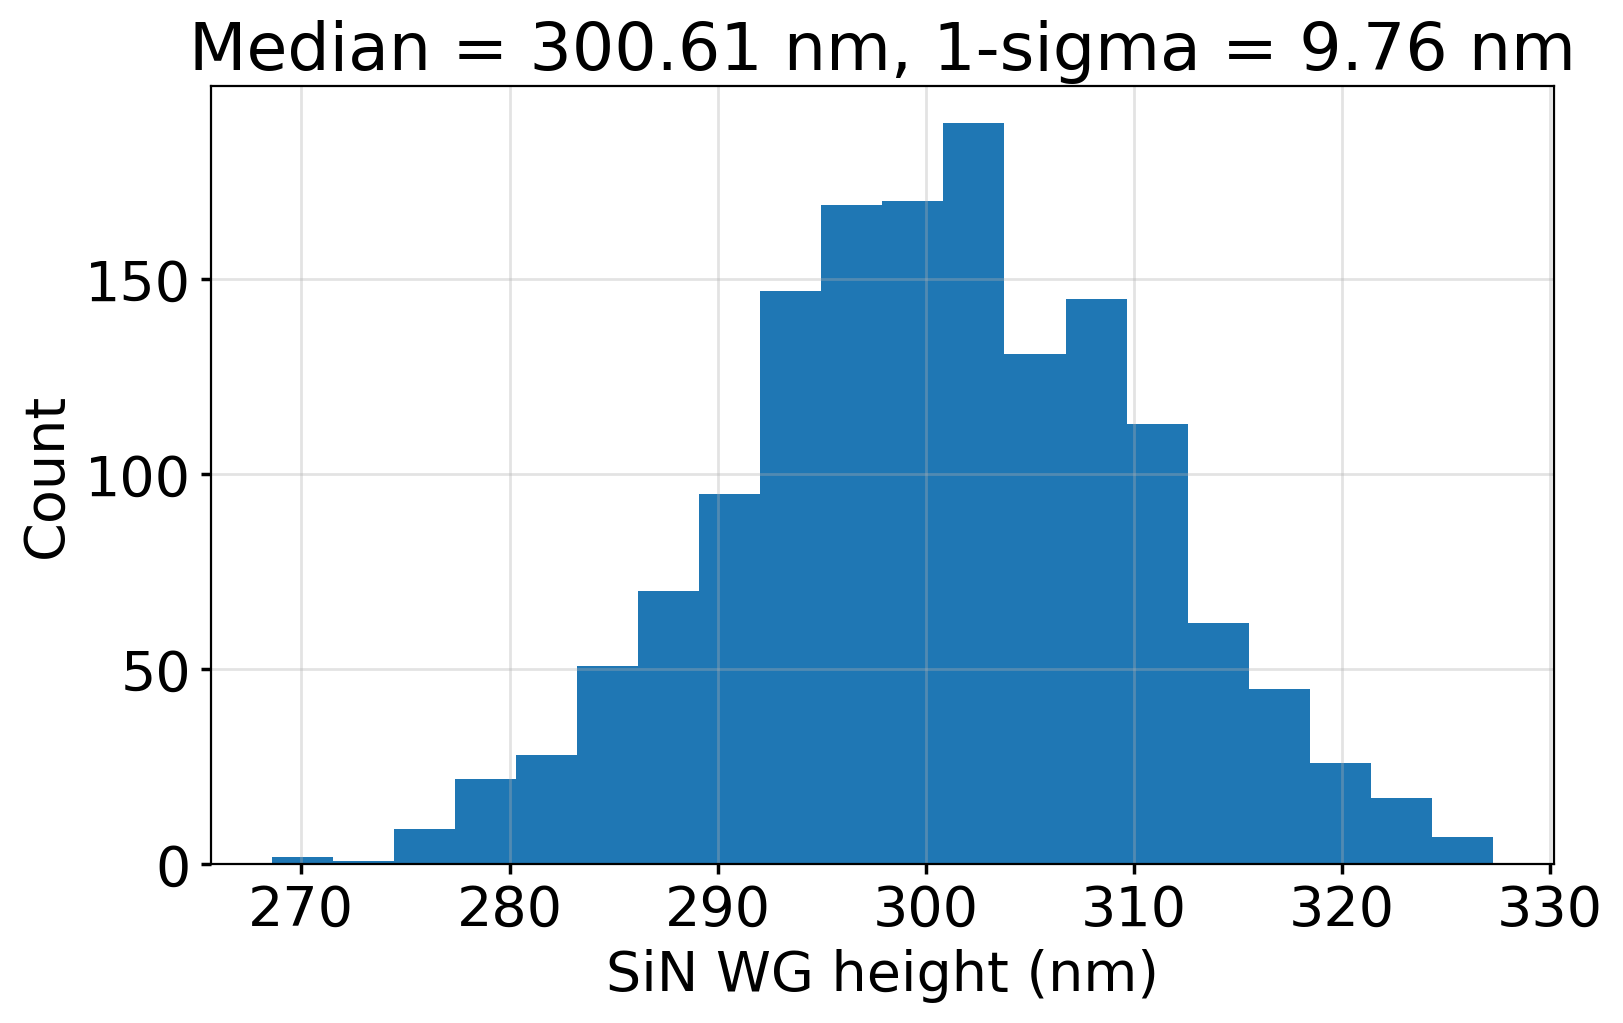

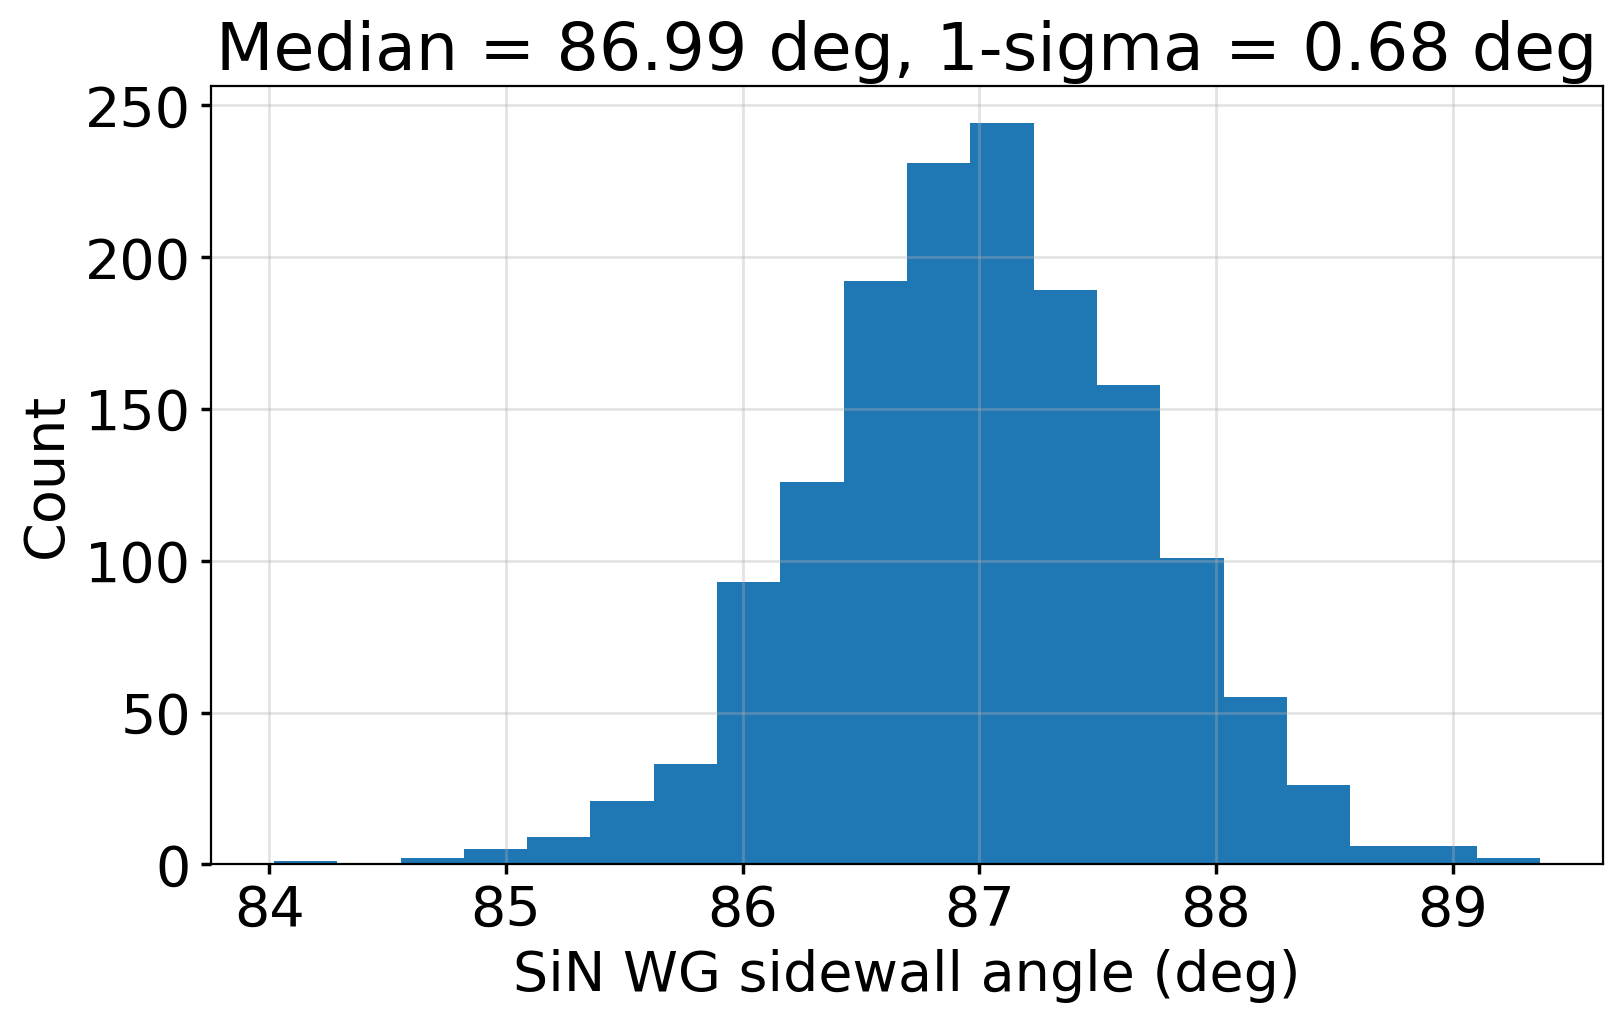

In [18]:
plt.figure()
plt.hist(rand_dataset["wg_width (nm)"]*1000, bins=20)
plt.grid(True)
plt.xlabel('SiN WG width (nm)')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_dataset["wg_width (nm)"]*1000):0.2f} nm, 1-sigma = {np.std(rand_dataset["wg_width (nm)"]*1000):0.2f} nm')

plt.figure()
plt.hist(rand_dataset["wg_height (nm)"]*1000, bins=20)
plt.grid(True)
plt.xlabel('SiN WG height (nm)')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_dataset["wg_height (nm)"]*1000):0.2f} nm, 1-sigma = {np.std(rand_dataset["wg_height (nm)"]*1000):0.2f} nm')

plt.figure()
plt.hist(
    90-rand_dataset["wg_sidewall_angle (rad)"].values/np.pi*180, bins=20)
plt.grid(True)
plt.xlabel('SiN WG sidewall angle (deg)')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(90-rand_dataset["wg_sidewall_angle (rad)"].values/np.pi*180):0.2f} deg, 1-sigma = {np.std(90-rand_dataset["wg_sidewall_angle (rad)"].values/np.pi*180):0.2f} deg')


Text(0.5, 1.0, 'Median = 1.9311, 1-sigma = 0.0176')

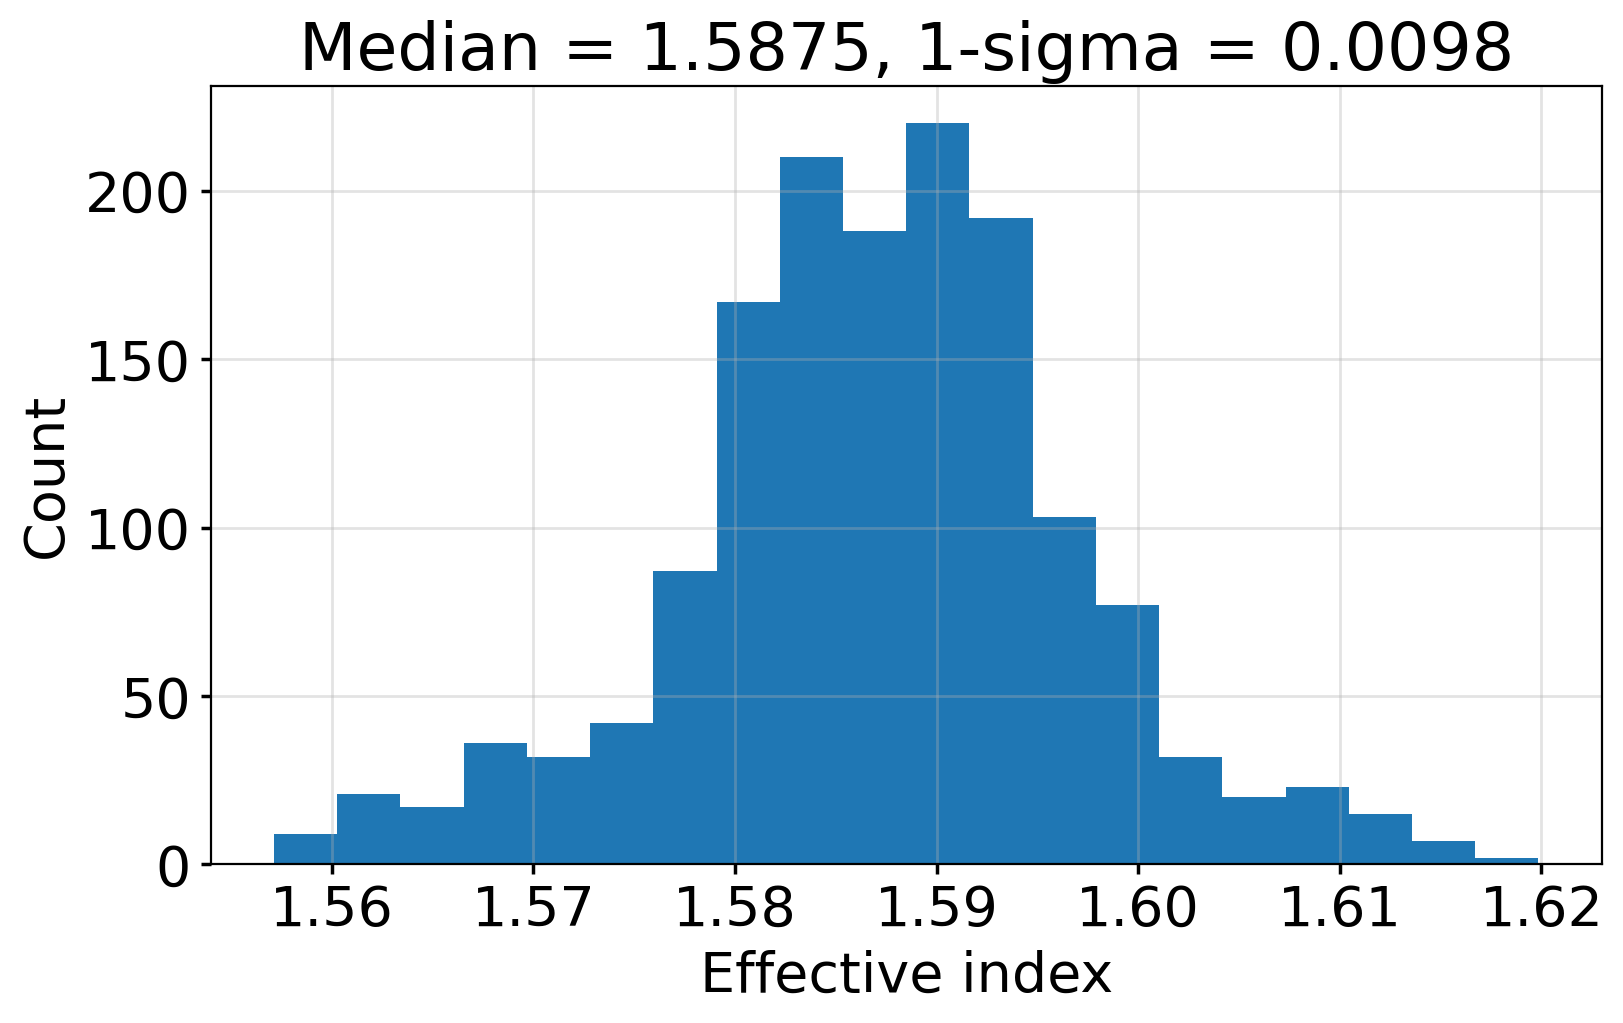

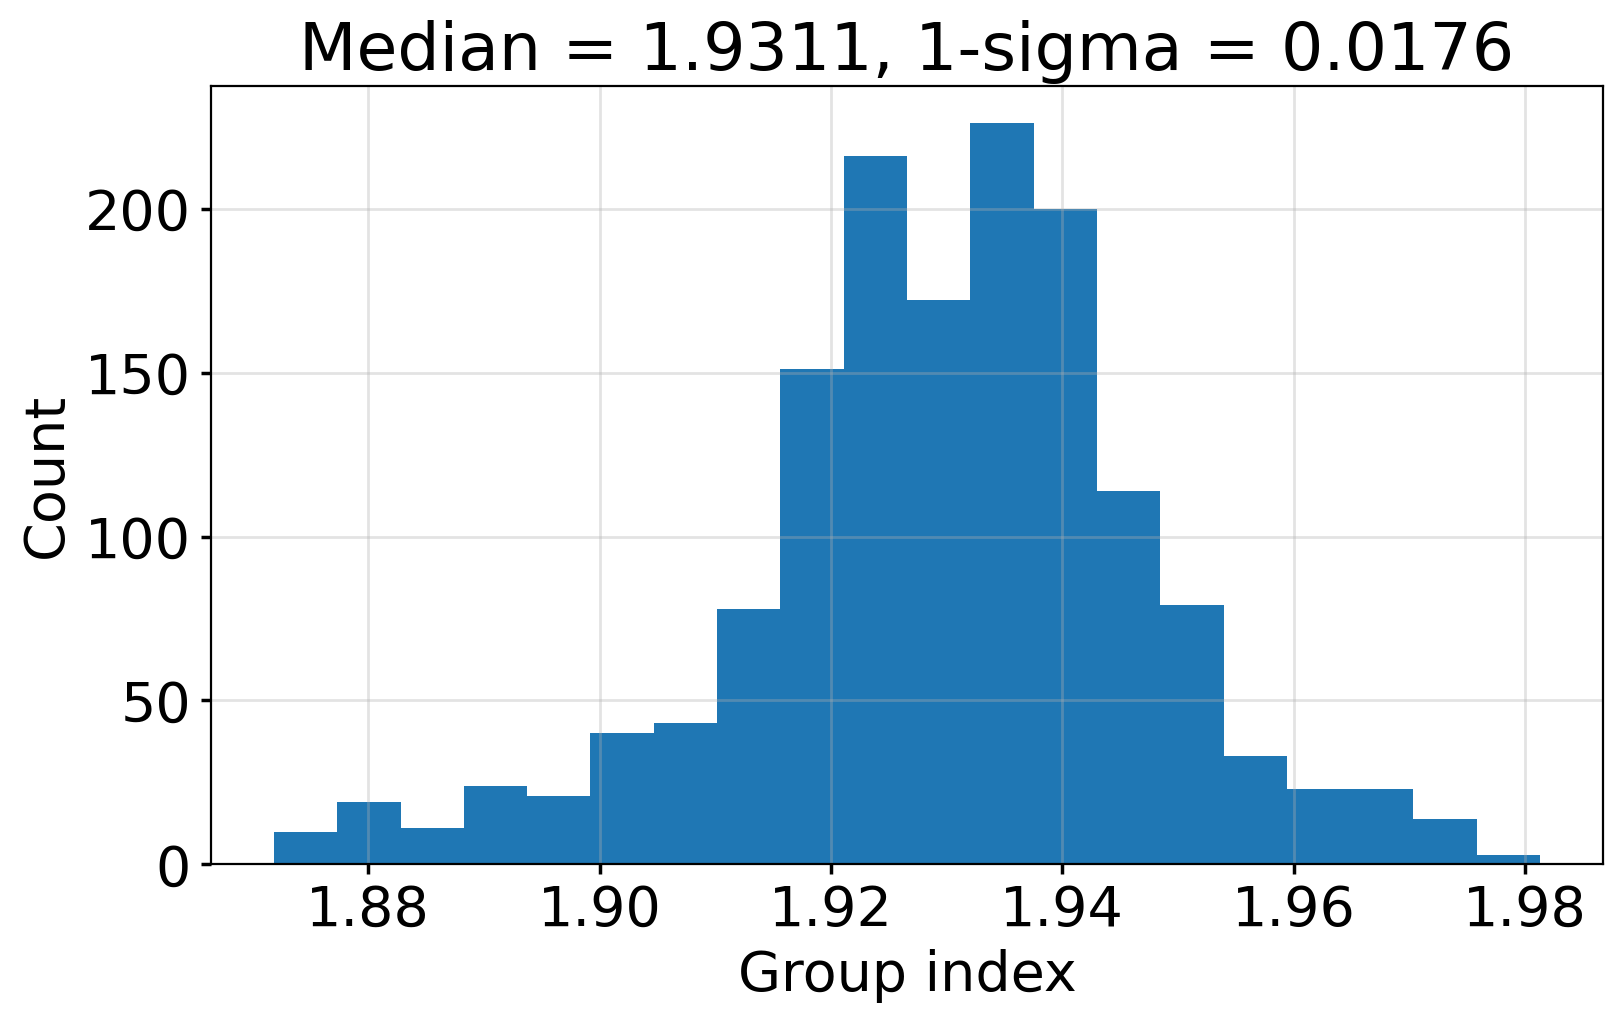

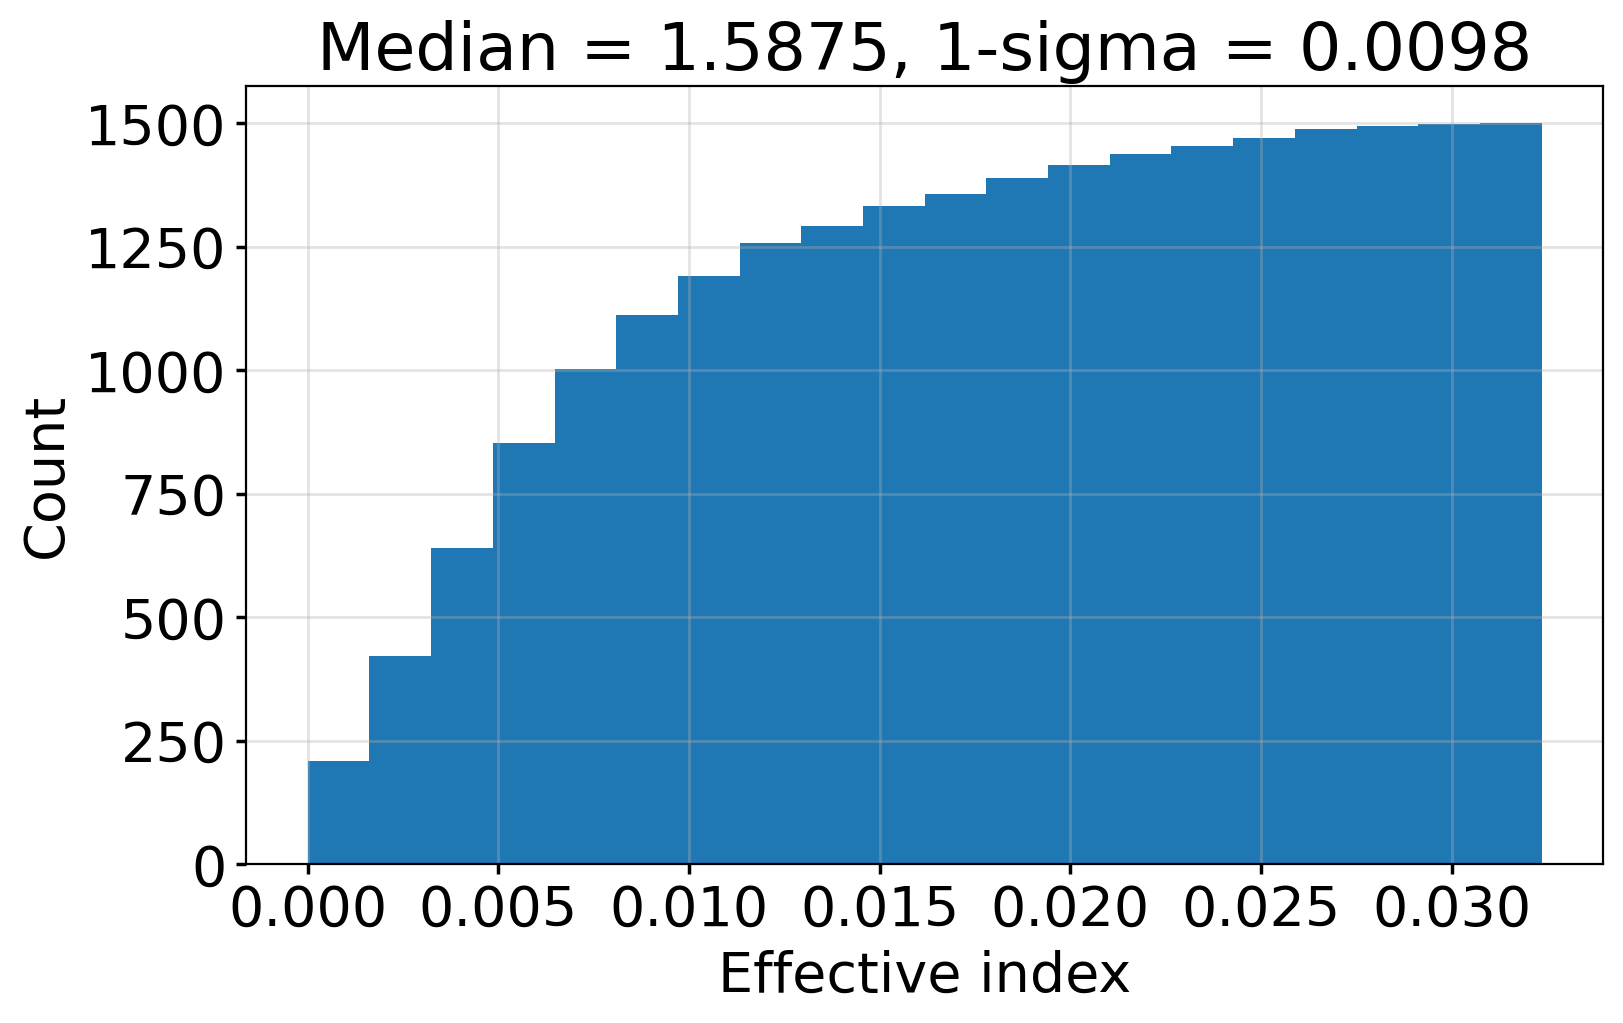

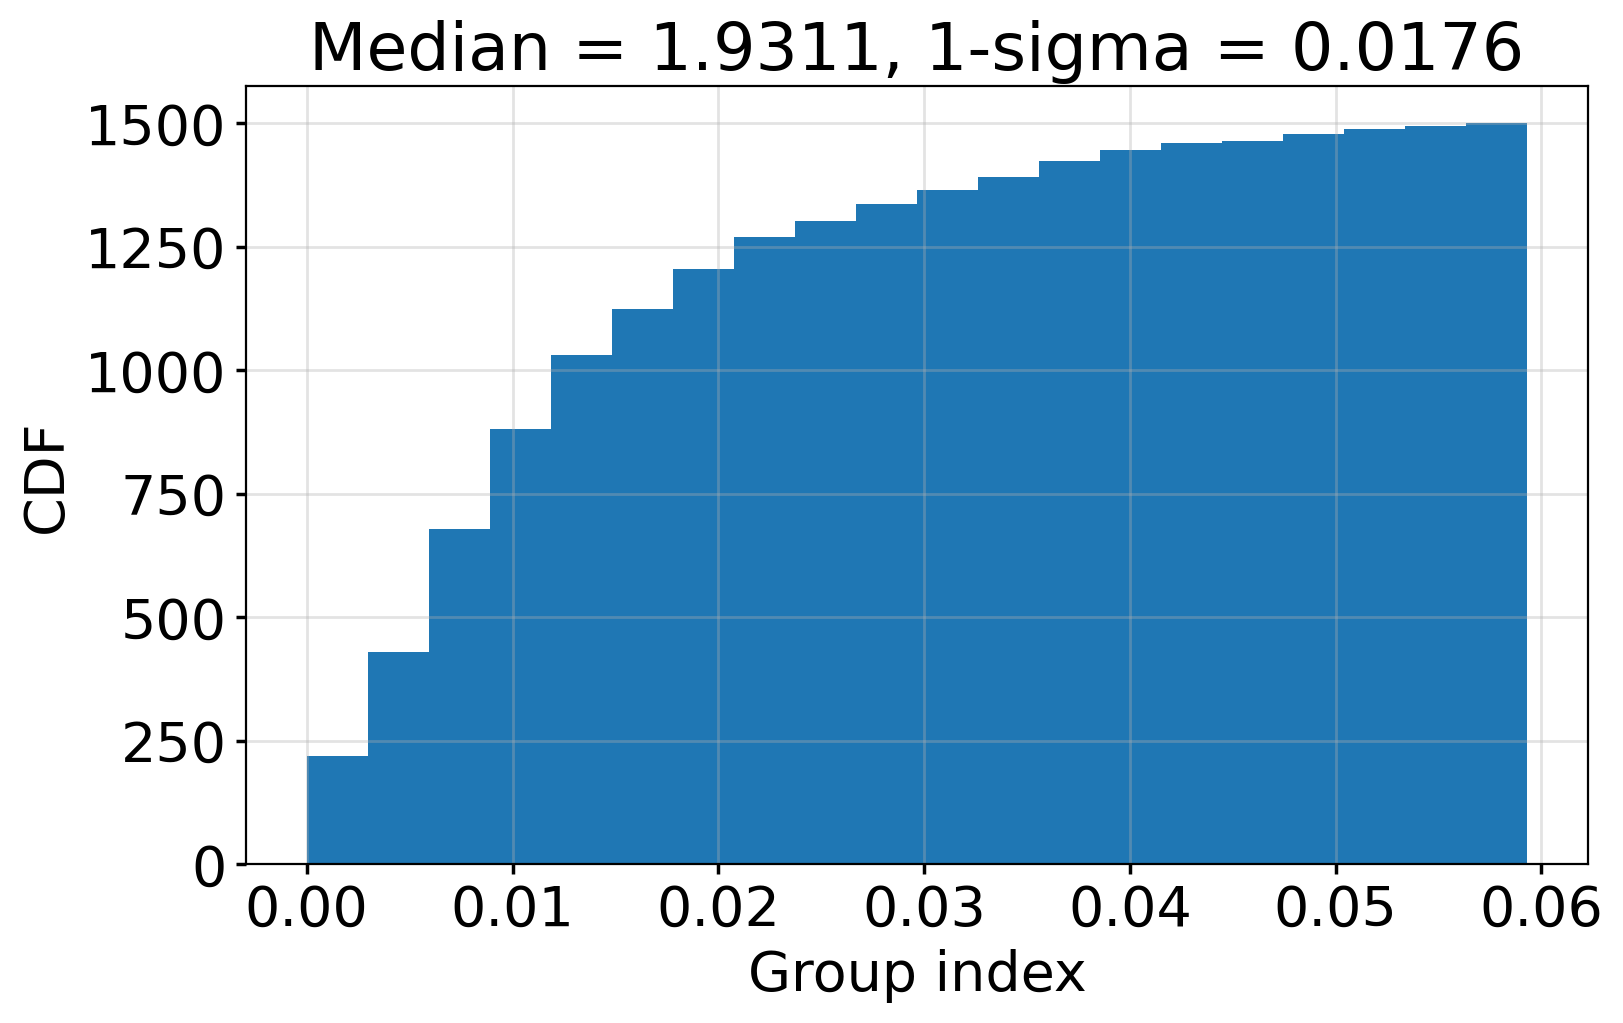

In [19]:
plt.figure()
plt.hist(rand_dataset["neff_freq0"], bins=20)
plt.grid(True)
plt.xlabel('Effective index')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_dataset["neff_freq0"]):0.4f}, 1-sigma = {np.std(rand_dataset["neff_freq0"]):0.4f}')

plt.figure()
plt.hist(rand_dataset["ng_freq0"], bins=20)
plt.grid(True)
plt.xlabel('Group index')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_dataset["ng_freq0"]):0.4f}, 1-sigma = {np.std(rand_dataset["ng_freq0"]):0.4f}')

plt.figure()
plt.hist(np.abs(rand_dataset["neff_freq0"]-np.median(rand_dataset["neff_freq0"])), bins=20, cumulative = True)
plt.grid(True)
plt.xlabel('Effective index')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_dataset["neff_freq0"]):0.4f}, 1-sigma = {np.std(rand_dataset["neff_freq0"]):0.4f}')

plt.figure()
plt.hist(np.abs(rand_dataset["ng_freq0"]-np.median(rand_dataset["ng_freq0"])), bins=20, cumulative = True)
plt.grid(True)
plt.xlabel('Group index')
plt.ylabel('CDF')
plt.title(
    f'Median = {np.median(rand_dataset["ng_freq0"]):0.4f}, 1-sigma = {np.std(rand_dataset["ng_freq0"]):0.4f}')



# Multi mode (wg width = 2000 nm)

In [20]:
Lx, Ly, Lz = 10, 10, 10
dl = 0.01

min_steps_per_wvl = 30

wg_width = 2.0
wg_height = 0.3
wg_n = 1.968
wg_k = 0

wvl_um = 1.31
freq0 = C_0/wvl_um

wg_medium = td.Medium.from_nk(n=1.968, k=0, freq=freq0)

wg_sidewall_angle = np.pi/2.0 - 87.0/180.0*np.pi

num_freqs = 3

fwidth = 3200e9  # 3200 Ghz
freqs = np.linspace(freq0-fwidth/2.0, freq0+fwidth/2.0, num_freqs)

thickness_3sigma = 0.03
width_3sigma = 0.02
sidewall_angle_3sigma = 2/90*np.pi/2

num_samples = 1500

In [21]:
mode_solver, mode_data_df = mode_data_calculator(
    wg_width, wg_height, wg_sidewall_angle, wg_n, wg_k, freqs, freq0, Lx=Lx, Ly=Ly, Lz=Lz, dl=dl, min_steps_per_wvl=min_steps_per_wvl
    )


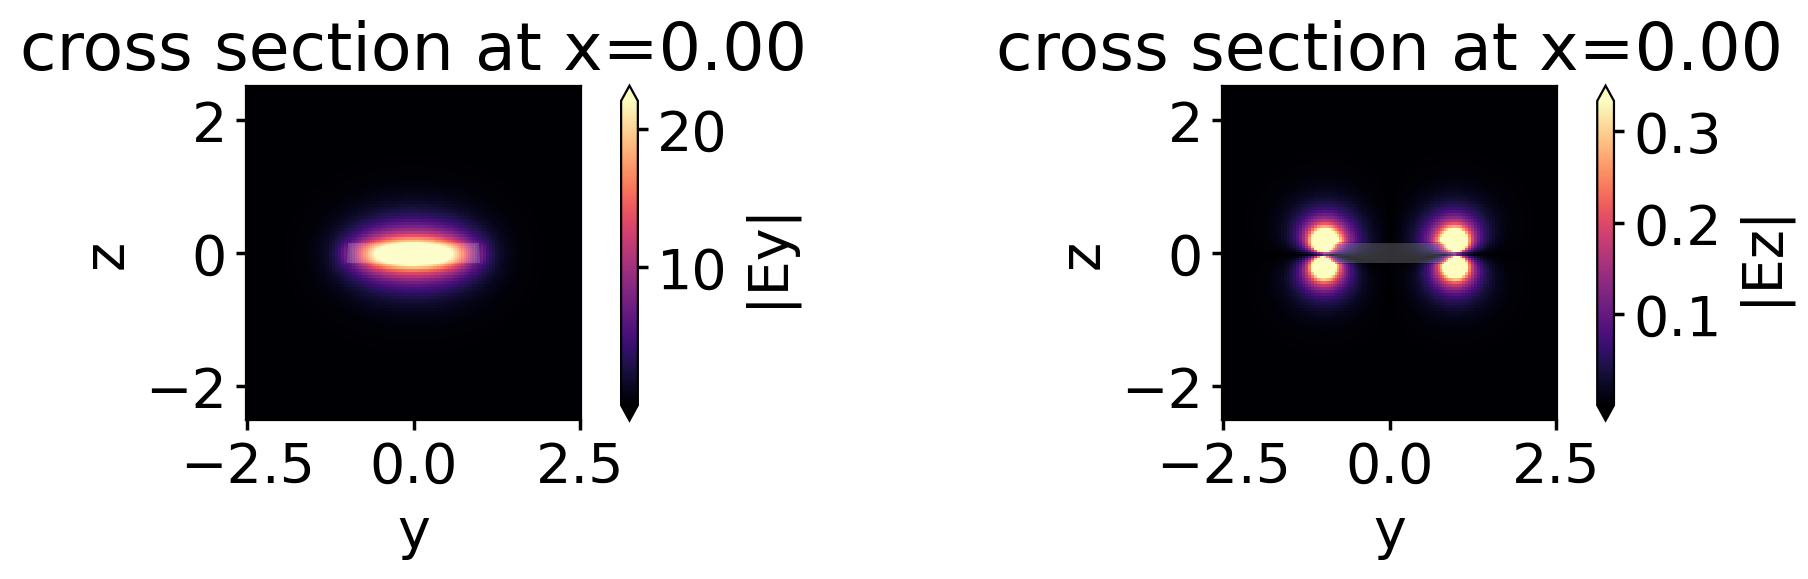

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
mode_solver.plot_field("Ey", "abs", mode_index=0, f=freq0, ax=ax1)
mode_solver.plot_field("Ez", "abs", mode_index=0, f=freq0, ax=ax2)
plt.show()


In [23]:
## Calculating the group index

fundamental_mode_data_df = mode_data_df[mode_data_df["wavelength"] == 1.31]
ng_freq0 = fundamental_mode_data_df["group index"].values[0]
ng_dfreq = (mode_data_df["group index"].values[-1] - mode_data_df["group index"].values[0])/2
neff_freq0 = fundamental_mode_data_df["n eff"].values[0]
neff_dfreq = (mode_data_df["n eff"].values[-1] - mode_data_df["n eff"].values[0])/2
print(ng_freq0, ng_dfreq, neff_freq0, neff_dfreq)

1.9451482 0.0015047192573547363 1.6716583 0.0019100308418273926


In [24]:
wg_height_spread, wg_width_spread, wg_sidewall_angle_spread = [], [], []

for i in tqdm(range(num_samples),desc = "variation sweep"):
  wg_height_spread.append(
    (1+np.random.normal(0, thickness_3sigma/3/wg_height)) * wg_height
  )
  wg_width_spread.append(
    (1+np.random.normal(0, width_3sigma/3/wg_width)) * wg_width
  )
  wg_sidewall_angle_spread.append(
    (1+np.random.normal(0,sidewall_angle_3sigma/3/wg_sidewall_angle)) * wg_sidewall_angle
  )

permutation_choice_width, permutation_choice_height, permutation_choice_sidewall_angle = np.random.permutation(num_samples), np.random.permutation(num_samples), np.random.permutation(num_samples)

variation sweep: 100%|██████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 432283.63it/s]


In [25]:
print(np.median(wg_sidewall_angle_spread), 3 *np.std(wg_sidewall_angle_spread), wg_sidewall_angle)
print(np.median(wg_height_spread), 3*np.std(wg_height_spread), wg_height)
print(np.median(wg_width_spread), 3*np.std(wg_width_spread),wg_width)


0.05190560362936314 0.03587425540412419 0.05235987755982996
0.29980600599643337 0.030373675473513738 0.3
1.9997084475333318 0.01996605478011722 2.0


## Width variation only

In [26]:
wg_width_choice, wg_height_choice, wg_sidewall_angle_choice = [], [], []
ng_freq0_spread = []
ng_dfreq_spread = []
neff_freq0_spread = []
neff_dfreq_spread = []


for i in tqdm(range(num_samples), desc="mode_simulations"):
  rand_wg_width_choice = wg_width_spread[permutation_choice_width[i]]
  # rand_wg_height_choice = wg_height_spread[permutation_choice_height[i]]
  # rand_wg_sidewall_angle_choice = wg_sidewall_angle_spread[permutation_choice_sidewall_angle[i]]
  rand_wg_height_choice = wg_height
  rand_wg_sidewall_angle_choice = wg_sidewall_angle

  wg_width_choice.append(rand_wg_width_choice)
  wg_height_choice.append(rand_wg_height_choice)
  wg_sidewall_angle_choice.append(rand_wg_sidewall_angle_choice)

  mode_solver, mode_data_df = mode_data_calculator(
      rand_wg_width_choice, 
      rand_wg_height_choice, 
      rand_wg_sidewall_angle_choice, 
      wg_n, wg_k, freqs, freq0, 
      Lx=Lx, Ly=Ly, Lz=Lz, dl=dl,
      min_steps_per_wvl=min_steps_per_wvl
  )

  fundamental_mode_data_df = mode_data_df[mode_data_df["wavelength"] == 1.31]
  ng_freq0 = fundamental_mode_data_df["group index"].values[0]
  ng_dfreq = (mode_data_df["group index"].values[-1] -
              mode_data_df["group index"].values[0])/2
  neff_freq0 = fundamental_mode_data_df["n eff"].values[0]
  neff_dfreq = (mode_data_df["n eff"].values[-1] -
                mode_data_df["n eff"].values[0])/2
  
  ng_freq0_spread.append(ng_freq0)
  ng_dfreq_spread.append(ng_dfreq)
  neff_freq0_spread.append(neff_freq0)
  neff_dfreq_spread.append(neff_dfreq)

rand_wg_width_dataset = pd.DataFrame(data=wg_width_choice)
rand_wg_width_dataset.columns = ['wg_width (nm)']
rand_wg_width_dataset['wg_height (nm)']=wg_height_choice
rand_wg_width_dataset['wg_sidewall_angle (rad)'] = wg_sidewall_angle_choice
rand_wg_width_dataset['rand_wg_width'] = True
rand_wg_width_dataset['rand_wg_height'] = False
rand_wg_width_dataset['rand_wg_sidewall_angle'] = False
rand_wg_width_dataset['neff_freq0'] = neff_freq0_spread
rand_wg_width_dataset['neff_dfreq'] = neff_dfreq_spread
rand_wg_width_dataset['ng_freq0'] = ng_freq0_spread
rand_wg_width_dataset['ng_dfreq'] = ng_dfreq_spread
rand_wg_width_dataset['freq0 (Hz)']=freq0
rand_wg_width_dataset['freq_lo (Hz)'] = freqs[0]
rand_wg_width_dataset['freq_hi (Hz)'] = freqs[-1]

gf45clo_pdk_sin_neff_ng_variability = pd.concat([gf45clo_pdk_sin_neff_ng_variability, rand_wg_width_dataset])

gf45clo_pdk_sin_neff_ng_variability.to_csv("gf45clo_pdk_sin_neff_ng_variability.csv")

mode_simulations: 100%|███████████████████████████████████████████████████████████████████████████| 1500/1500 [1:21:41<00:00,  3.27s/it]


Text(0.5, 1.0, 'Median = 87.00 deg, 1-sigma = 0.00 deg')

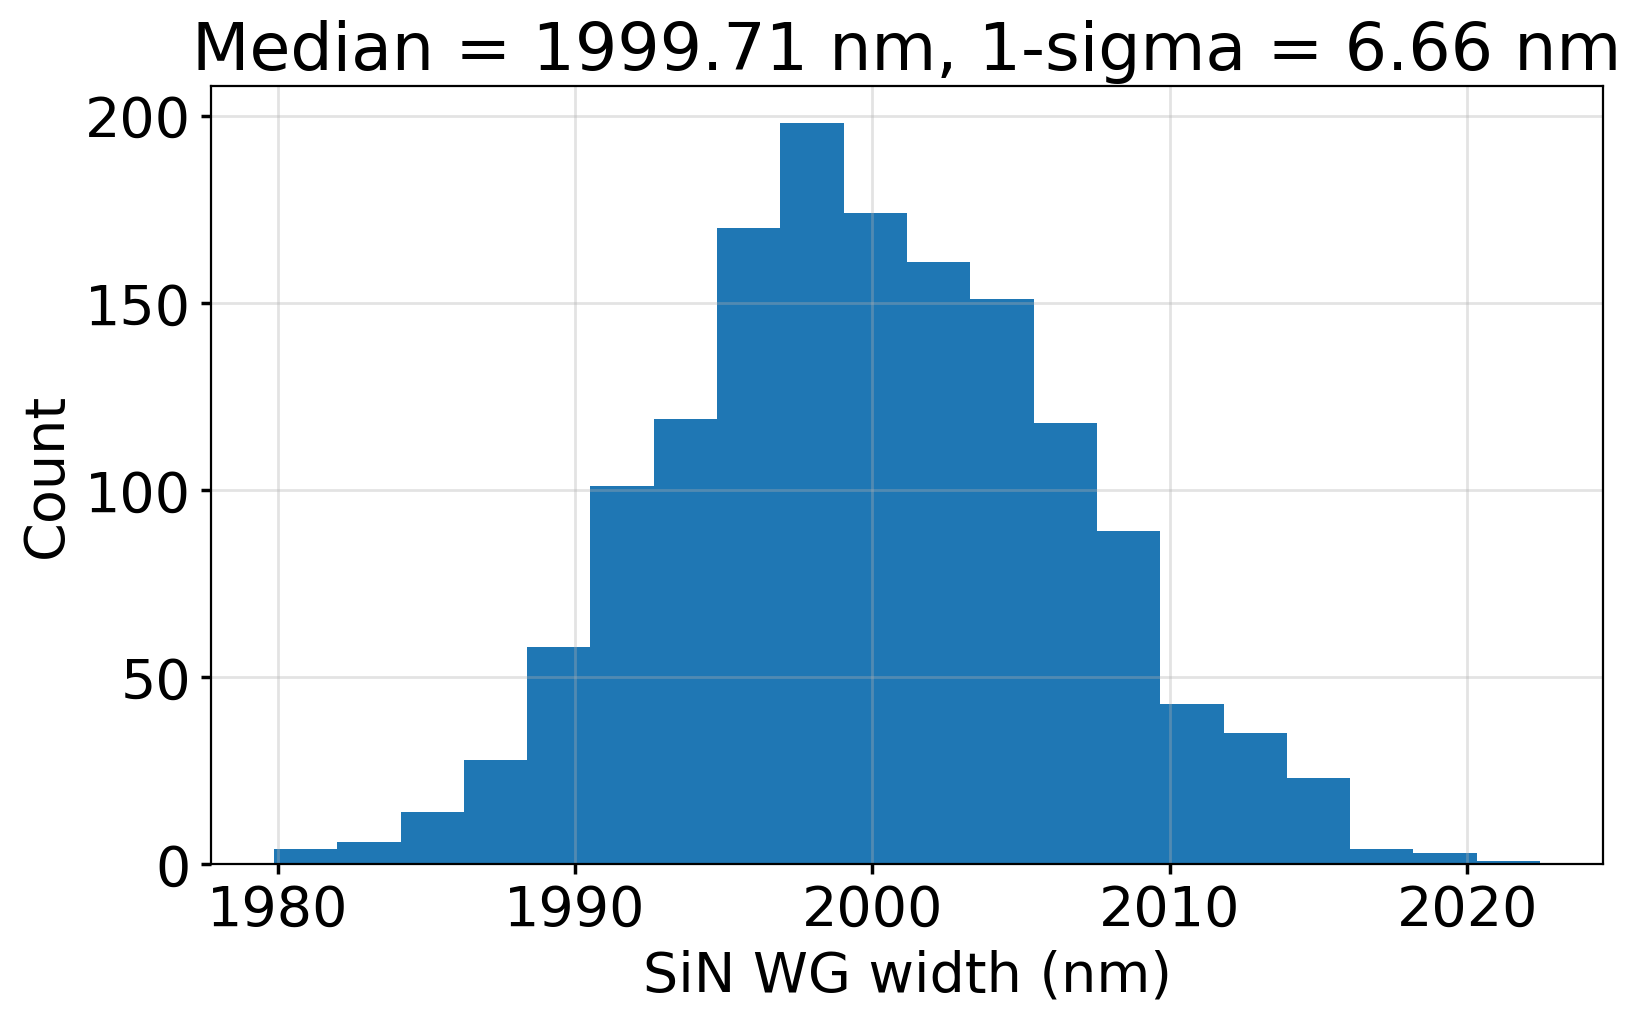

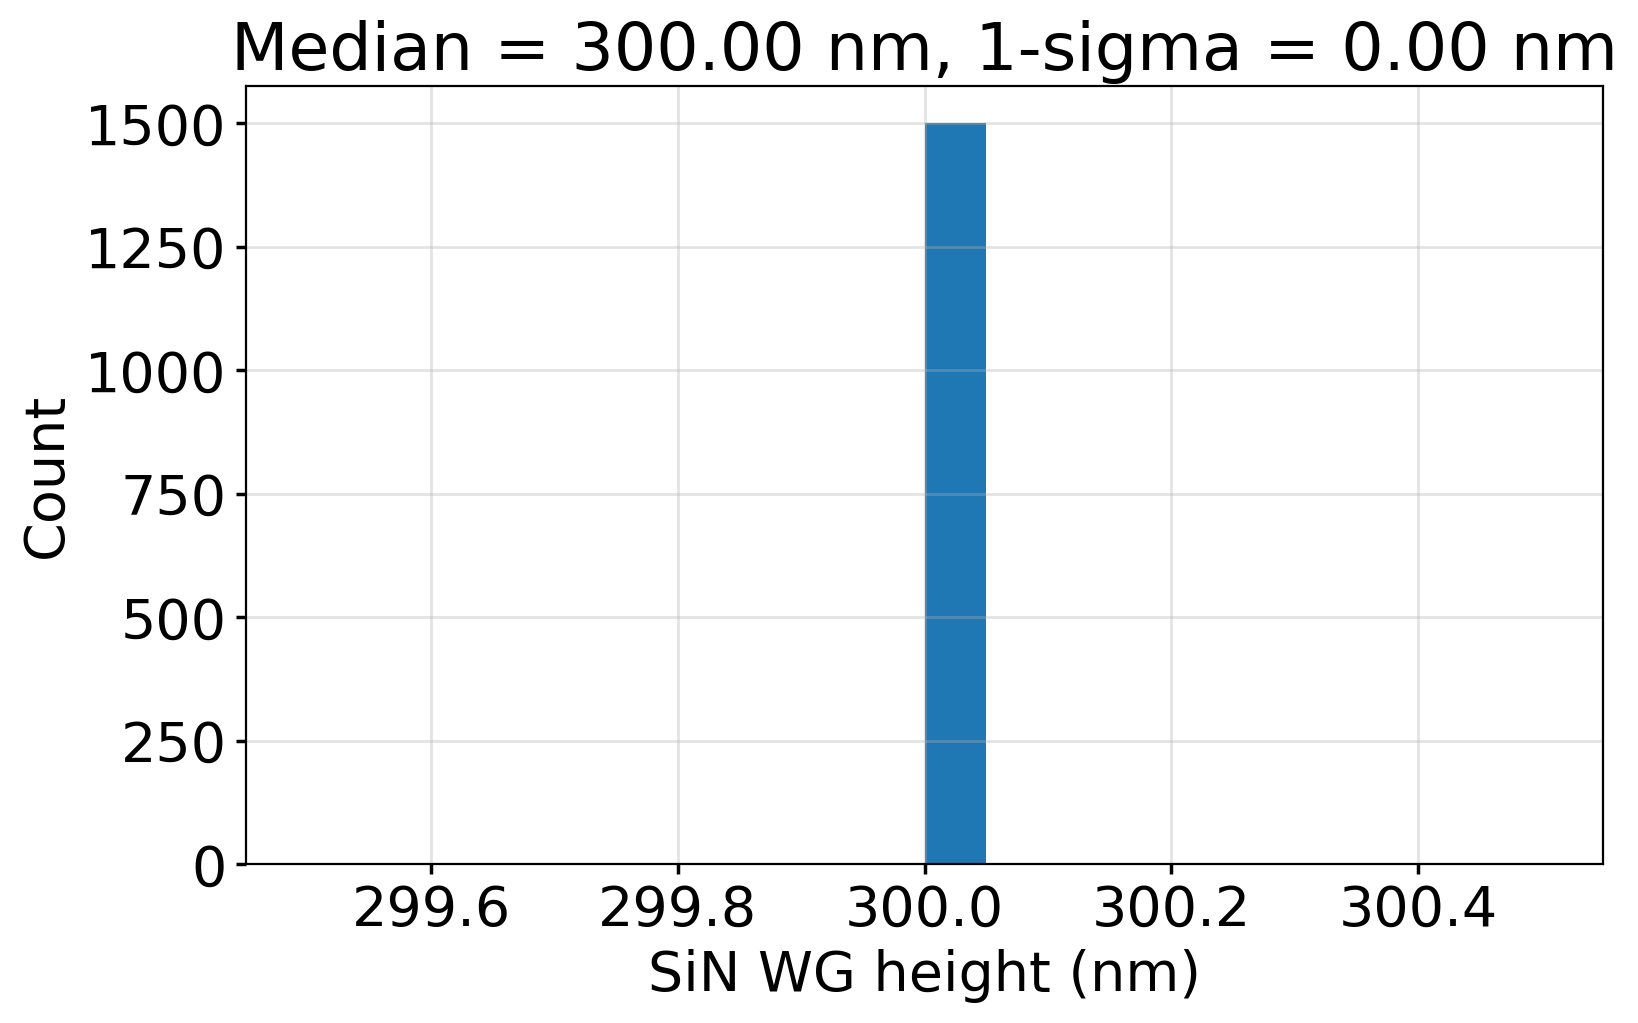

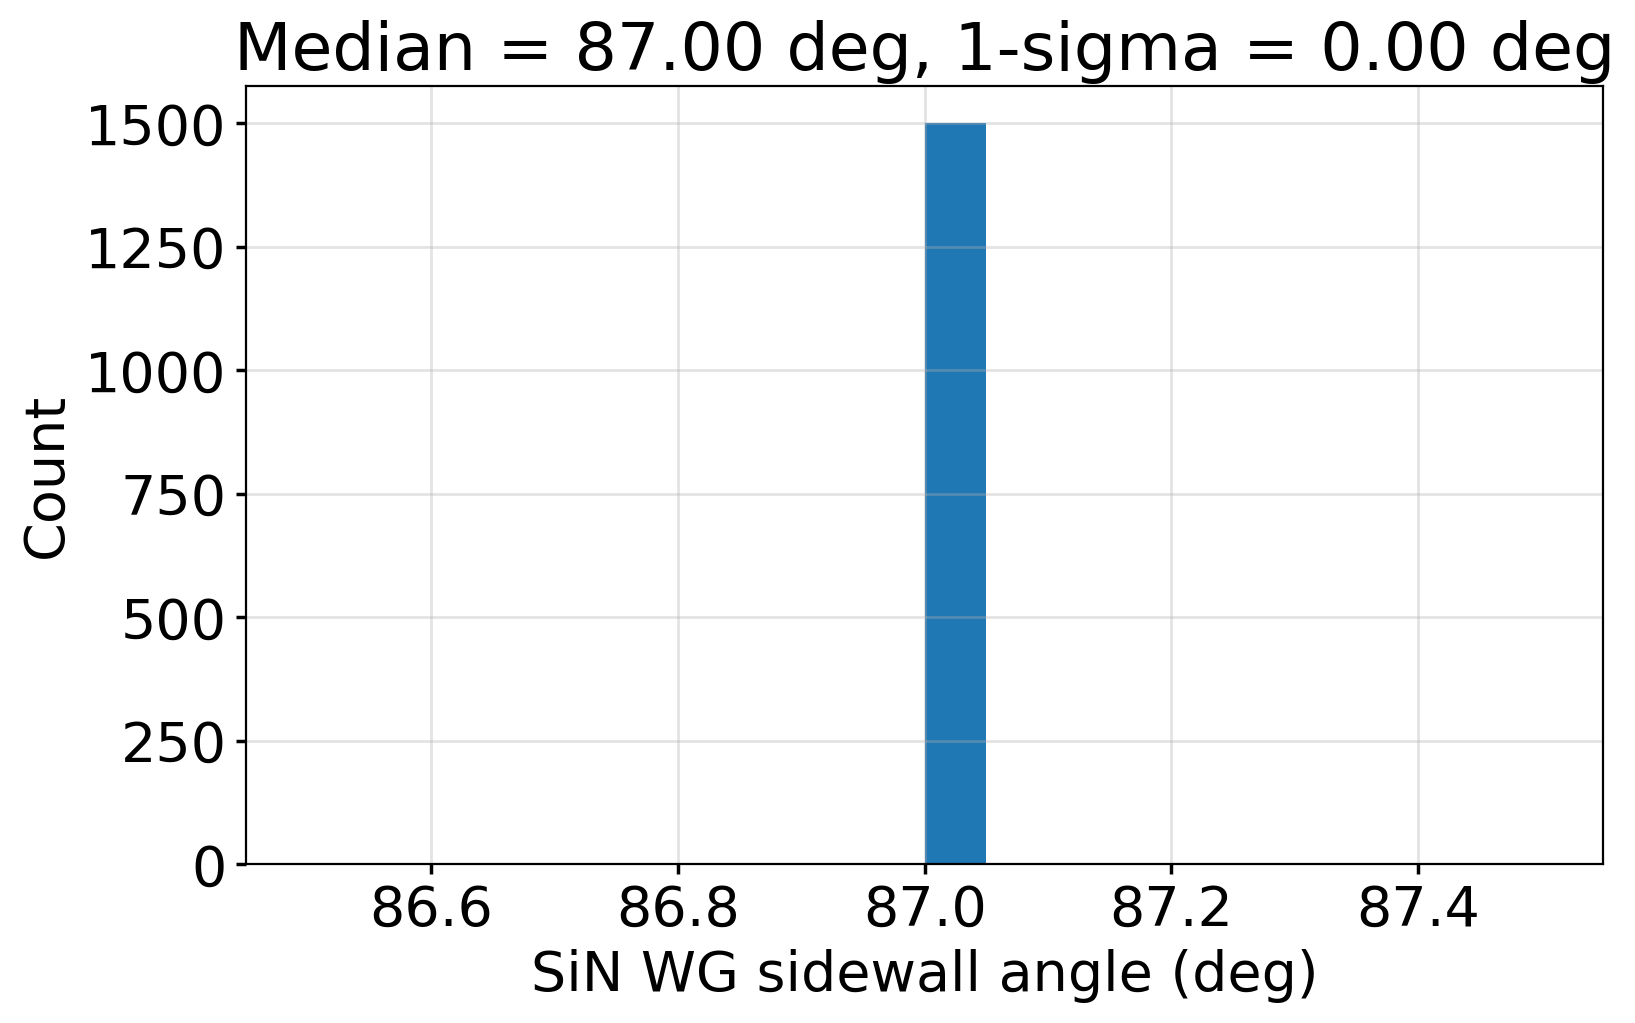

In [27]:
plt.figure()
plt.hist(rand_wg_width_dataset["wg_width (nm)"]*1000, bins=20)
plt.grid(True)
plt.xlabel('SiN WG width (nm)')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_width_dataset["wg_width (nm)"]*1000):0.2f} nm, 1-sigma = {np.std(rand_wg_width_dataset["wg_width (nm)"]*1000):0.2f} nm')

plt.figure()
plt.hist(rand_wg_width_dataset["wg_height (nm)"]*1000, bins=20)
plt.grid(True)
plt.xlabel('SiN WG height (nm)')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_width_dataset["wg_height (nm)"]*1000):0.2f} nm, 1-sigma = {np.std(rand_wg_width_dataset["wg_height (nm)"]*1000):0.2f} nm')

plt.figure()
plt.hist(
    90-rand_wg_width_dataset["wg_sidewall_angle (rad)"].values/np.pi*180, bins=20)
plt.grid(True)
plt.xlabel('SiN WG sidewall angle (deg)')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(90-rand_wg_width_dataset["wg_sidewall_angle (rad)"].values/np.pi*180):0.2f} deg, 1-sigma = {np.std(90-rand_wg_width_dataset["wg_sidewall_angle (rad)"].values/np.pi*180):0.2f} deg')


Text(0.5, 1.0, 'Median = 1.9448, 1-sigma = 0.0002')

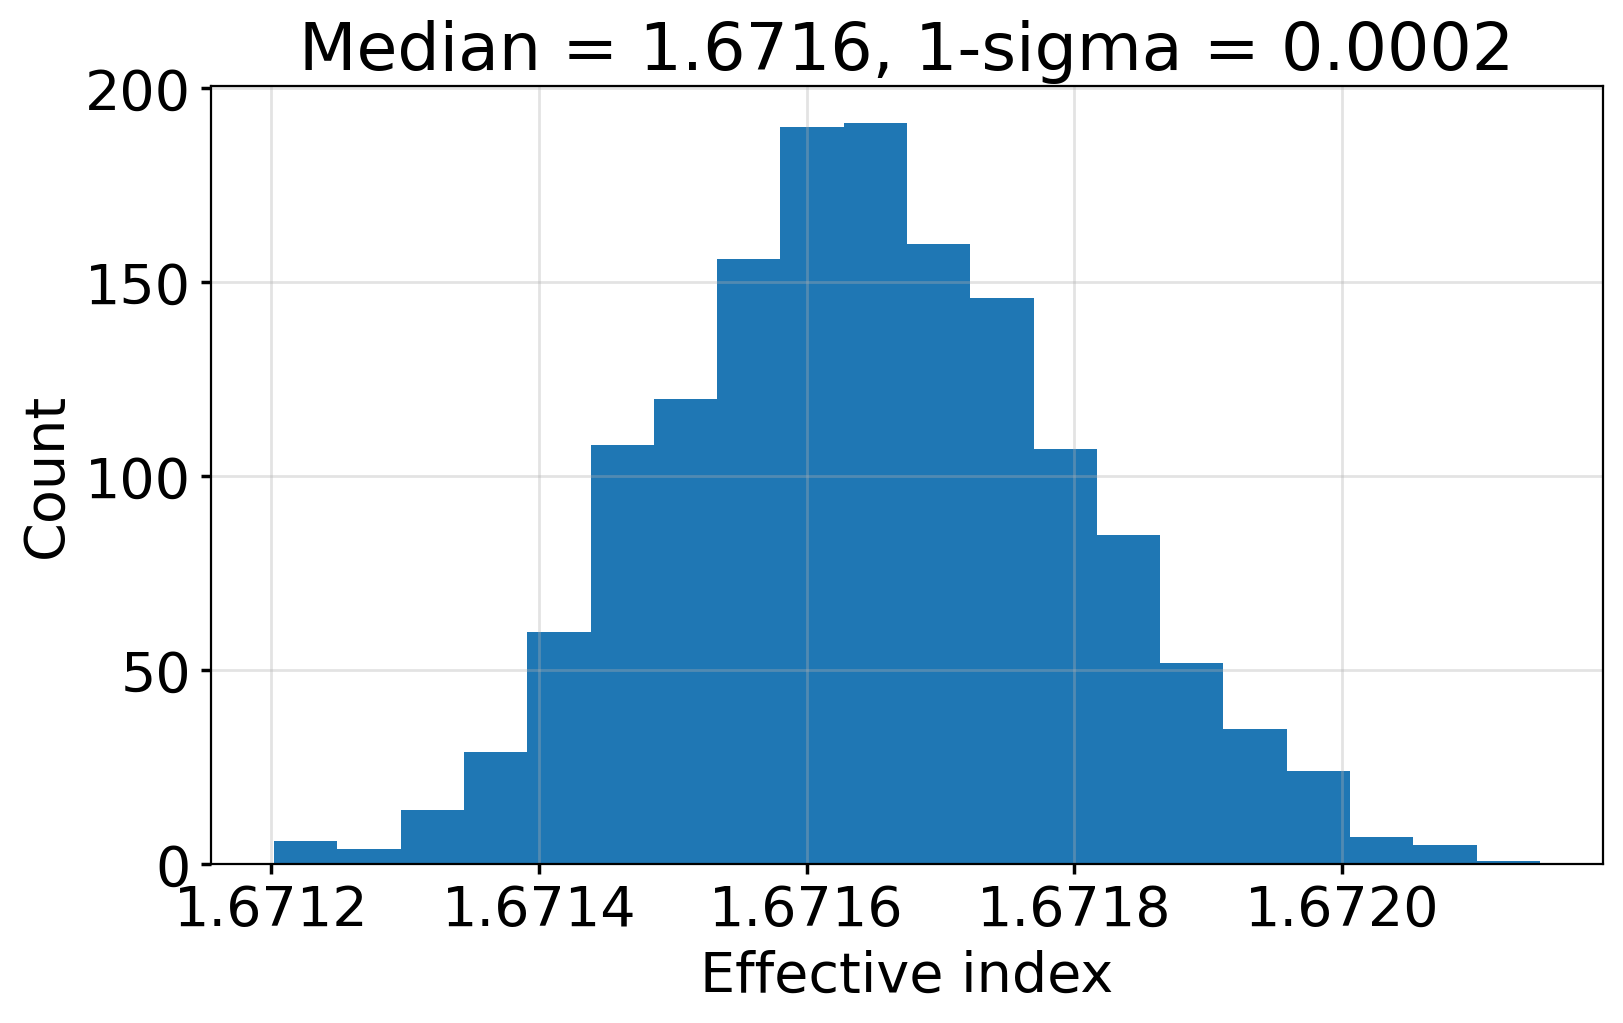

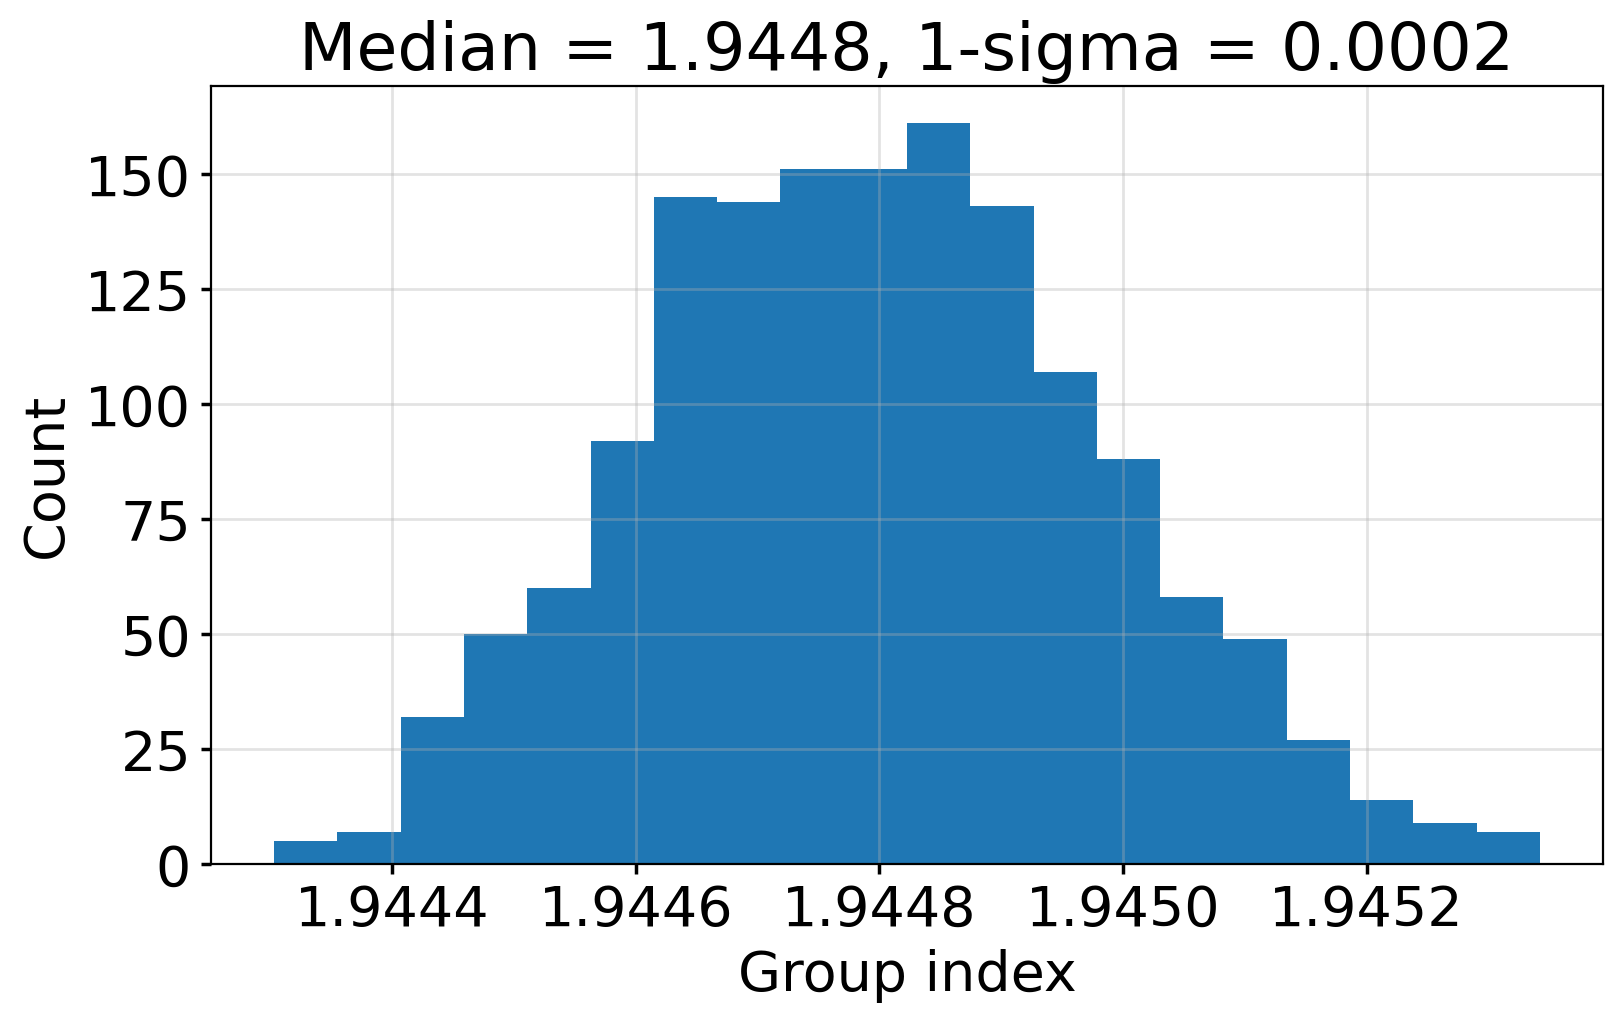

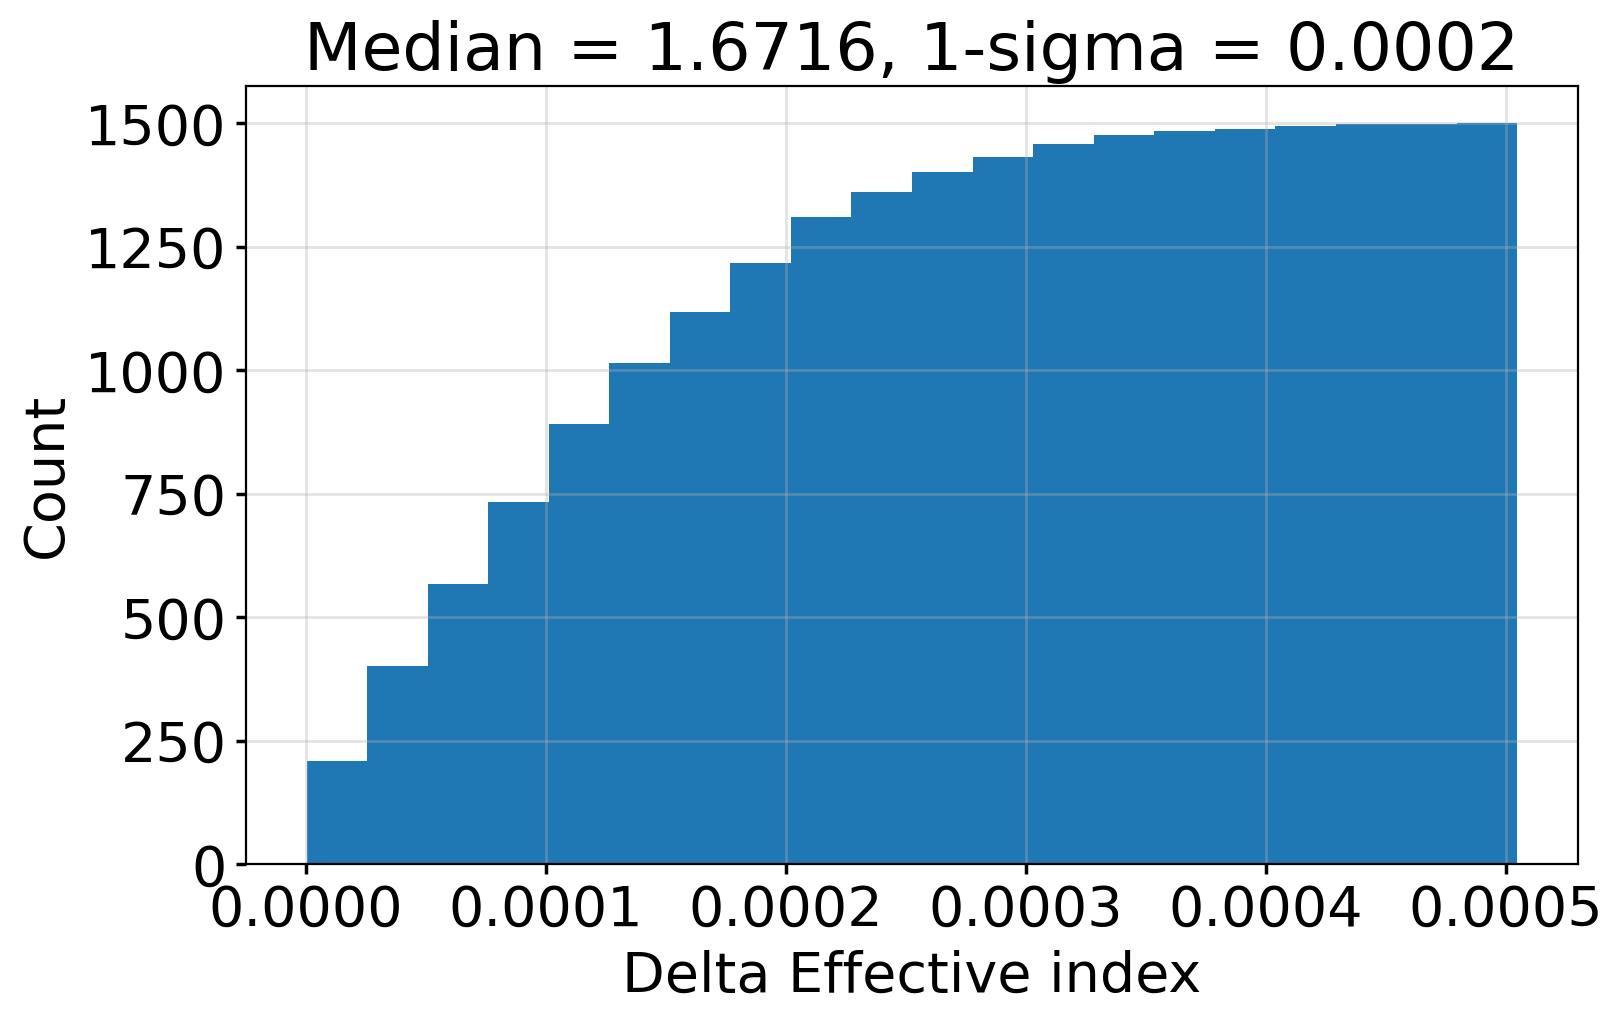

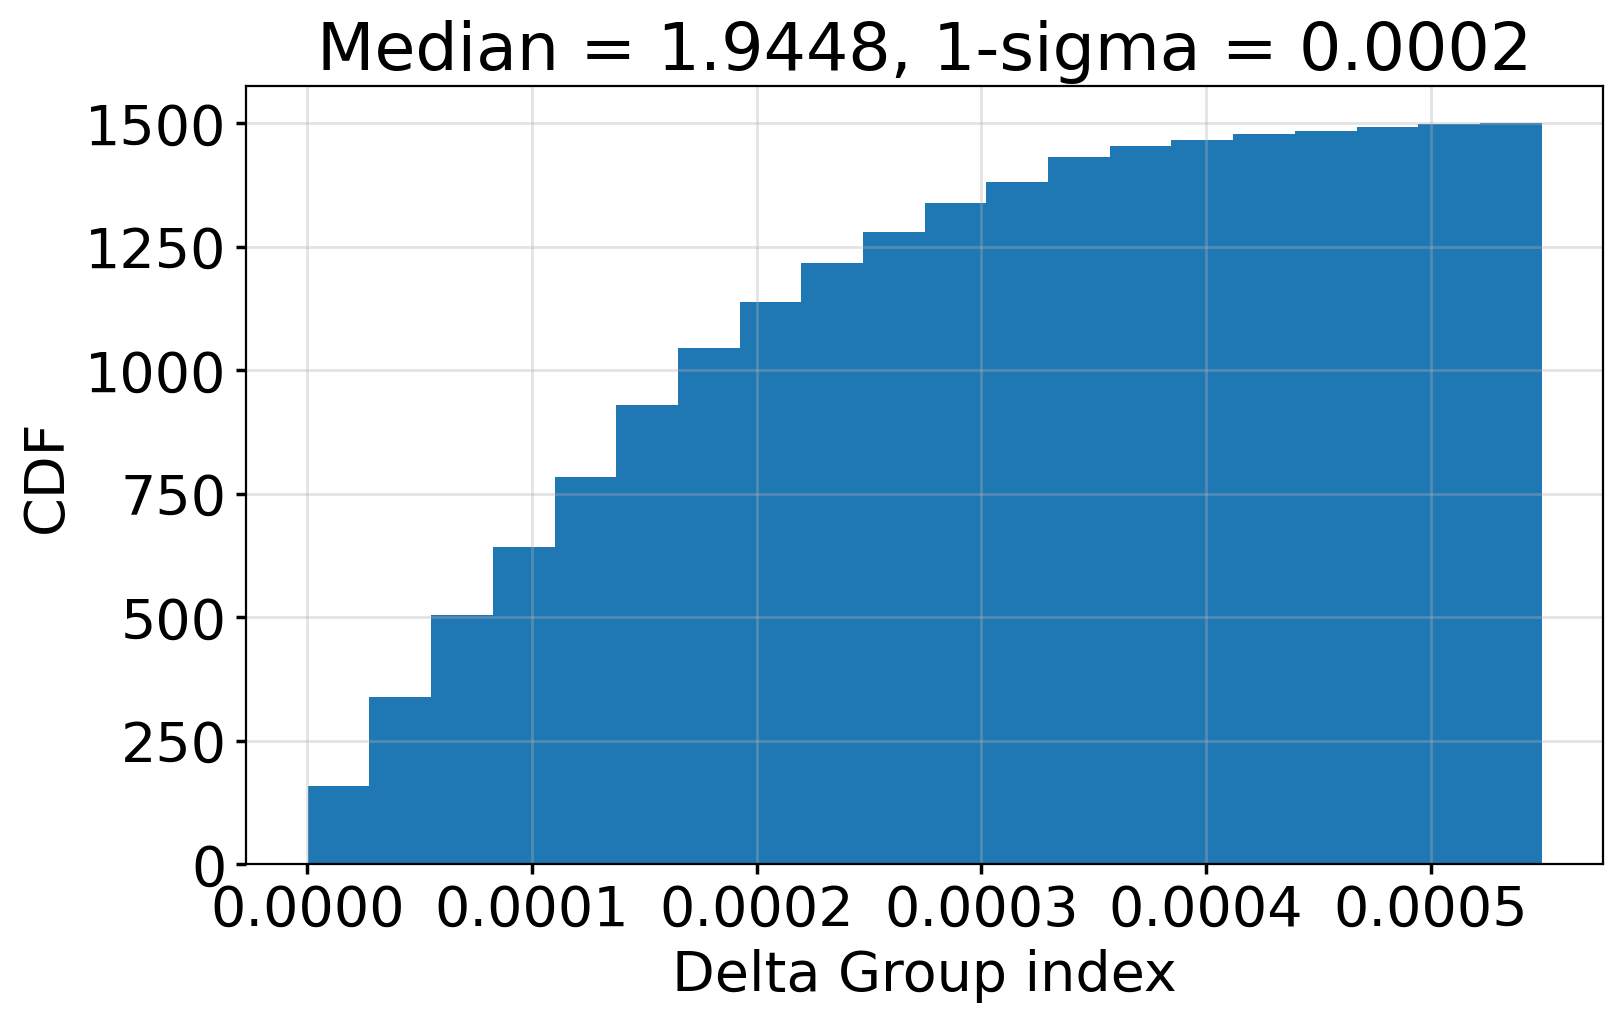

In [28]:
plt.figure()
plt.hist(rand_wg_width_dataset["neff_freq0"], bins=20)
plt.grid(True)
plt.xlabel('Effective index')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_width_dataset["neff_freq0"]):0.4f}, 1-sigma = {np.std(rand_wg_width_dataset["neff_freq0"]):0.4f}')

plt.figure()
plt.hist(rand_wg_width_dataset["ng_freq0"], bins=20)
plt.grid(True)
plt.xlabel('Group index')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_width_dataset["ng_freq0"]):0.4f}, 1-sigma = {np.std(rand_wg_width_dataset["ng_freq0"]):0.4f}')

plt.figure()
plt.hist(np.abs(rand_wg_width_dataset["neff_freq0"]-np.median(rand_wg_width_dataset["neff_freq0"])), bins=20, cumulative = True)
plt.grid(True)
plt.xlabel('Delta Effective index')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_width_dataset["neff_freq0"]):0.4f}, 1-sigma = {np.std(rand_wg_width_dataset["neff_freq0"]):0.4f}')

plt.figure()
plt.hist(np.abs(rand_wg_width_dataset["ng_freq0"]-np.median(rand_wg_width_dataset["ng_freq0"])), bins=20, cumulative = True)
plt.grid(True)
plt.xlabel('Delta Group index')
plt.ylabel('CDF')
plt.title(
    f'Median = {np.median(rand_wg_width_dataset["ng_freq0"]):0.4f}, 1-sigma = {np.std(rand_wg_width_dataset["ng_freq0"]):0.4f}')



## Sidewall angle variation only

In [29]:
wg_width_choice, wg_height_choice, wg_sidewall_angle_choice = [], [], []
ng_freq0_spread = []
ng_dfreq_spread = []
neff_freq0_spread = []
neff_dfreq_spread = []

for i in tqdm(range(num_samples), desc="mode_simulations"):
  # rand_wg_width_choice = wg_width_spread[permutation_choice_width[i]]
  rand_wg_width_choice = wg_width
  # rand_wg_height_choice = wg_height_spread[permutation_choice_height[i]]
  rand_wg_sidewall_angle_choice = wg_sidewall_angle_spread[permutation_choice_sidewall_angle[i]]
  rand_wg_height_choice = wg_height
  # rand_wg_sidewall_anle_choice = wg_sidewall_angle

  wg_width_choice.append(rand_wg_width_choice)
  wg_height_choice.append(rand_wg_height_choice)
  wg_sidewall_angle_choice.append(rand_wg_sidewall_angle_choice)

  mode_solver, mode_data_df = mode_data_calculator(
      rand_wg_width_choice, 
      rand_wg_height_choice, 
      rand_wg_sidewall_angle_choice, 
      wg_n, wg_k, freqs, freq0, 
      Lx=Lx, Ly=Ly, Lz=Lz, dl=dl,
      min_steps_per_wvl=min_steps_per_wvl
  )

  fundamental_mode_data_df = mode_data_df[mode_data_df["wavelength"] == 1.31]
  ng_freq0 = fundamental_mode_data_df["group index"].values[0]
  ng_dfreq = (mode_data_df["group index"].values[-1] -
              mode_data_df["group index"].values[0])/2
  neff_freq0 = fundamental_mode_data_df["n eff"].values[0]
  neff_dfreq = (mode_data_df["n eff"].values[-1] -
                mode_data_df["n eff"].values[0])/2
  
  ng_freq0_spread.append(ng_freq0)
  ng_dfreq_spread.append(ng_dfreq)
  neff_freq0_spread.append(neff_freq0)
  neff_dfreq_spread.append(neff_dfreq)

rand_wg_sidewall_angle_dataset = pd.DataFrame(data=wg_width_choice)
rand_wg_sidewall_angle_dataset.columns = ['wg_width (nm)']
rand_wg_sidewall_angle_dataset['wg_height (nm)']=wg_height_choice
rand_wg_sidewall_angle_dataset['wg_sidewall_angle (rad)'] = wg_sidewall_angle_choice
rand_wg_sidewall_angle_dataset['rand_wg_width'] = False
rand_wg_sidewall_angle_dataset['rand_wg_height'] = False
rand_wg_sidewall_angle_dataset['rand_wg_sidewall_angle'] = True
rand_wg_sidewall_angle_dataset['neff_freq0'] = neff_freq0_spread
rand_wg_sidewall_angle_dataset['neff_dfreq'] = neff_dfreq_spread
rand_wg_sidewall_angle_dataset['ng_freq0'] = ng_freq0_spread
rand_wg_sidewall_angle_dataset['ng_dfreq'] = ng_dfreq_spread
rand_wg_sidewall_angle_dataset['freq0 (Hz)']=freq0
rand_wg_sidewall_angle_dataset['freq_lo (Hz)'] = freqs[0]
rand_wg_sidewall_angle_dataset['freq_hi (Hz)'] = freqs[-1]


gf45clo_pdk_sin_neff_ng_variability = pd.concat([gf45clo_pdk_sin_neff_ng_variability, rand_wg_sidewall_angle_dataset])
gf45clo_pdk_sin_neff_ng_variability.to_csv("gf45clo_pdk_sin_neff_ng_variability.csv")

mode_simulations: 100%|███████████████████████████████████████████████████████████████████████████| 1500/1500 [1:23:30<00:00,  3.34s/it]


Text(0.5, 1.0, 'Median = 87.03 deg, 1-sigma = 0.69 deg')

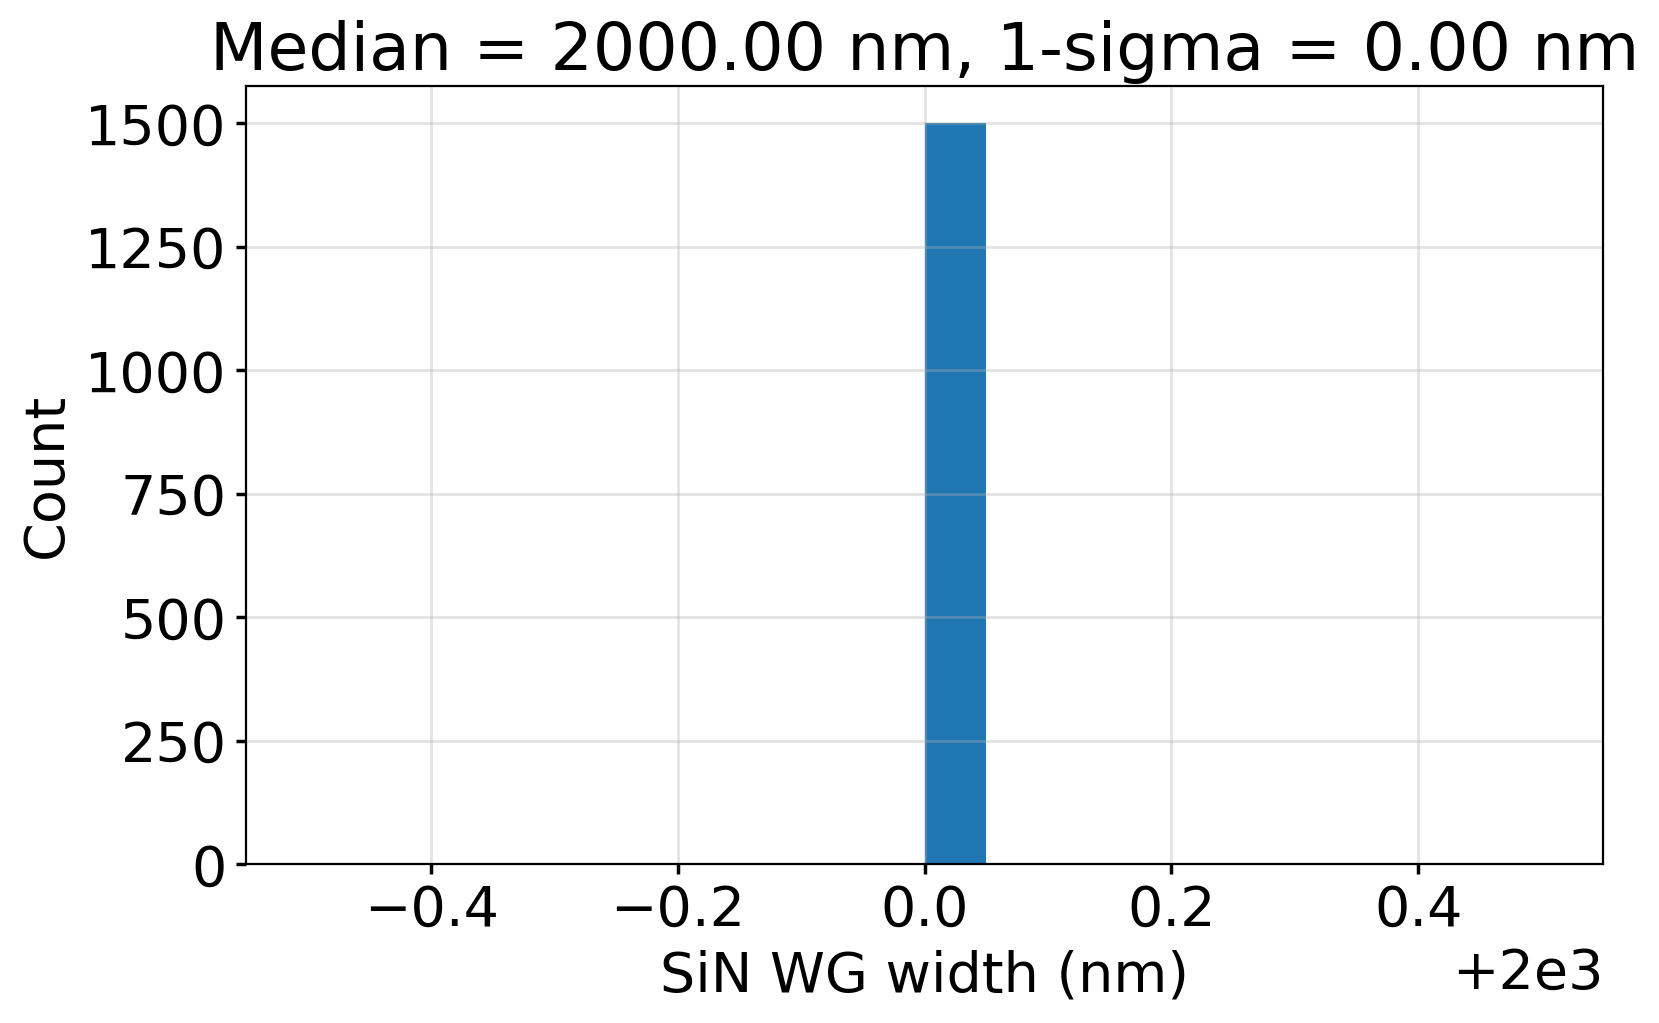

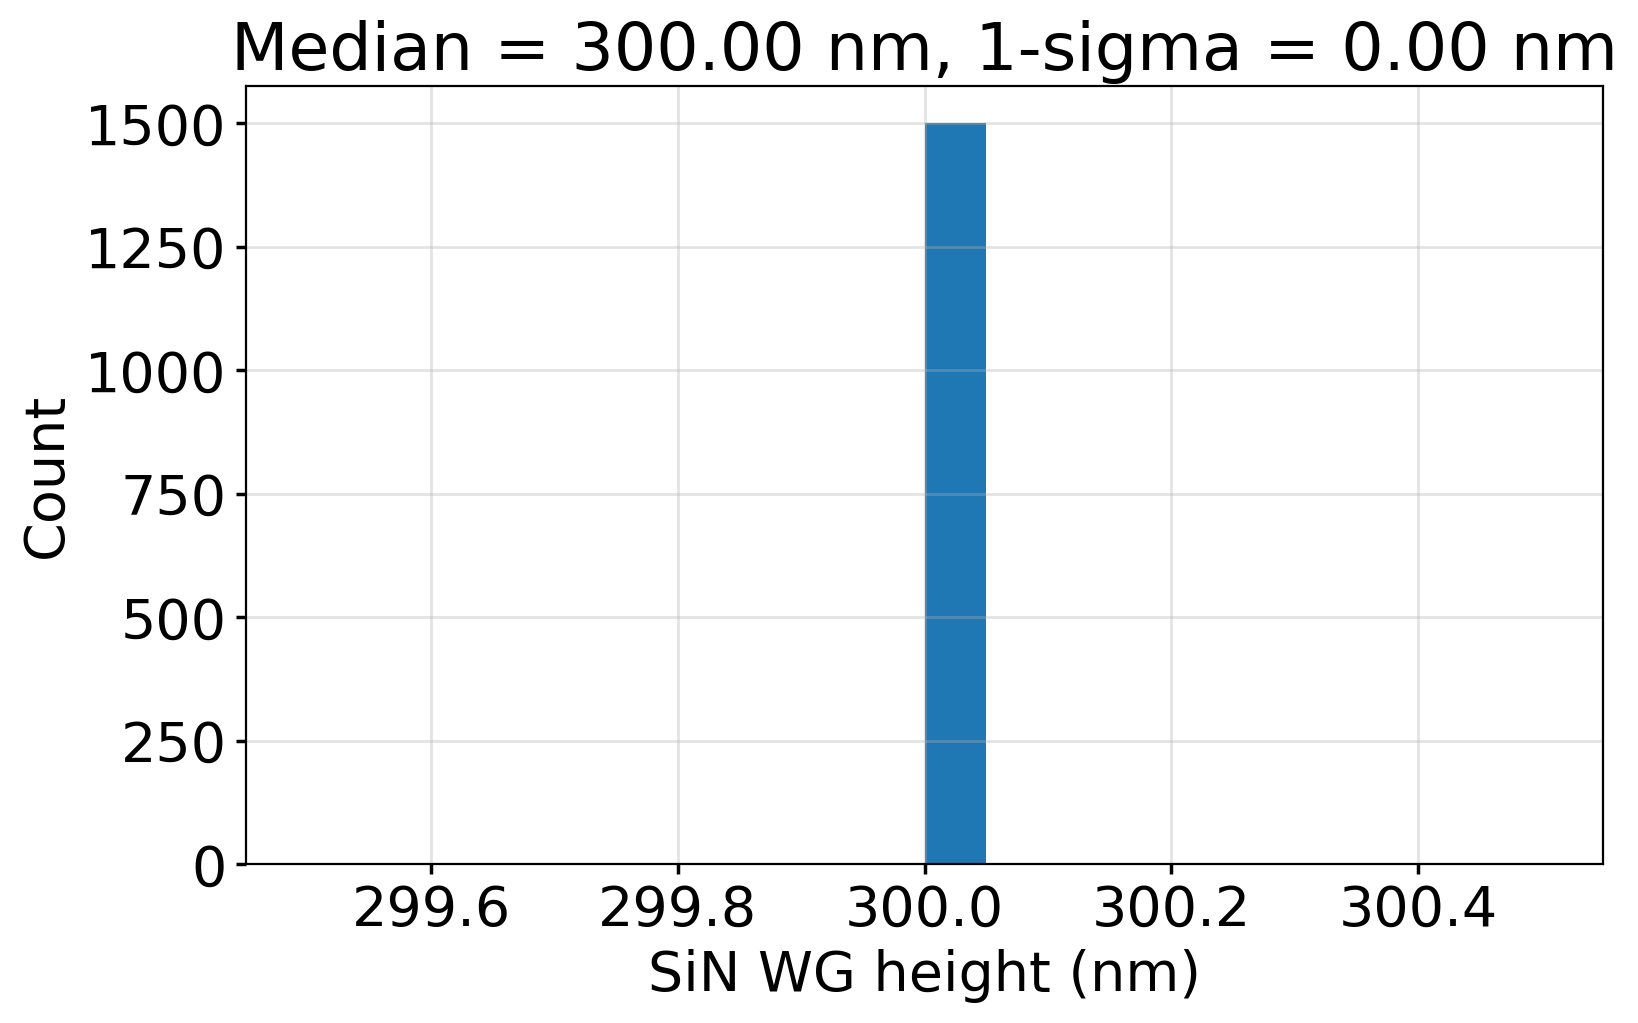

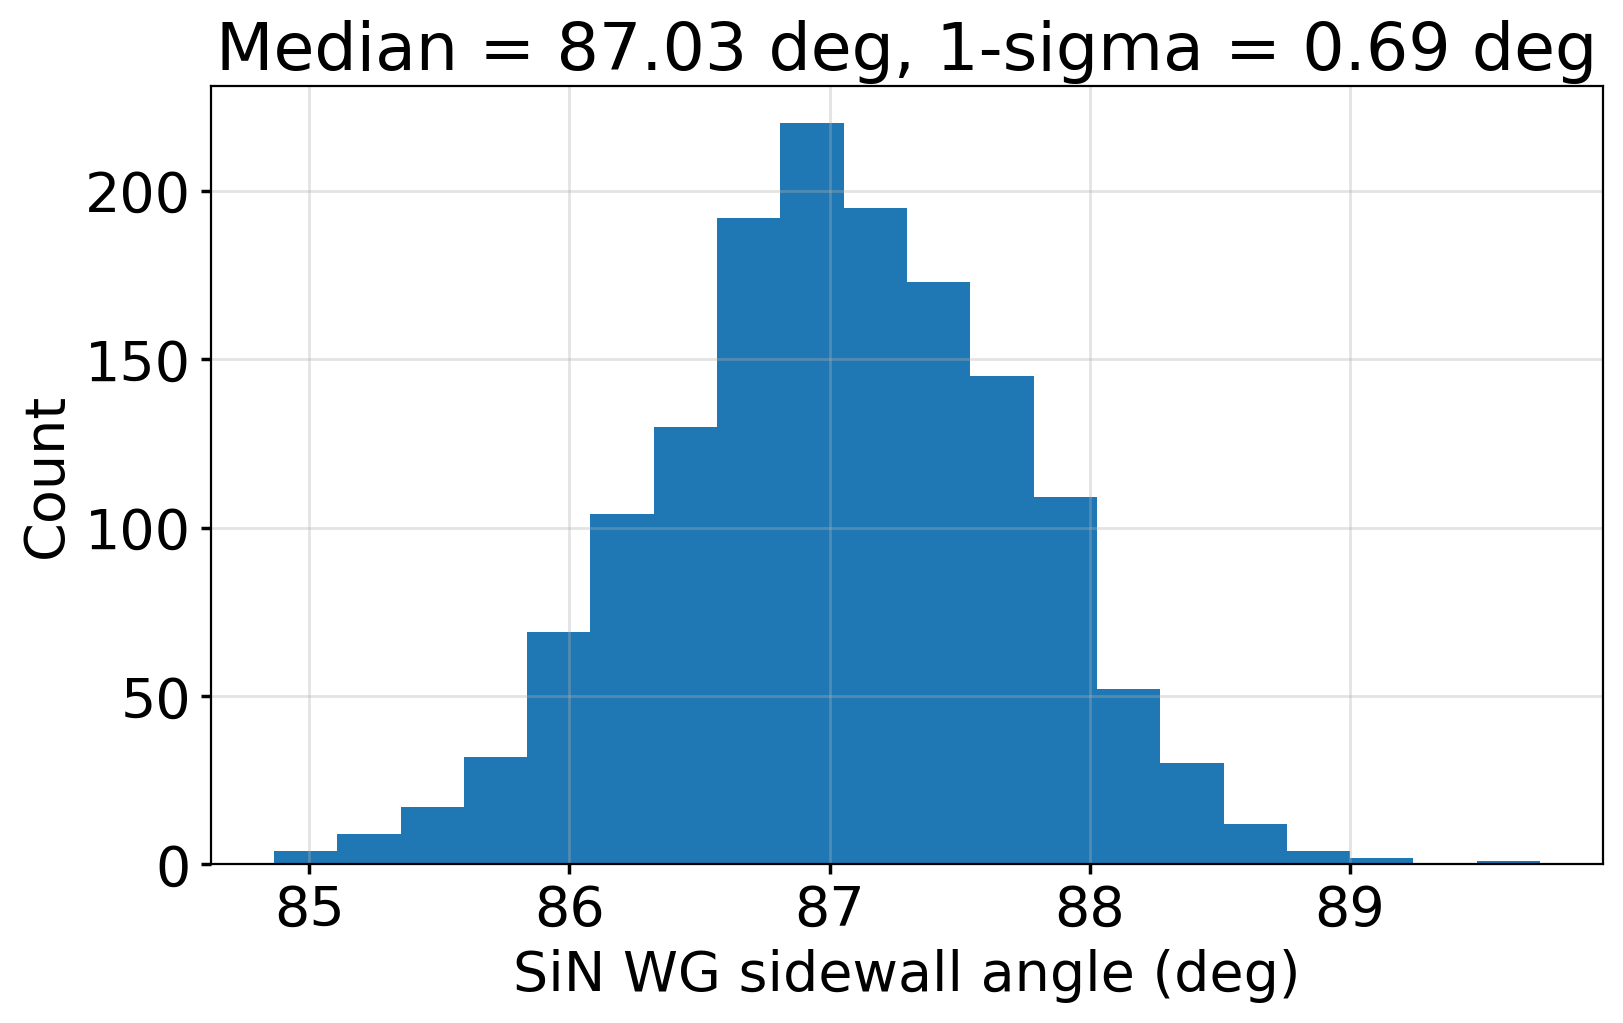

In [30]:
plt.figure()
plt.hist(rand_wg_sidewall_angle_dataset["wg_width (nm)"]*1000, bins=20)
plt.grid(True)
plt.xlabel('SiN WG width (nm)')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_sidewall_angle_dataset["wg_width (nm)"]*1000):0.2f} nm, 1-sigma = {np.std(rand_wg_sidewall_angle_dataset["wg_width (nm)"]*1000):0.2f} nm')

plt.figure()
plt.hist(rand_wg_sidewall_angle_dataset["wg_height (nm)"]*1000, bins=20)
plt.grid(True)
plt.xlabel('SiN WG height (nm)')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_sidewall_angle_dataset["wg_height (nm)"]*1000):0.2f} nm, 1-sigma = {np.std(rand_wg_sidewall_angle_dataset["wg_height (nm)"]*1000):0.2f} nm')

plt.figure()
plt.hist(
    90-rand_wg_sidewall_angle_dataset["wg_sidewall_angle (rad)"].values/np.pi*180, bins=20)
plt.grid(True)
plt.xlabel('SiN WG sidewall angle (deg)')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(90-rand_wg_sidewall_angle_dataset["wg_sidewall_angle (rad)"].values/np.pi*180):0.2f} deg, 1-sigma = {np.std(90-rand_wg_sidewall_angle_dataset["wg_sidewall_angle (rad)"].values/np.pi*180):0.2f} deg')


Text(0.5, 1.0, 'Median = 1.9451, 1-sigma = 0.0001')

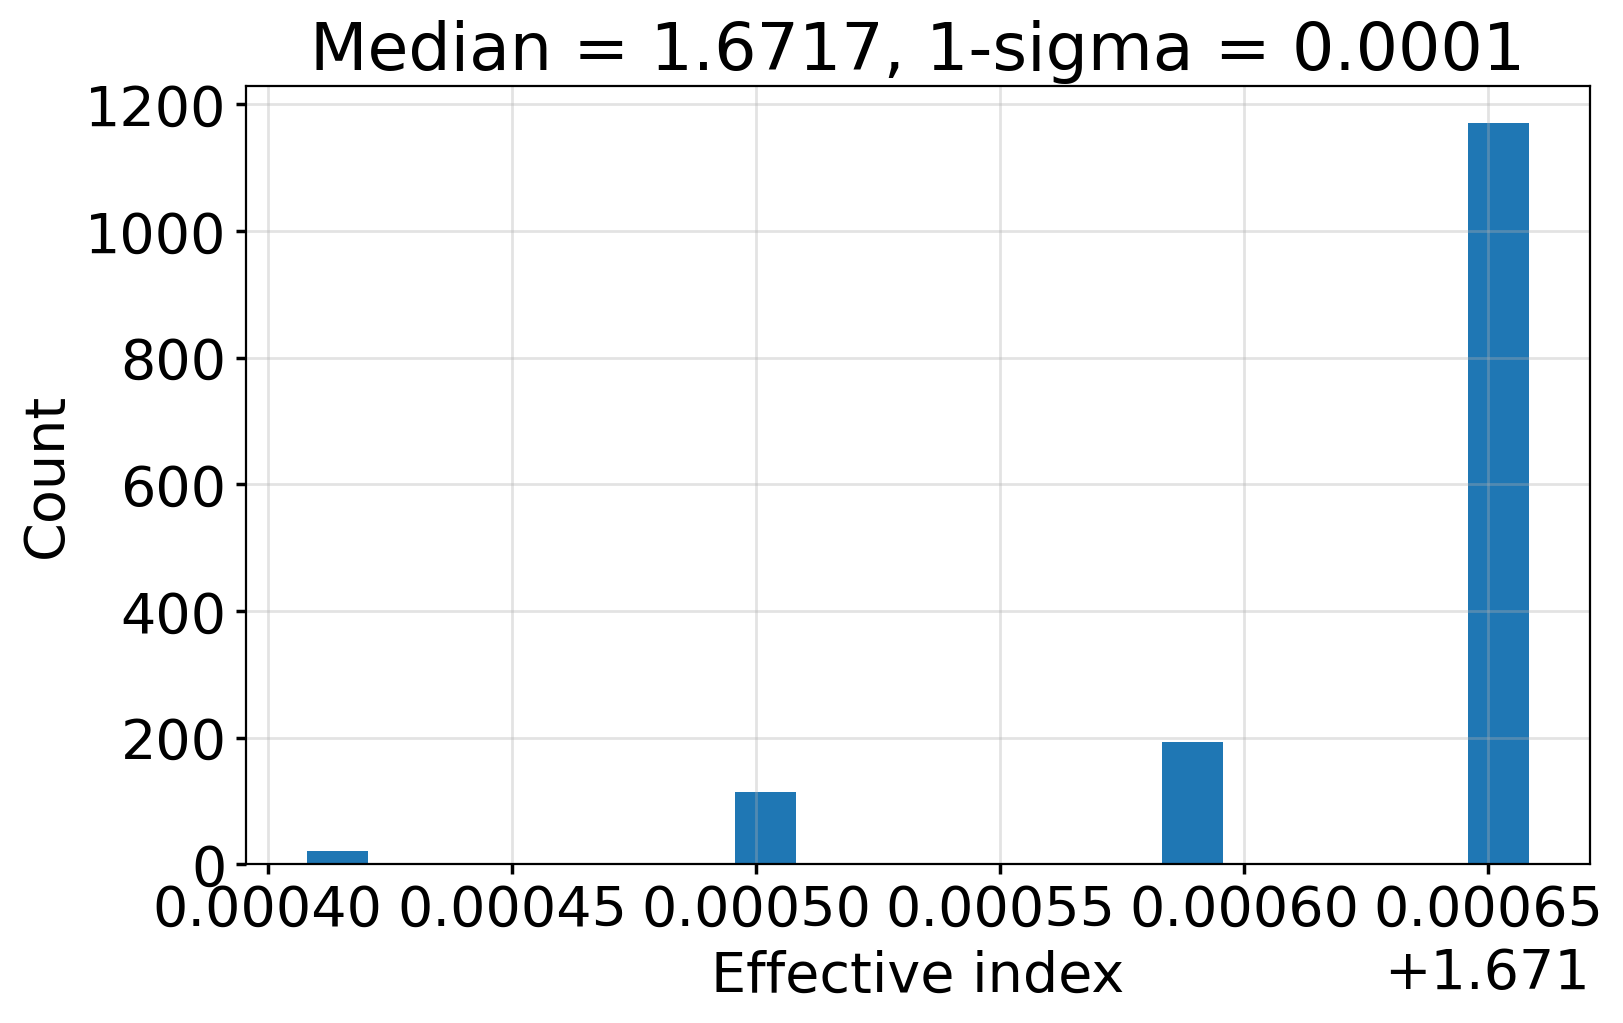

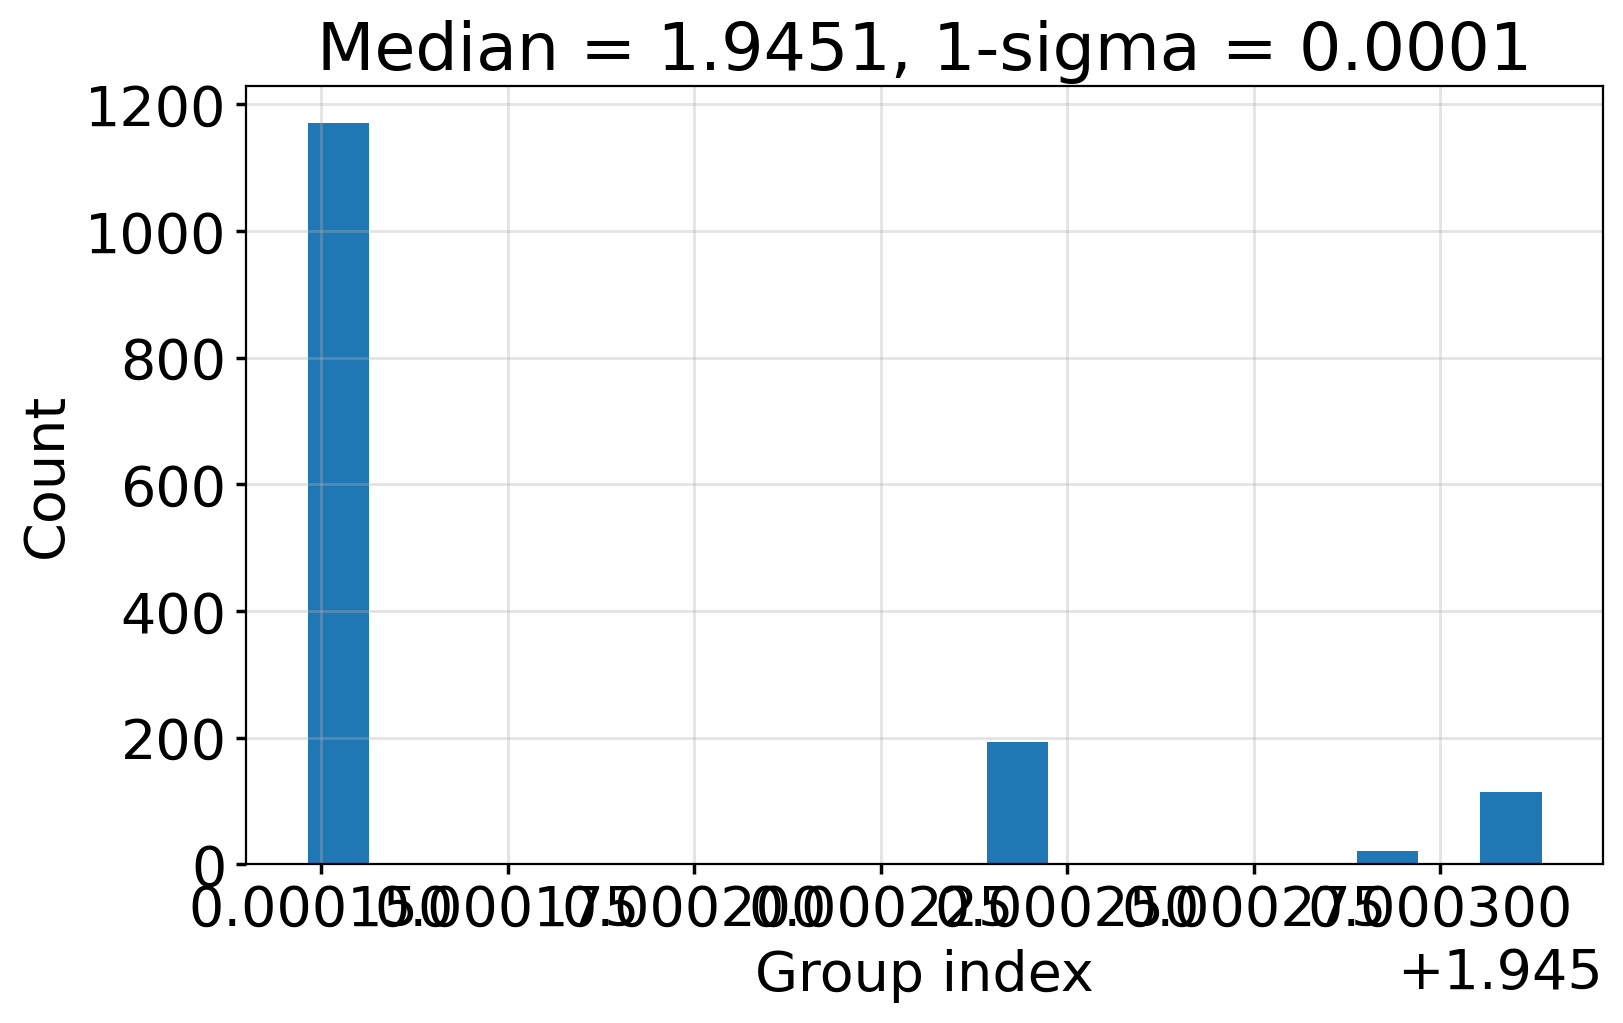

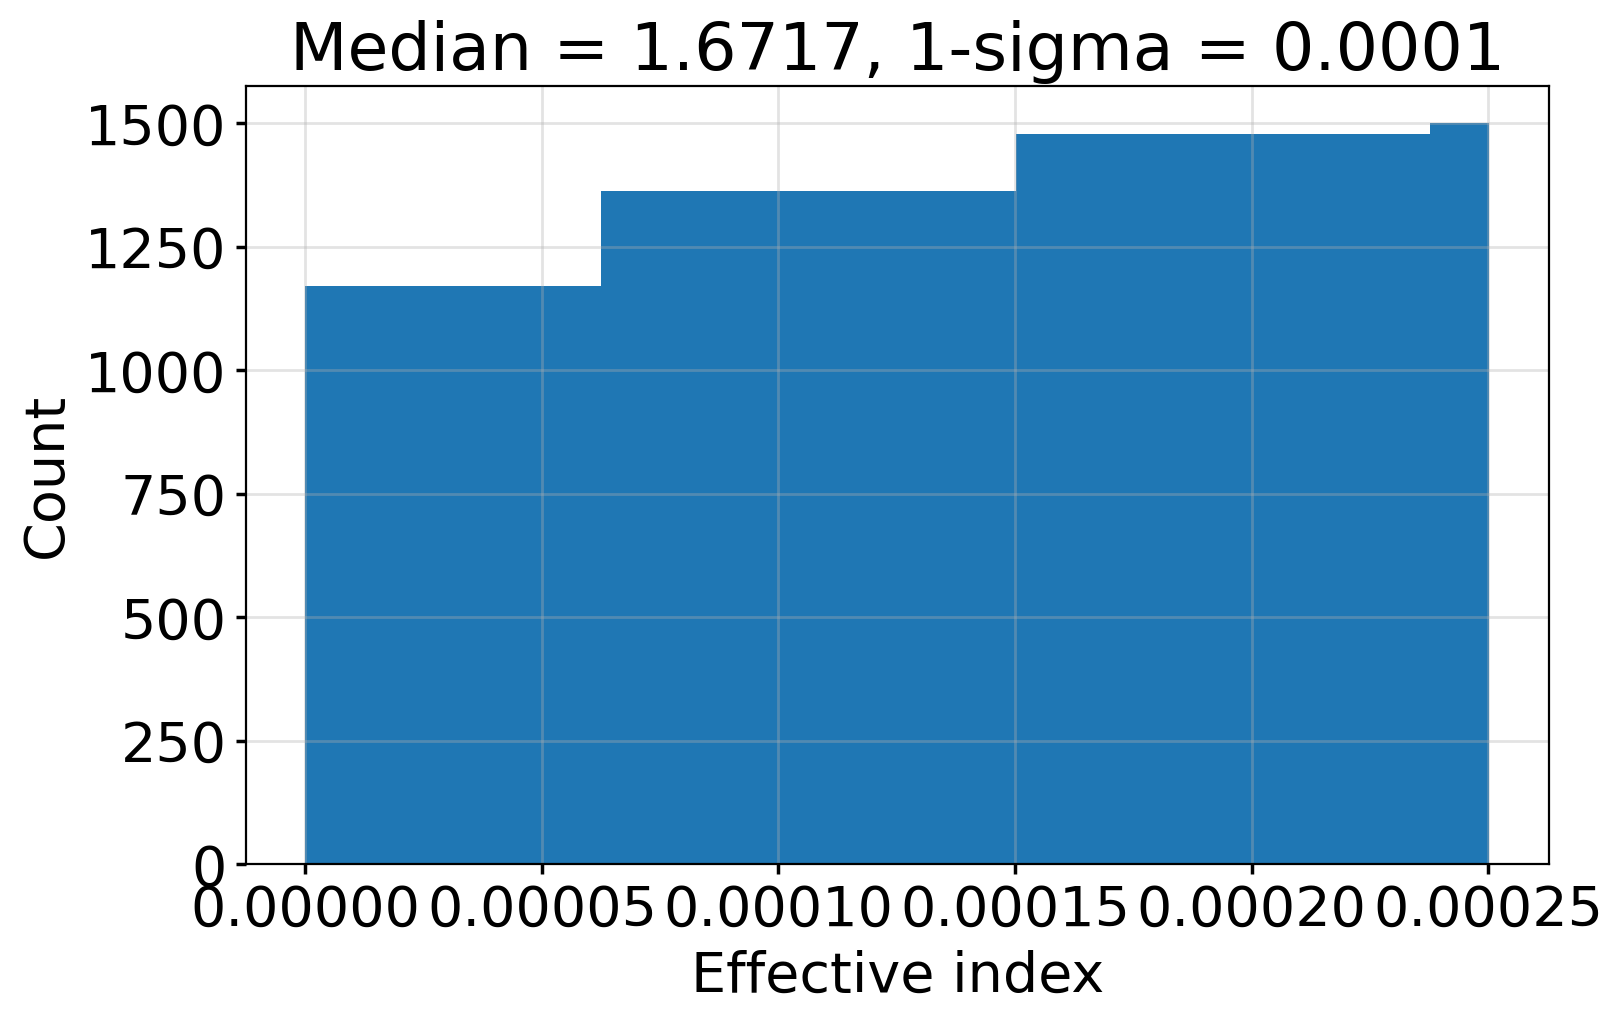

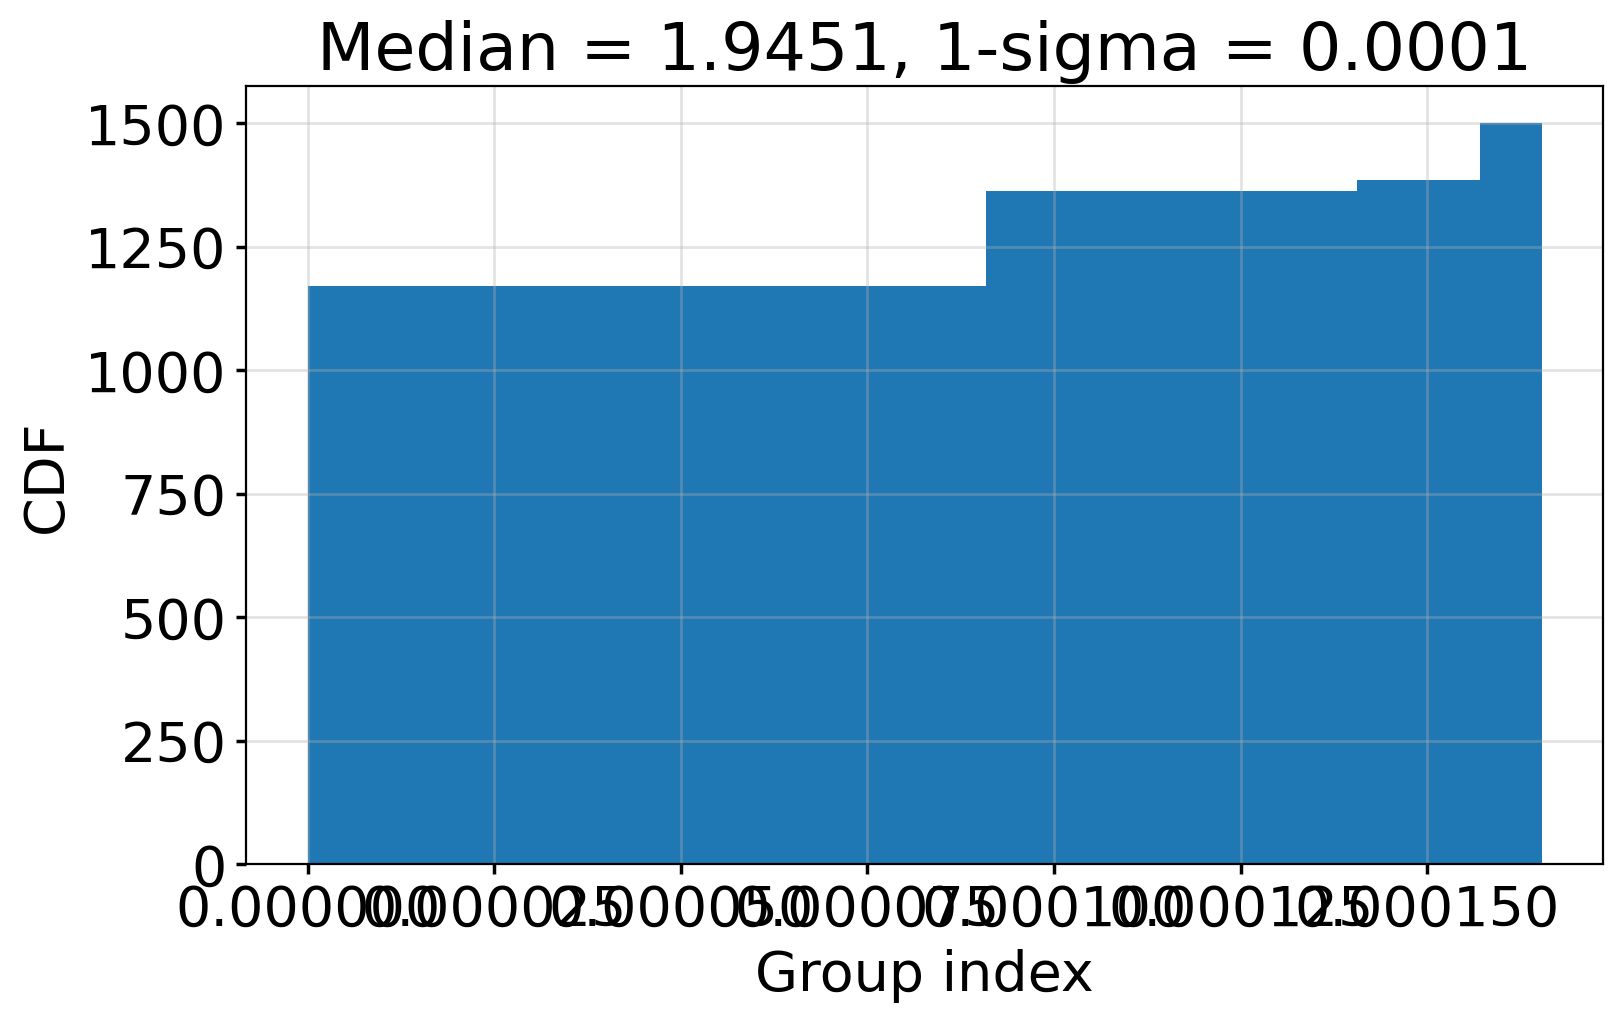

In [31]:
plt.figure()
plt.hist(rand_wg_sidewall_angle_dataset["neff_freq0"], bins=20)
plt.grid(True)
plt.xlabel('Effective index')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_sidewall_angle_dataset["neff_freq0"]):0.4f}, 1-sigma = {np.std(rand_wg_sidewall_angle_dataset["neff_freq0"]):0.4f}')

plt.figure()
plt.hist(rand_wg_sidewall_angle_dataset["ng_freq0"], bins=20)
plt.grid(True)
plt.xlabel('Group index')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_sidewall_angle_dataset["ng_freq0"]):0.4f}, 1-sigma = {np.std(rand_wg_sidewall_angle_dataset["ng_freq0"]):0.4f}')

plt.figure()
plt.hist(np.abs(rand_wg_sidewall_angle_dataset["neff_freq0"]-np.median(rand_wg_sidewall_angle_dataset["neff_freq0"])), bins=20, cumulative = True)
plt.grid(True)
plt.xlabel('Effective index')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_sidewall_angle_dataset["neff_freq0"]):0.4f}, 1-sigma = {np.std(rand_wg_sidewall_angle_dataset["neff_freq0"]):0.4f}')

plt.figure()
plt.hist(np.abs(rand_wg_sidewall_angle_dataset["ng_freq0"]-np.median(rand_wg_sidewall_angle_dataset["ng_freq0"])), bins=20, cumulative = True)
plt.grid(True)
plt.xlabel('Group index')
plt.ylabel('CDF')
plt.title(
    f'Median = {np.median(rand_wg_sidewall_angle_dataset["ng_freq0"]):0.4f}, 1-sigma = {np.std(rand_wg_sidewall_angle_dataset["ng_freq0"]):0.4f}')



## Thickness variation only

In [32]:
wg_width_choice, wg_height_choice, wg_sidewall_angle_choice = [], [], []
ng_freq0_spread = []
ng_dfreq_spread = []
neff_freq0_spread = []
neff_dfreq_spread = []

for i in tqdm(range(num_samples), desc="mode_simulations"):
  # rand_wg_width_choice = wg_width_spread[permutation_choice_width[i]]
  rand_wg_width_choice = wg_width
  rand_wg_height_choice = wg_height_spread[permutation_choice_height[i]]
  # rand_wg_sidewall_angle_choice = wg_sidewall_angle_spread[permutation_choice_sidewall_angle[i]]
  # rand_wg_height_choice = wg_height
  rand_wg_sidewall_angle_choice = wg_sidewall_angle

  wg_width_choice.append(rand_wg_width_choice)
  wg_height_choice.append(rand_wg_height_choice)
  wg_sidewall_angle_choice.append(rand_wg_sidewall_angle_choice)

  mode_solver, mode_data_df = mode_data_calculator(
      rand_wg_width_choice, 
      rand_wg_height_choice, 
      rand_wg_sidewall_angle_choice, 
      wg_n, wg_k, freqs, freq0, 
      Lx=Lx, Ly=Ly, Lz=Lz, dl=dl,
      min_steps_per_wvl=min_steps_per_wvl
  )

  fundamental_mode_data_df = mode_data_df[mode_data_df["wavelength"] == 1.31]
  ng_freq0 = fundamental_mode_data_df["group index"].values[0]
  ng_dfreq = (mode_data_df["group index"].values[-1] -
              mode_data_df["group index"].values[0])/2
  neff_freq0 = fundamental_mode_data_df["n eff"].values[0]
  neff_dfreq = (mode_data_df["n eff"].values[-1] -
                mode_data_df["n eff"].values[0])/2
  
  ng_freq0_spread.append(ng_freq0)
  ng_dfreq_spread.append(ng_dfreq)
  neff_freq0_spread.append(neff_freq0)
  neff_dfreq_spread.append(neff_dfreq)

rand_wg_height_dataset = pd.DataFrame(data=wg_width_choice)
rand_wg_height_dataset.columns = ['wg_width (nm)']
rand_wg_height_dataset['wg_height (nm)']=wg_height_choice
rand_wg_height_dataset['wg_sidewall_angle (rad)'] = wg_sidewall_angle_choice
rand_wg_height_dataset['rand_wg_width'] = False
rand_wg_height_dataset['rand_wg_height'] = True
rand_wg_height_dataset['rand_wg_sidewall_angle'] = False
rand_wg_height_dataset['neff_freq0'] = neff_freq0_spread
rand_wg_height_dataset['neff_dfreq'] = neff_dfreq_spread
rand_wg_height_dataset['ng_freq0'] = ng_freq0_spread
rand_wg_height_dataset['ng_dfreq'] = ng_dfreq_spread
rand_wg_height_dataset['freq0 (Hz)']=freq0
rand_wg_height_dataset['freq_lo (Hz)'] = freqs[0]
rand_wg_height_dataset['freq_hi (Hz)'] = freqs[-1]


gf45clo_pdk_sin_neff_ng_variability = pd.concat([gf45clo_pdk_sin_neff_ng_variability, rand_wg_height_dataset])
gf45clo_pdk_sin_neff_ng_variability.to_csv("gf45clo_pdk_sin_neff_ng_variability.csv")

mode_simulations: 100%|███████████████████████████████████████████████████████████████████████████| 1500/1500 [1:23:02<00:00,  3.32s/it]


Text(0.5, 1.0, 'Median = 87.00 deg, 1-sigma = 0.00 deg')

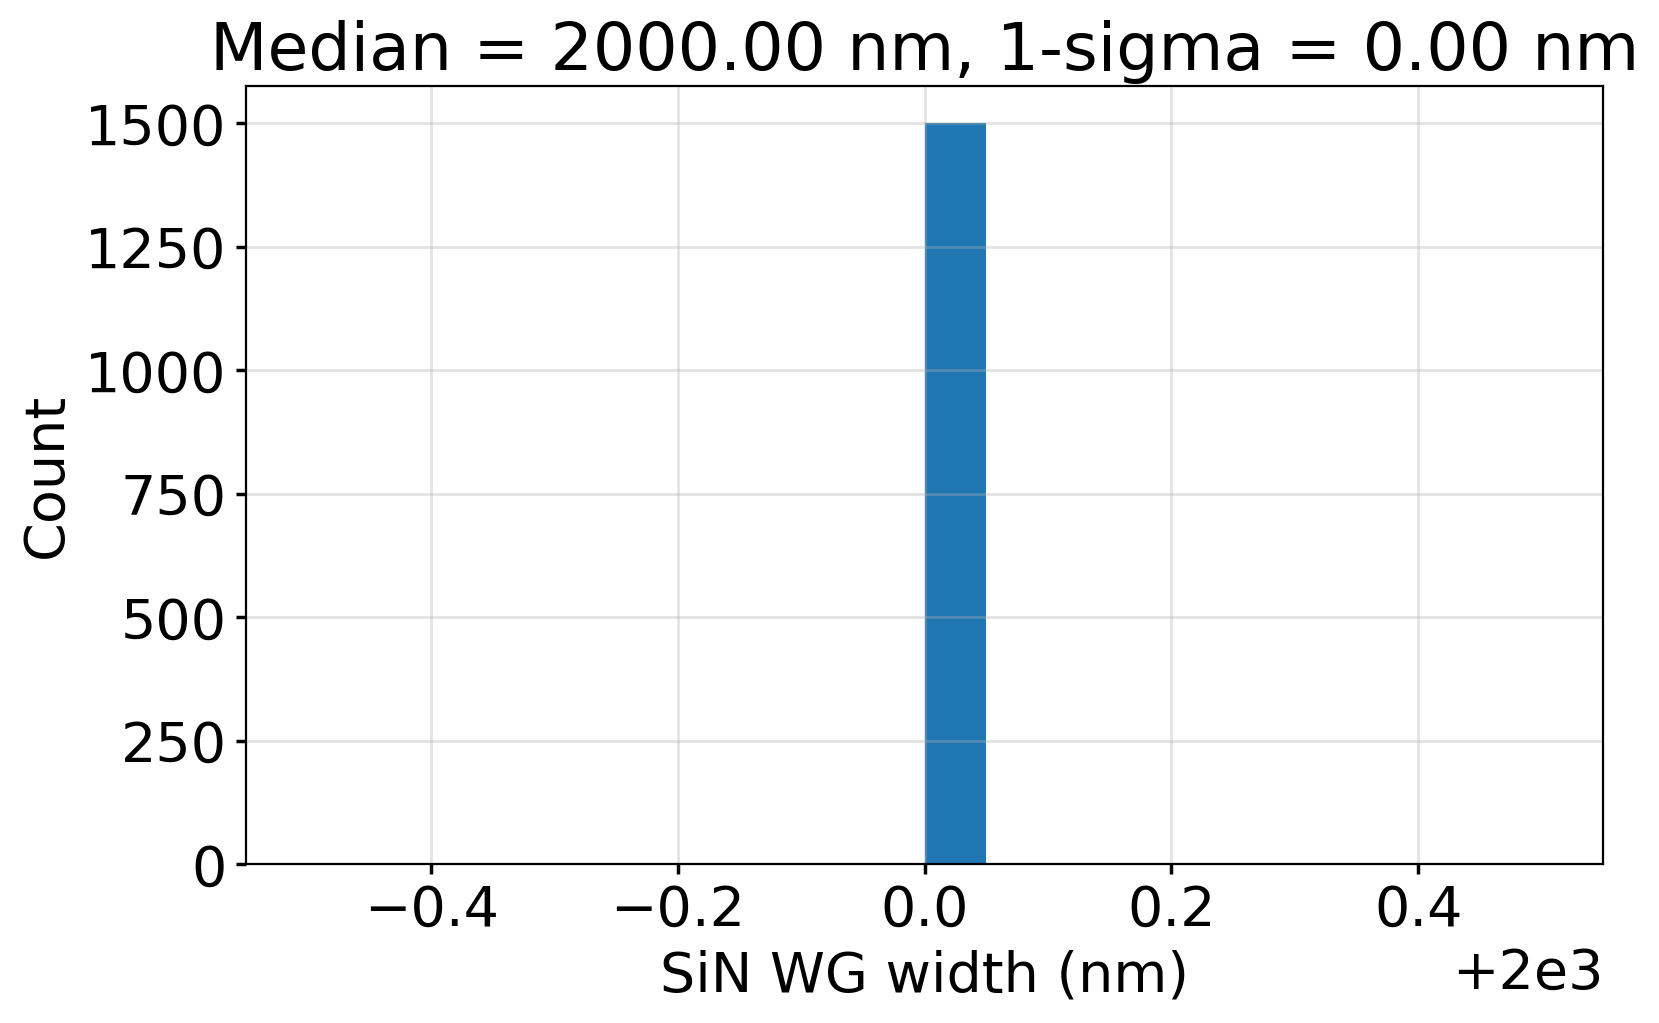

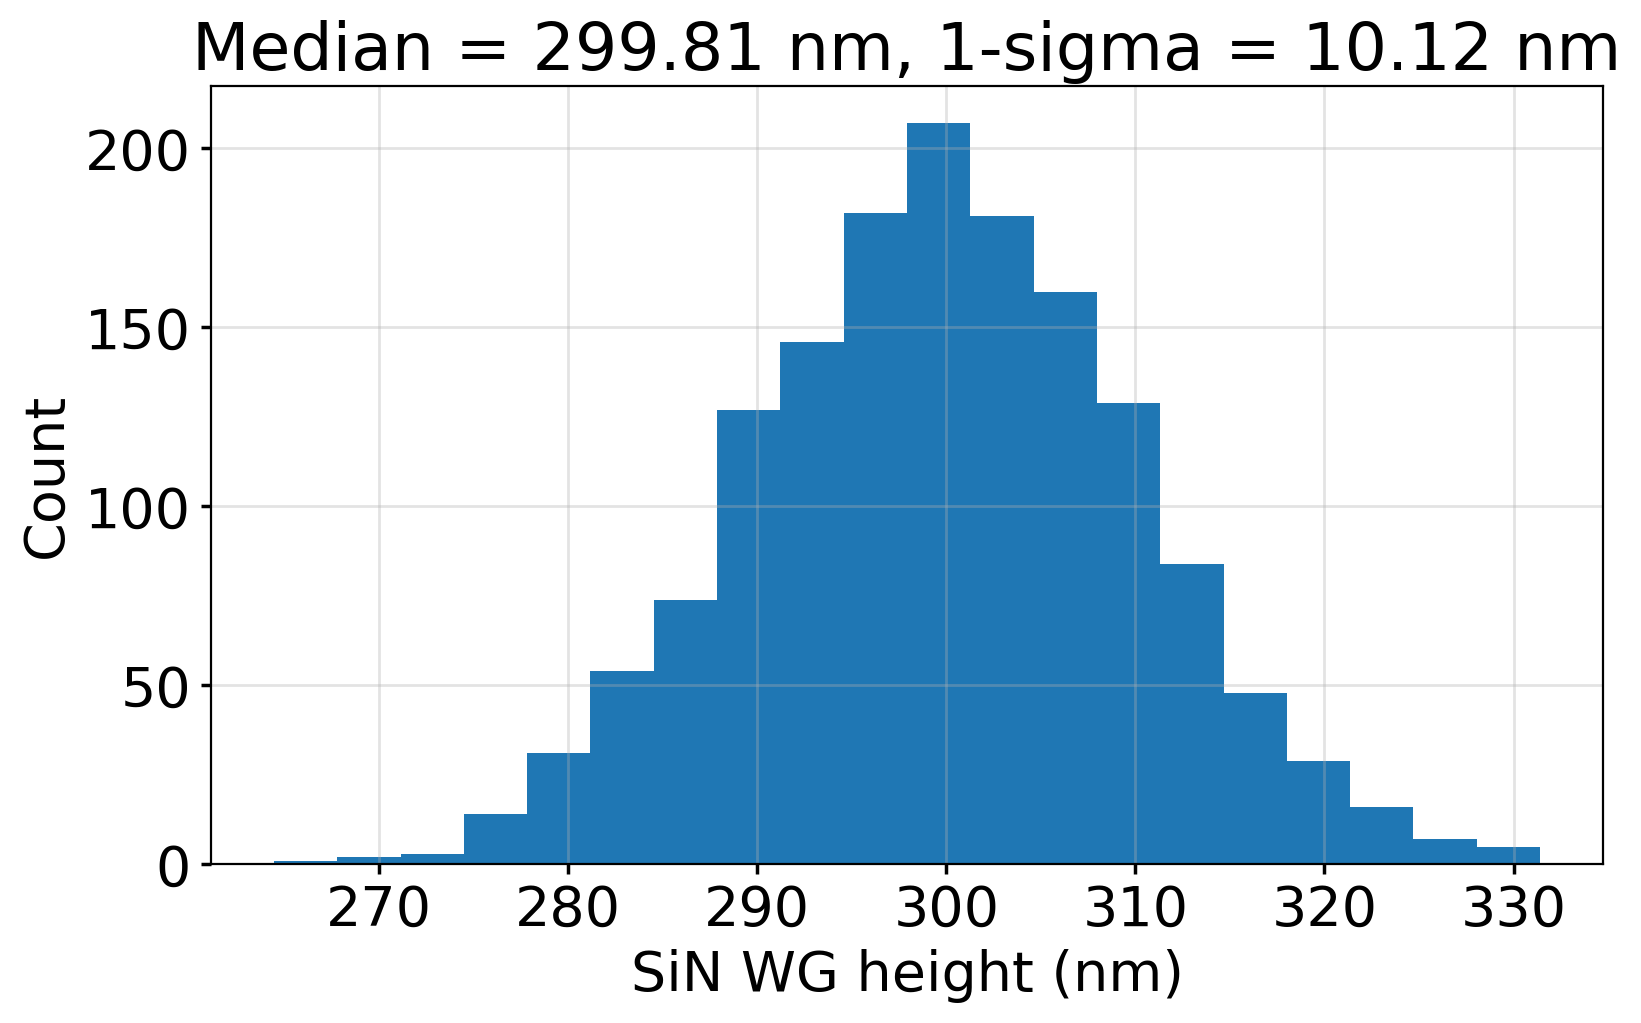

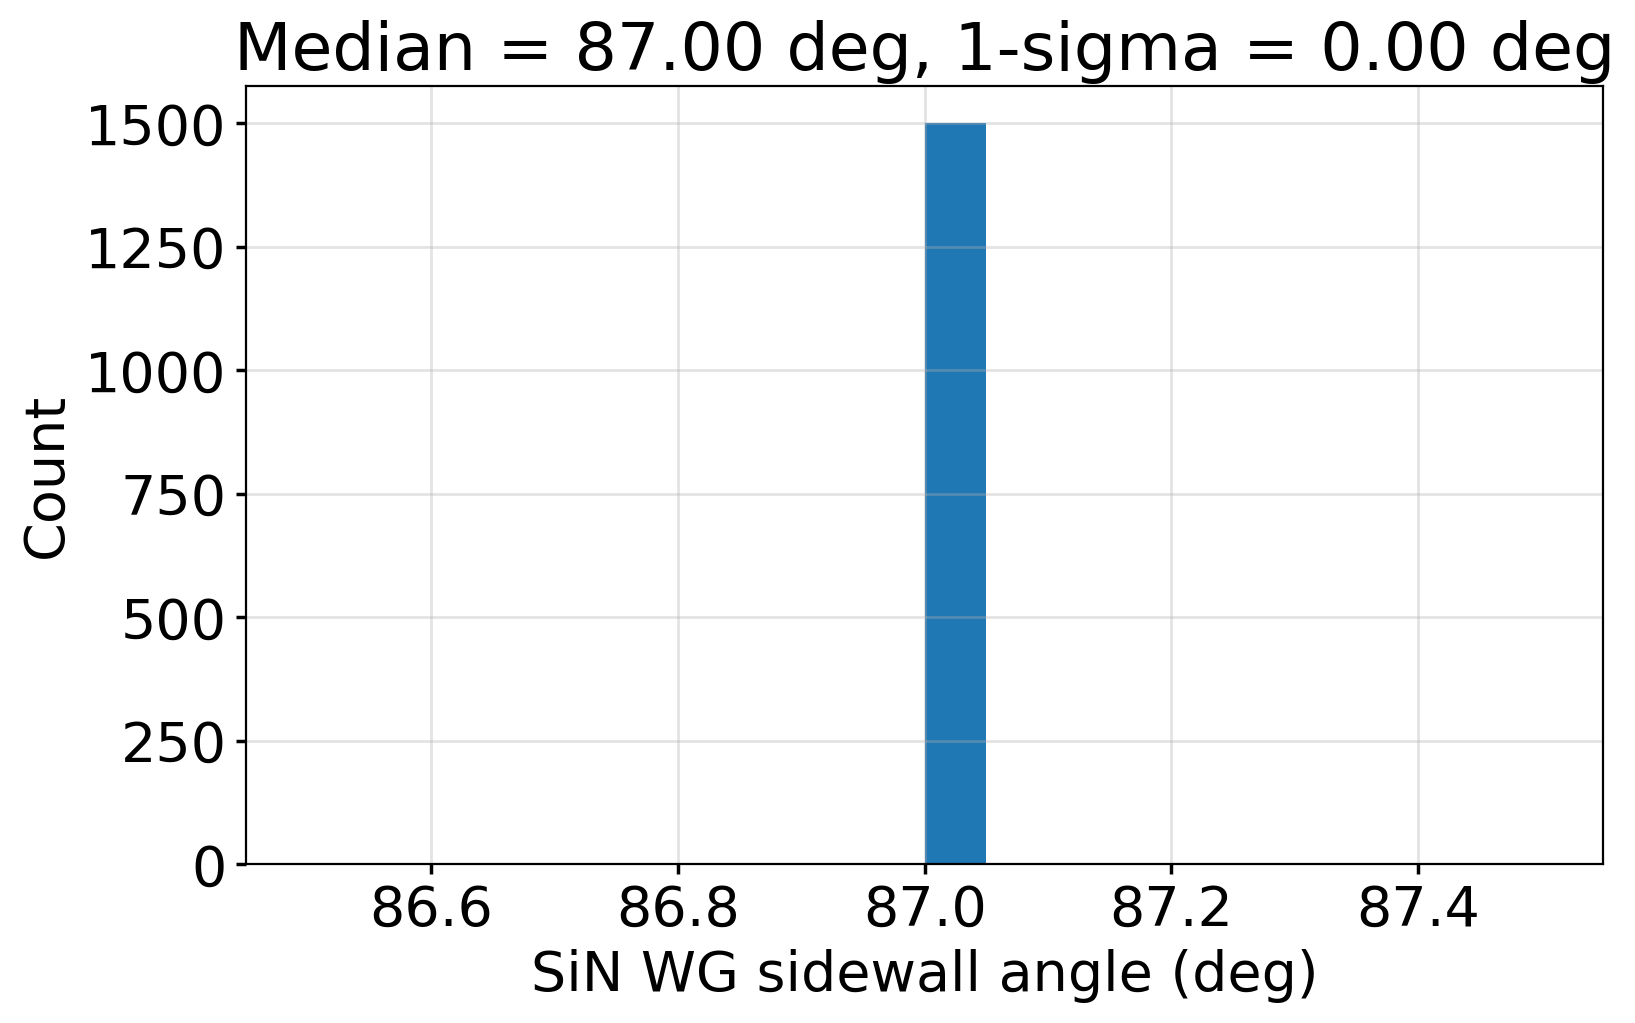

In [33]:
plt.figure()
plt.hist(rand_wg_height_dataset["wg_width (nm)"]*1000, bins=20)
plt.grid(True)
plt.xlabel('SiN WG width (nm)')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_height_dataset["wg_width (nm)"]*1000):0.2f} nm, 1-sigma = {np.std(rand_wg_height_dataset["wg_width (nm)"]*1000):0.2f} nm')

plt.figure()
plt.hist(rand_wg_height_dataset["wg_height (nm)"]*1000, bins=20)
plt.grid(True)
plt.xlabel('SiN WG height (nm)')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_height_dataset["wg_height (nm)"]*1000):0.2f} nm, 1-sigma = {np.std(rand_wg_height_dataset["wg_height (nm)"]*1000):0.2f} nm')

plt.figure()
plt.hist(
    90-rand_wg_height_dataset["wg_sidewall_angle (rad)"].values/np.pi*180, bins=20)
plt.grid(True)
plt.xlabel('SiN WG sidewall angle (deg)')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(90-rand_wg_height_dataset["wg_sidewall_angle (rad)"].values/np.pi*180):0.2f} deg, 1-sigma = {np.std(90-rand_wg_height_dataset["wg_sidewall_angle (rad)"].values/np.pi*180):0.2f} deg')


Text(0.5, 1.0, 'Median = 1.9454, 1-sigma = 0.0123')

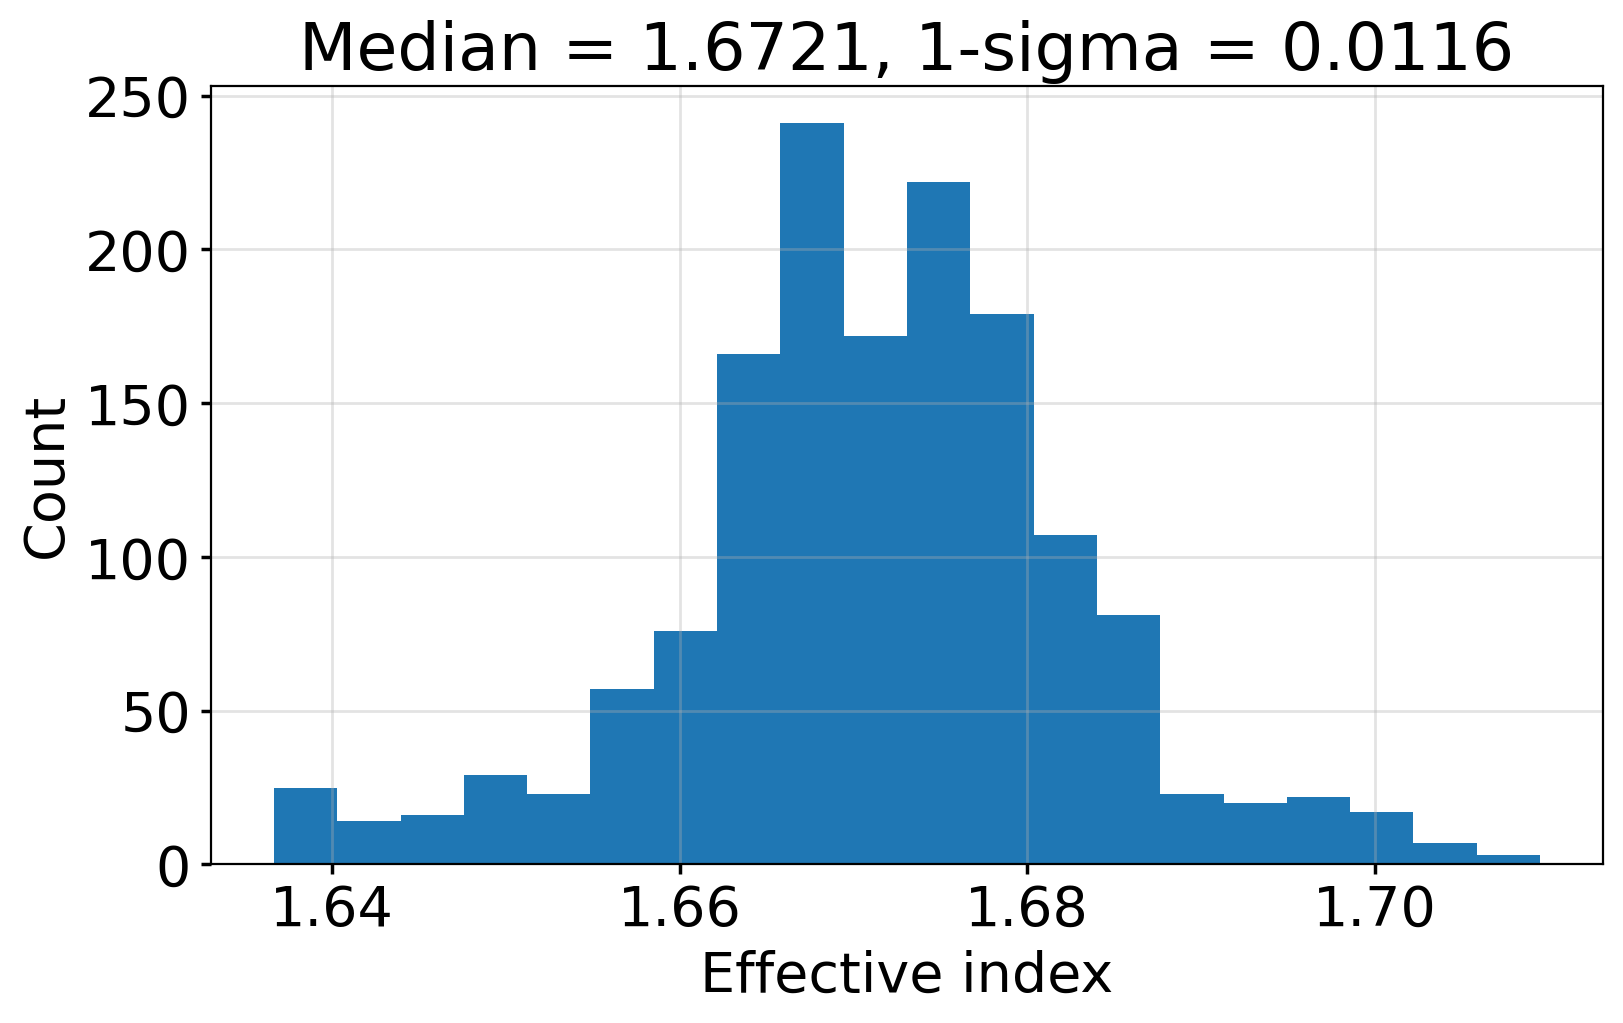

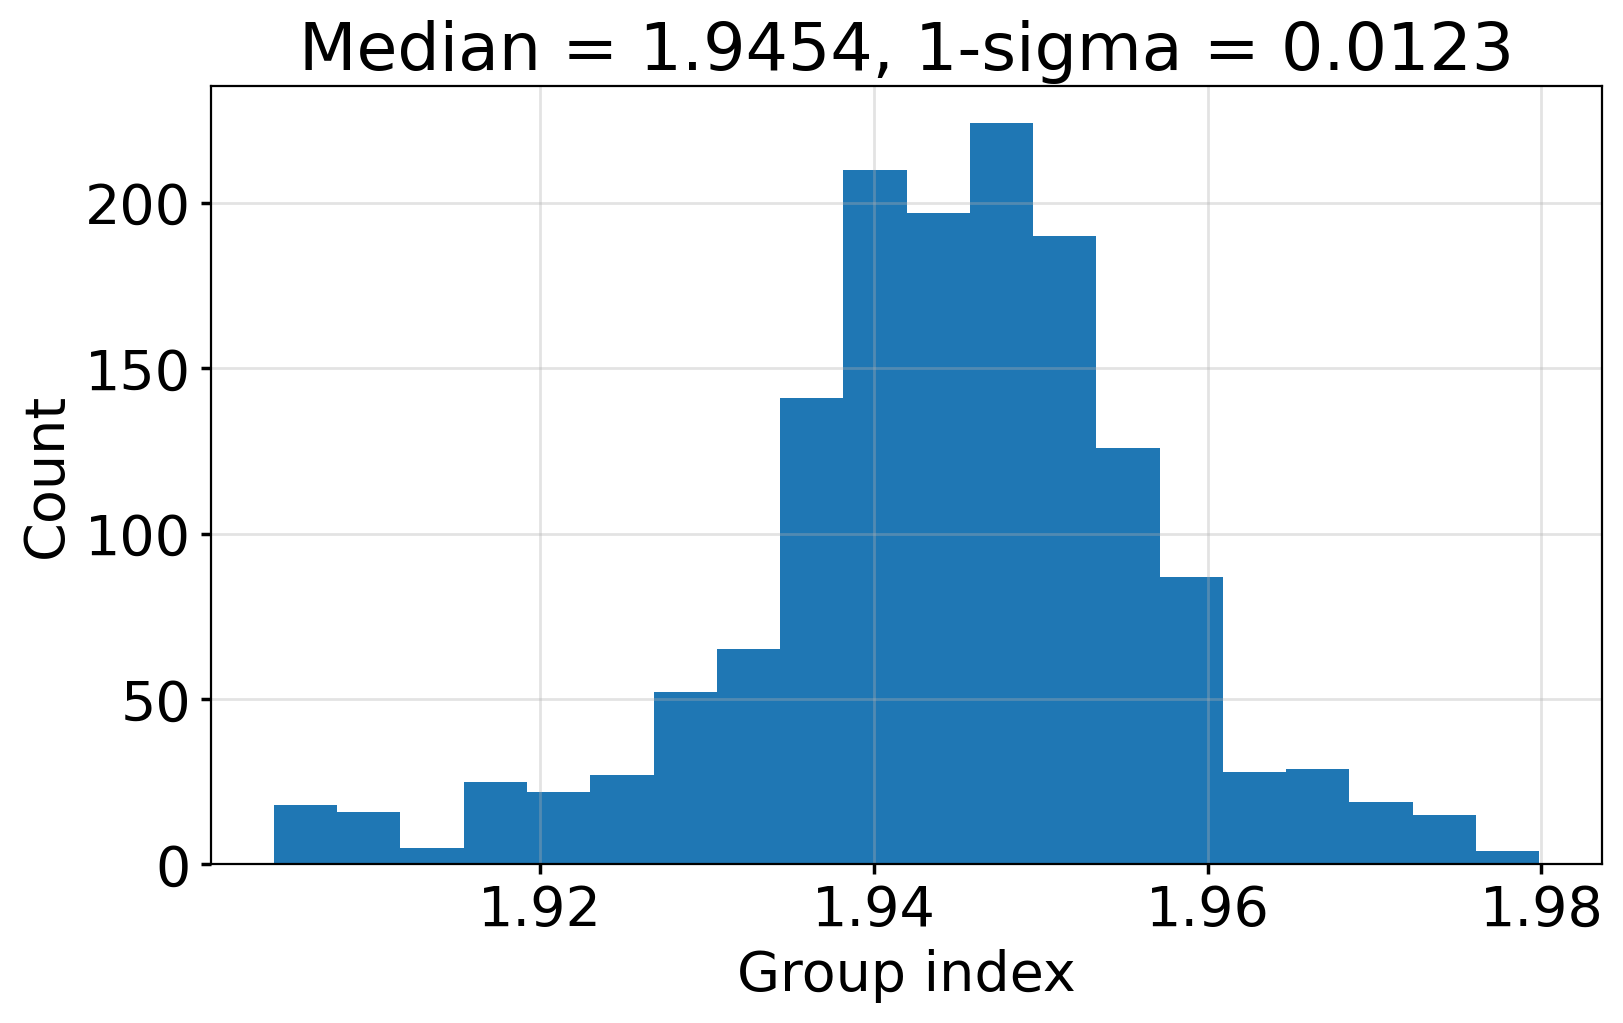

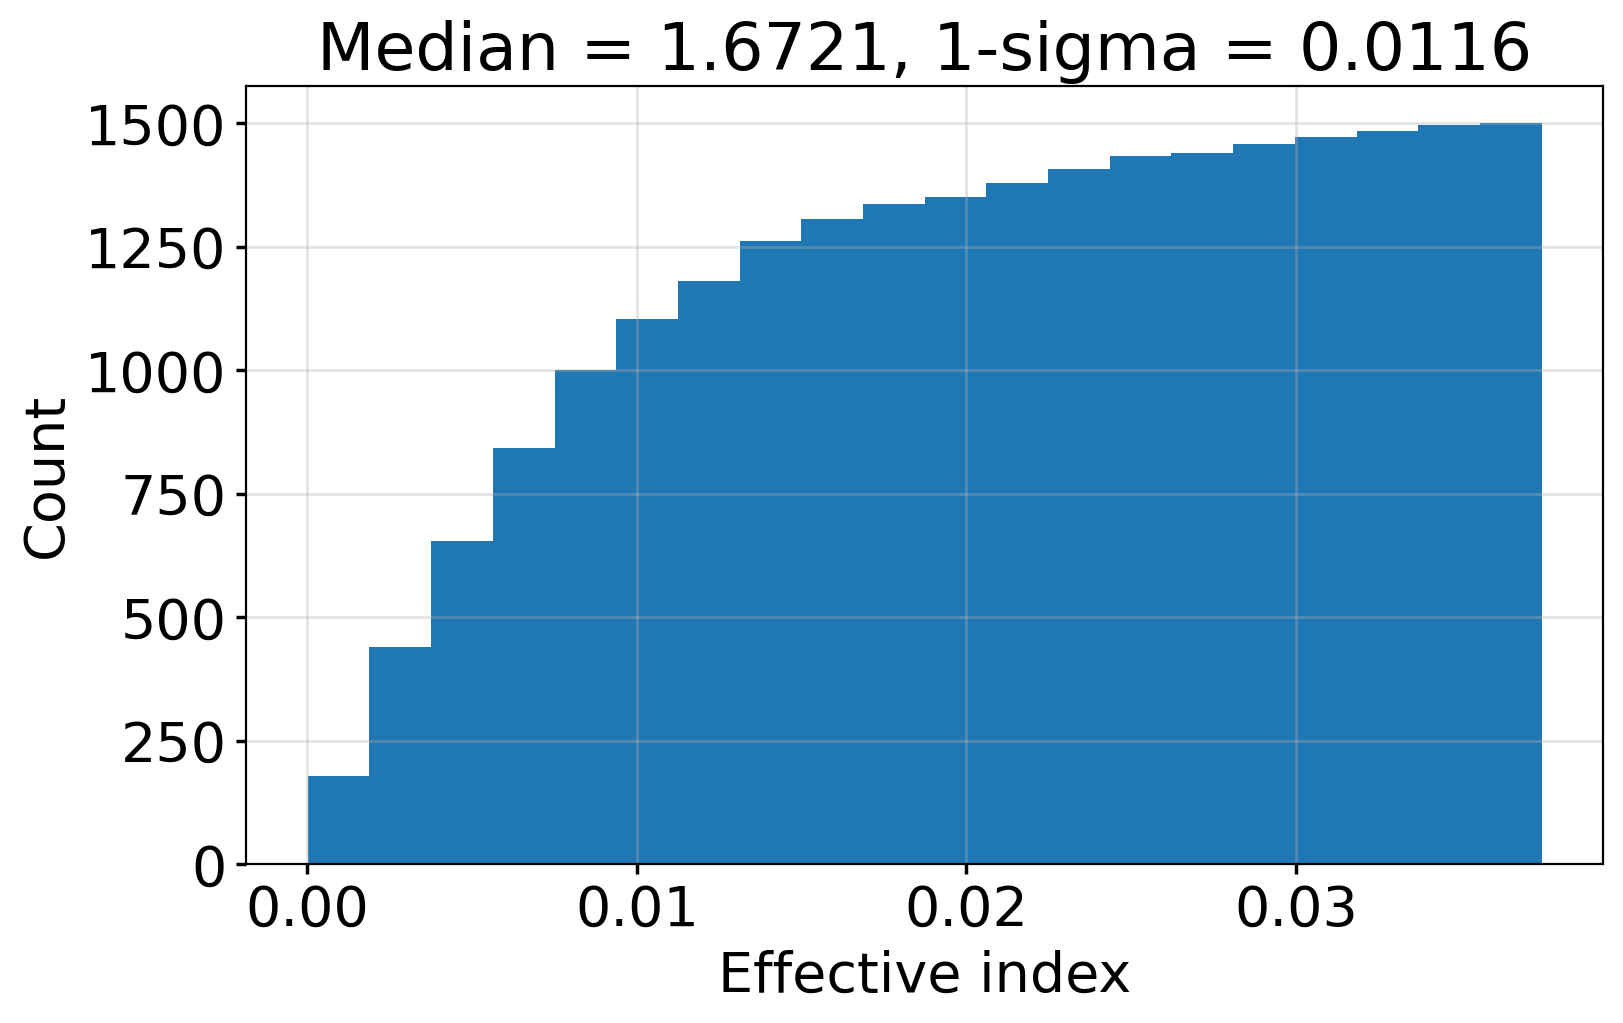

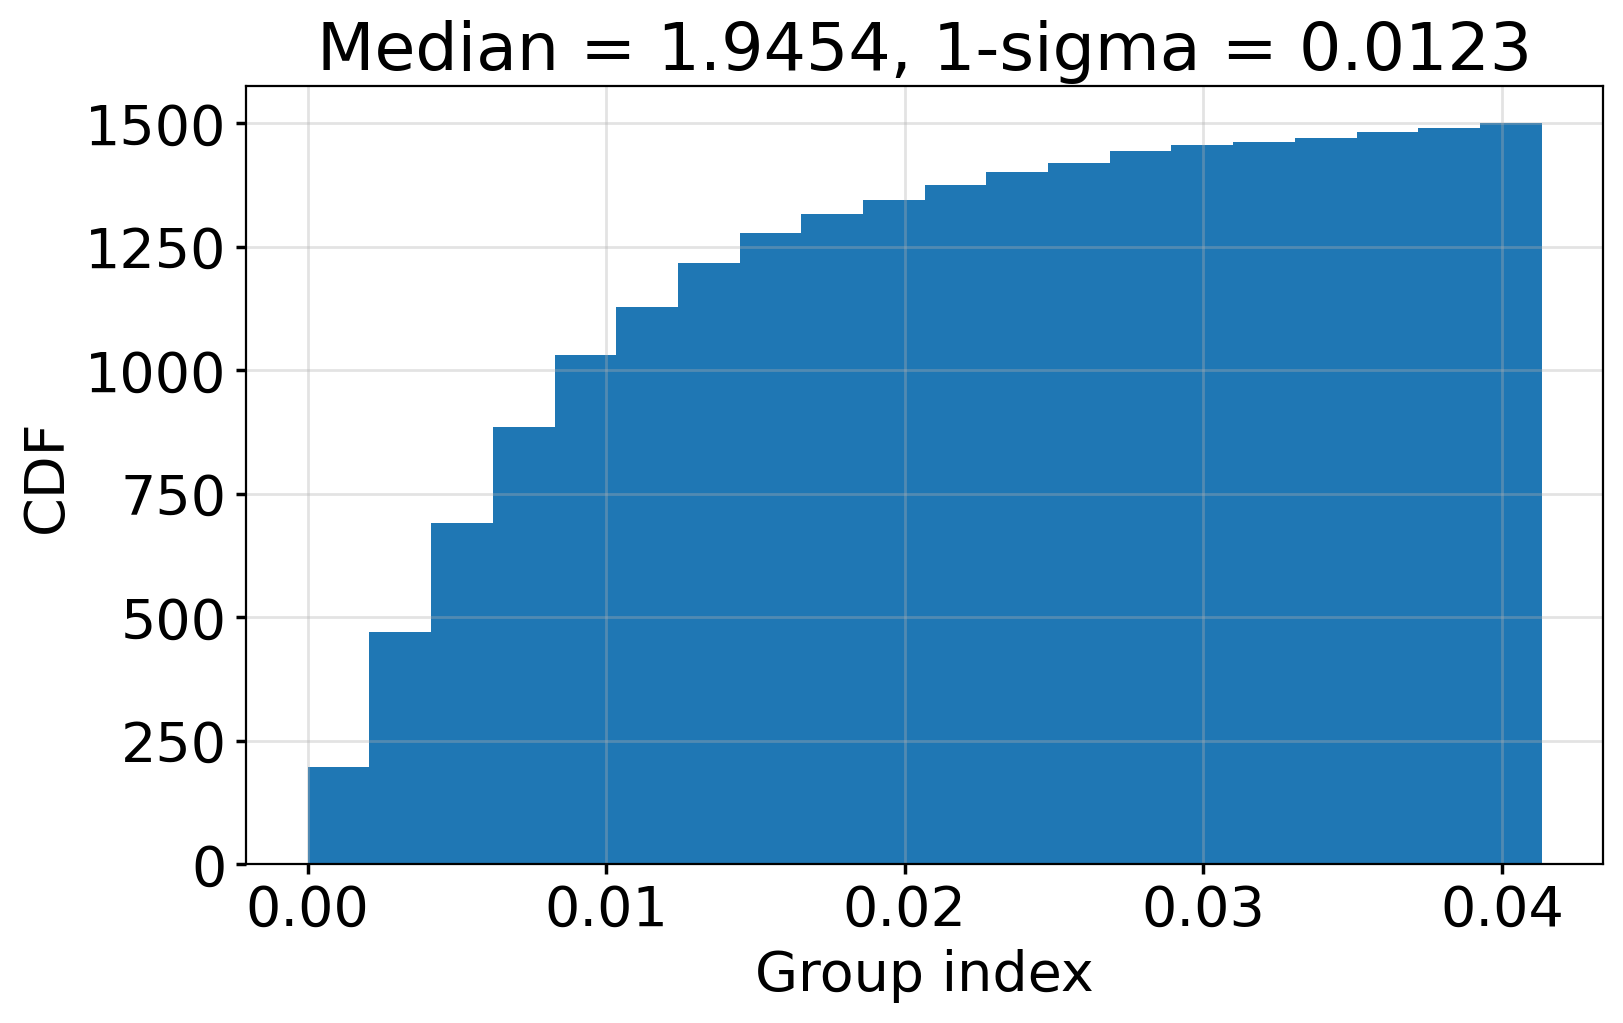

In [34]:
plt.figure()
plt.hist(rand_wg_height_dataset["neff_freq0"], bins=20)
plt.grid(True)
plt.xlabel('Effective index')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_height_dataset["neff_freq0"]):0.4f}, 1-sigma = {np.std(rand_wg_height_dataset["neff_freq0"]):0.4f}')

plt.figure()
plt.hist(rand_wg_height_dataset["ng_freq0"], bins=20)
plt.grid(True)
plt.xlabel('Group index')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_height_dataset["ng_freq0"]):0.4f}, 1-sigma = {np.std(rand_wg_height_dataset["ng_freq0"]):0.4f}')

plt.figure()
plt.hist(np.abs(rand_wg_height_dataset["neff_freq0"]-np.median(rand_wg_height_dataset["neff_freq0"])), bins=20, cumulative = True)
plt.grid(True)
plt.xlabel('Effective index')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_wg_height_dataset["neff_freq0"]):0.4f}, 1-sigma = {np.std(rand_wg_height_dataset["neff_freq0"]):0.4f}')

plt.figure()
plt.hist(np.abs(rand_wg_height_dataset["ng_freq0"]-np.median(rand_wg_height_dataset["ng_freq0"])), bins=20, cumulative = True)
plt.grid(True)
plt.xlabel('Group index')
plt.ylabel('CDF')
plt.title(
    f'Median = {np.median(rand_wg_height_dataset["ng_freq0"]):0.4f}, 1-sigma = {np.std(rand_wg_height_dataset["ng_freq0"]):0.4f}')



## Full Monte Carlo

In [35]:
wg_width_choice, wg_height_choice, wg_sidewall_angle_choice = [], [], []
ng_freq0_spread = []
ng_dfreq_spread = []
neff_freq0_spread = []
neff_dfreq_spread = []

for i in tqdm(range(num_samples), desc="mode_simulations"):
  rand_wg_width_choice = wg_width_spread[permutation_choice_width[i]]
  rand_wg_height_choice = wg_height_spread[permutation_choice_height[i]]
  rand_wg_sidewall_angle_choice = wg_sidewall_angle_spread[permutation_choice_sidewall_angle[i]]

  wg_width_choice.append(rand_wg_width_choice)
  wg_height_choice.append(rand_wg_height_choice)
  wg_sidewall_angle_choice.append(rand_wg_sidewall_angle_choice)

  mode_solver, mode_data_df = mode_data_calculator(
      rand_wg_width_choice, 
      rand_wg_height_choice, 
      rand_wg_sidewall_angle_choice, 
      wg_n, wg_k, freqs, freq0, 
      Lx=Lx, Ly=Ly, Lz=Lz, dl=dl,
      min_steps_per_wvl=min_steps_per_wvl
  )

  fundamental_mode_data_df = mode_data_df[mode_data_df["wavelength"] == 1.31]
  ng_freq0 = fundamental_mode_data_df["group index"].values[0]
  ng_dfreq = (mode_data_df["group index"].values[-1] -
              mode_data_df["group index"].values[0])/2
  neff_freq0 = fundamental_mode_data_df["n eff"].values[0]
  neff_dfreq = (mode_data_df["n eff"].values[-1] -
                mode_data_df["n eff"].values[0])/2
  
  ng_freq0_spread.append(ng_freq0)
  ng_dfreq_spread.append(ng_dfreq)
  neff_freq0_spread.append(neff_freq0)
  neff_dfreq_spread.append(neff_dfreq)

rand_dataset = pd.DataFrame(data=wg_width_choice)
rand_dataset.columns = ['wg_width (nm)']
rand_dataset['wg_height (nm)']=wg_height_choice
rand_dataset['wg_sidewall_angle (rad)'] = wg_sidewall_angle_choice
rand_dataset['rand_wg_width'] = True
rand_dataset['rand_wg_height'] = True
rand_dataset['rand_wg_sidewall_angle'] = True
rand_dataset['neff_freq0'] = neff_freq0_spread
rand_dataset['neff_dfreq'] = neff_dfreq_spread
rand_dataset['ng_freq0'] = ng_freq0_spread
rand_dataset['ng_dfreq'] = ng_dfreq_spread
rand_dataset['freq0 (Hz)']=freq0
rand_dataset['freq_lo (Hz)'] = freqs[0]
rand_dataset['freq_hi (Hz)'] = freqs[-1]


gf45clo_pdk_sin_neff_ng_variability = pd.concat([gf45clo_pdk_sin_neff_ng_variability, rand_dataset])
gf45clo_pdk_sin_neff_ng_variability.to_csv("gf45clo_pdk_sin_neff_ng_variability.csv")

mode_simulations: 100%|███████████████████████████████████████████████████████████████████████████| 1500/1500 [1:19:00<00:00,  3.16s/it]


Text(0.5, 1.0, 'Median = 87.03 deg, 1-sigma = 0.69 deg')

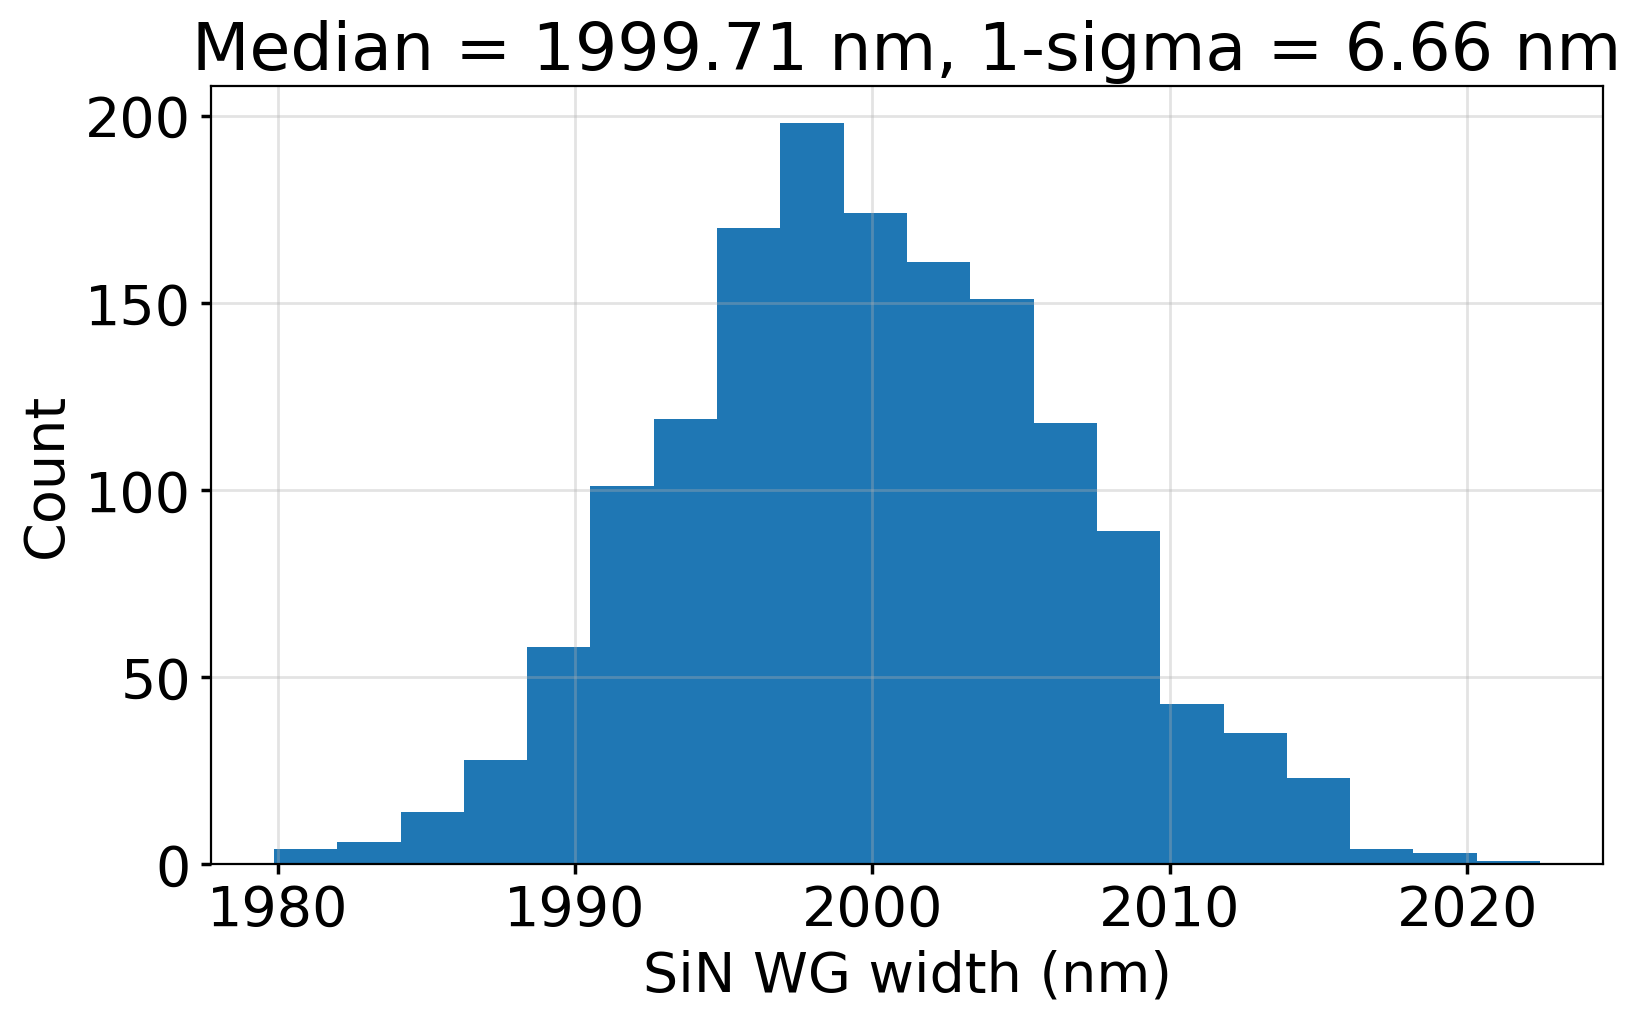

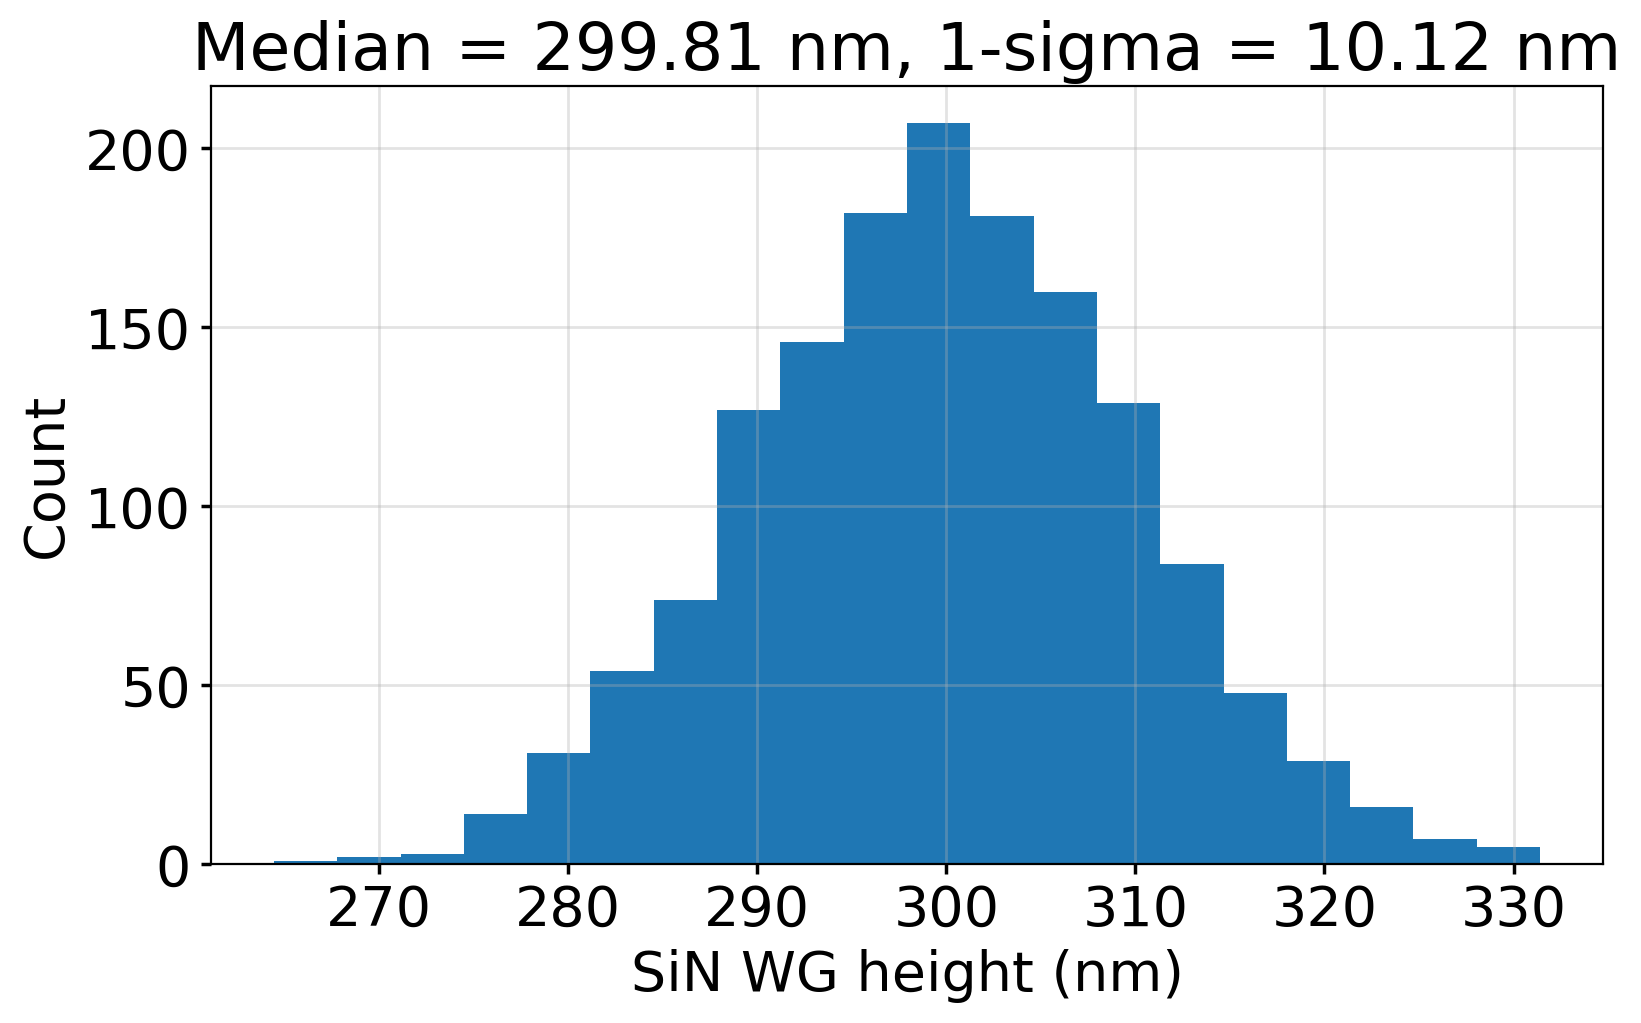

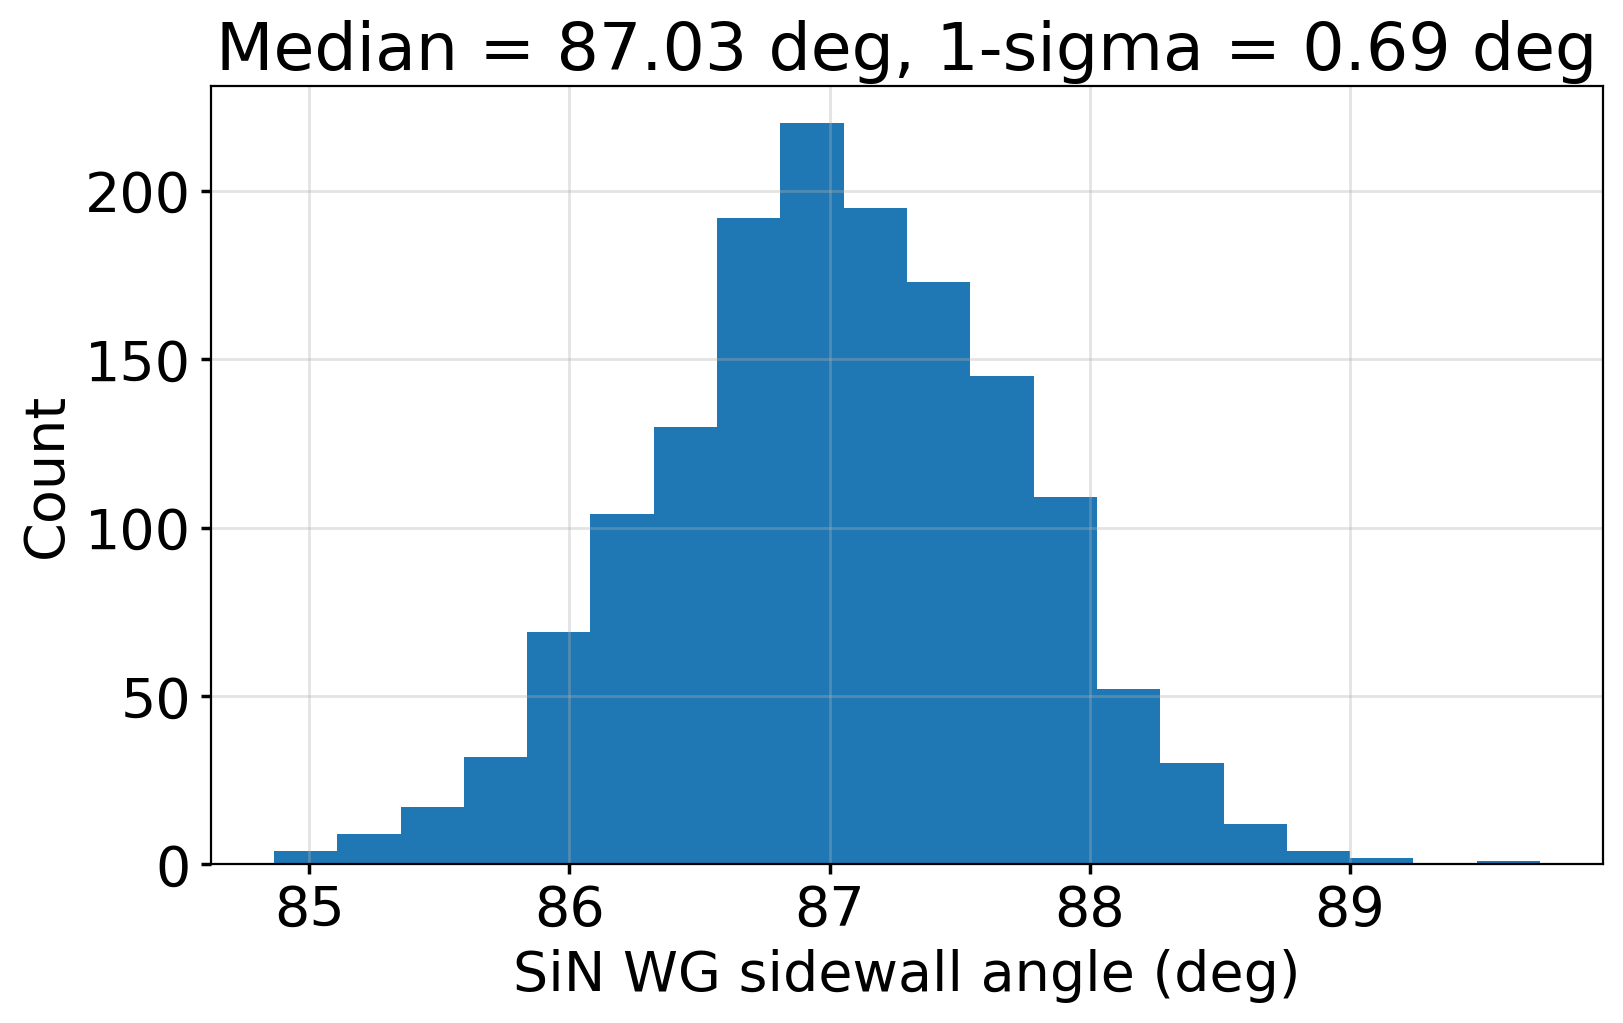

In [36]:
plt.figure()
plt.hist(rand_dataset["wg_width (nm)"]*1000, bins=20)
plt.grid(True)
plt.xlabel('SiN WG width (nm)')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_dataset["wg_width (nm)"]*1000):0.2f} nm, 1-sigma = {np.std(rand_dataset["wg_width (nm)"]*1000):0.2f} nm')

plt.figure()
plt.hist(rand_dataset["wg_height (nm)"]*1000, bins=20)
plt.grid(True)
plt.xlabel('SiN WG height (nm)')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_dataset["wg_height (nm)"]*1000):0.2f} nm, 1-sigma = {np.std(rand_dataset["wg_height (nm)"]*1000):0.2f} nm')

plt.figure()
plt.hist(
    90-rand_dataset["wg_sidewall_angle (rad)"].values/np.pi*180, bins=20)
plt.grid(True)
plt.xlabel('SiN WG sidewall angle (deg)')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(90-rand_dataset["wg_sidewall_angle (rad)"].values/np.pi*180):0.2f} deg, 1-sigma = {np.std(90-rand_dataset["wg_sidewall_angle (rad)"].values/np.pi*180):0.2f} deg')


Text(0.5, 1.0, 'Median = 1.9453, 1-sigma = 0.0123')

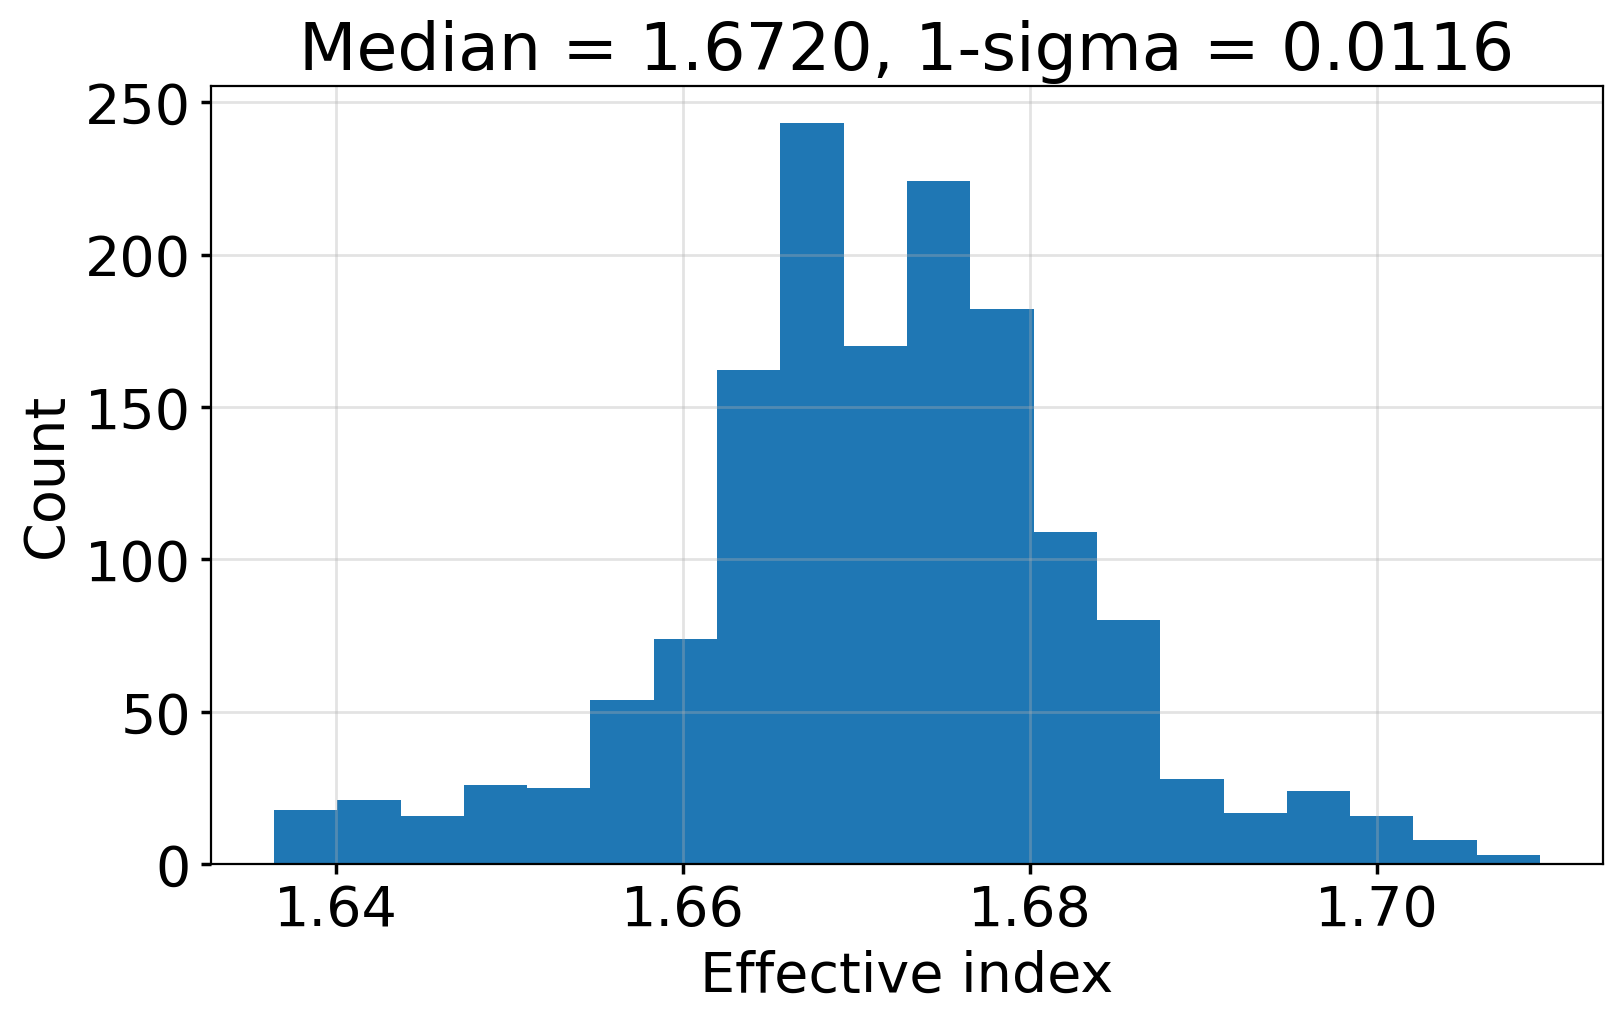

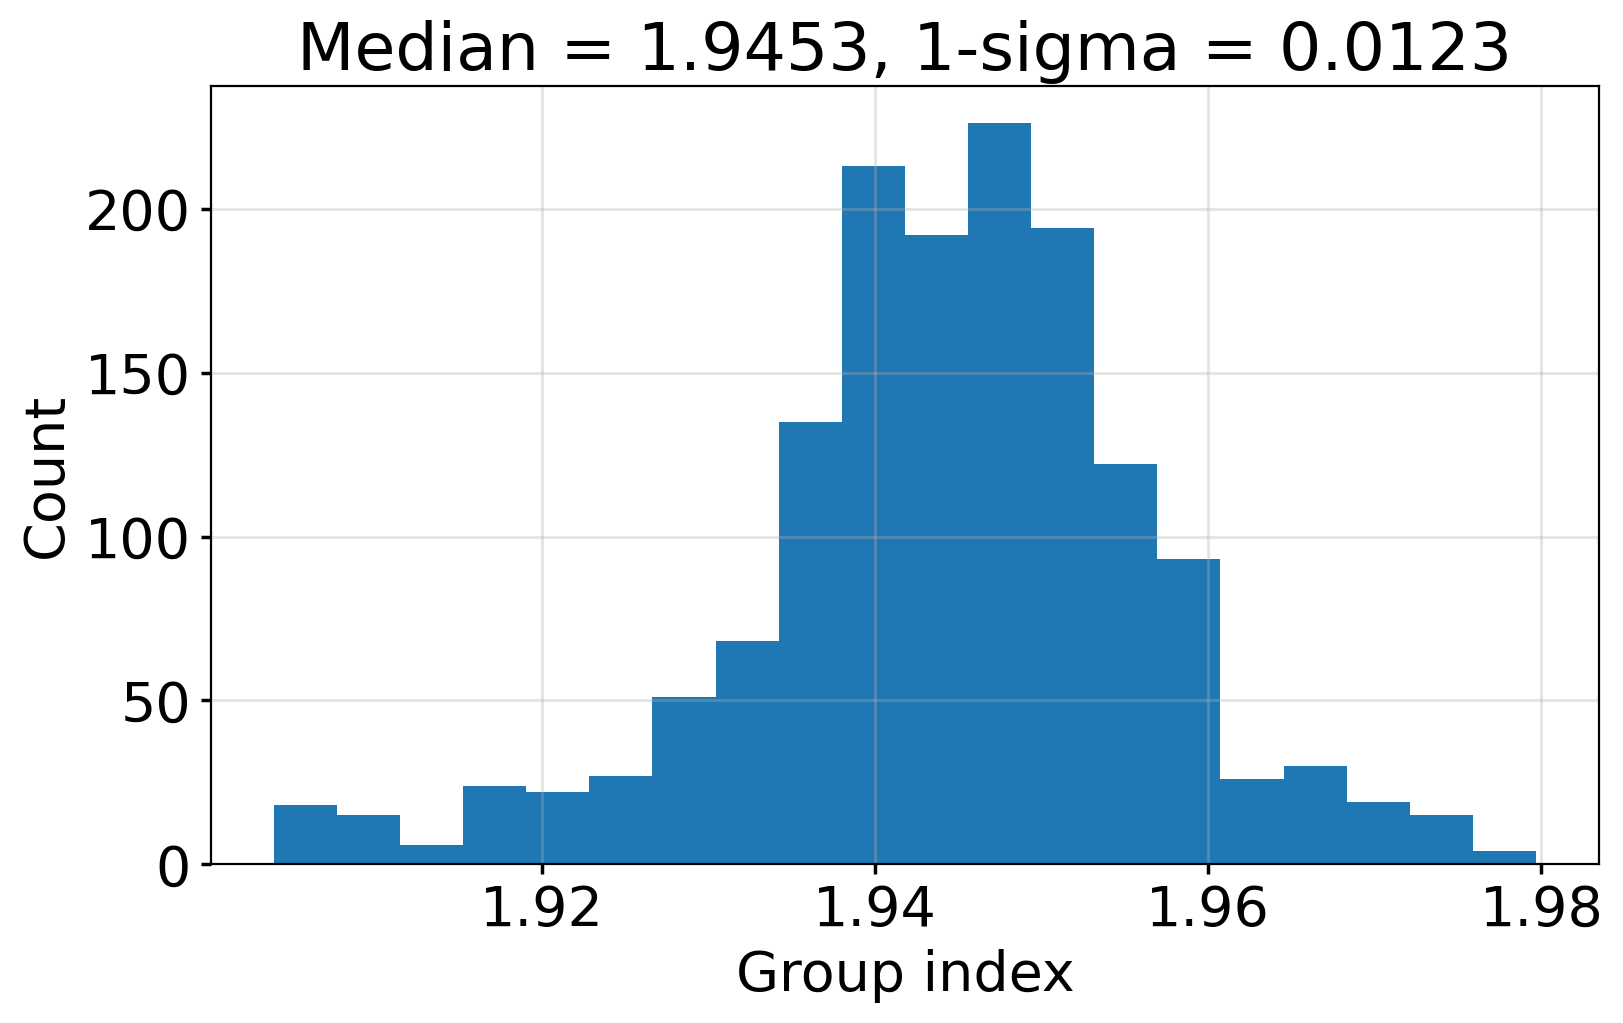

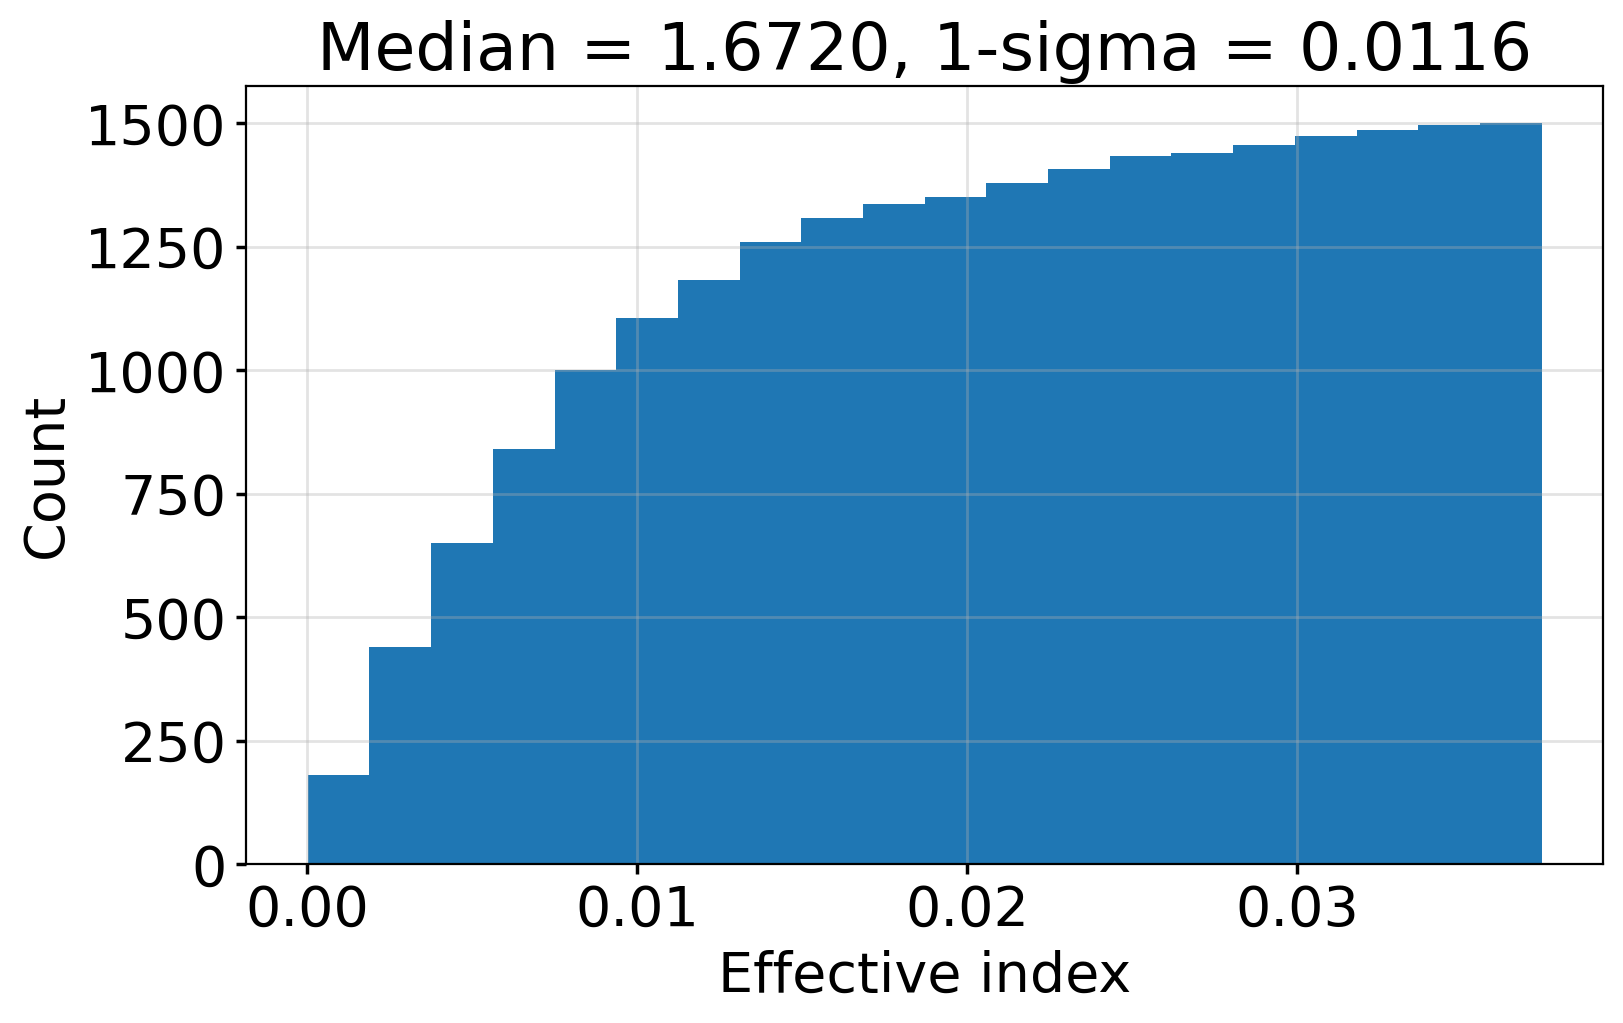

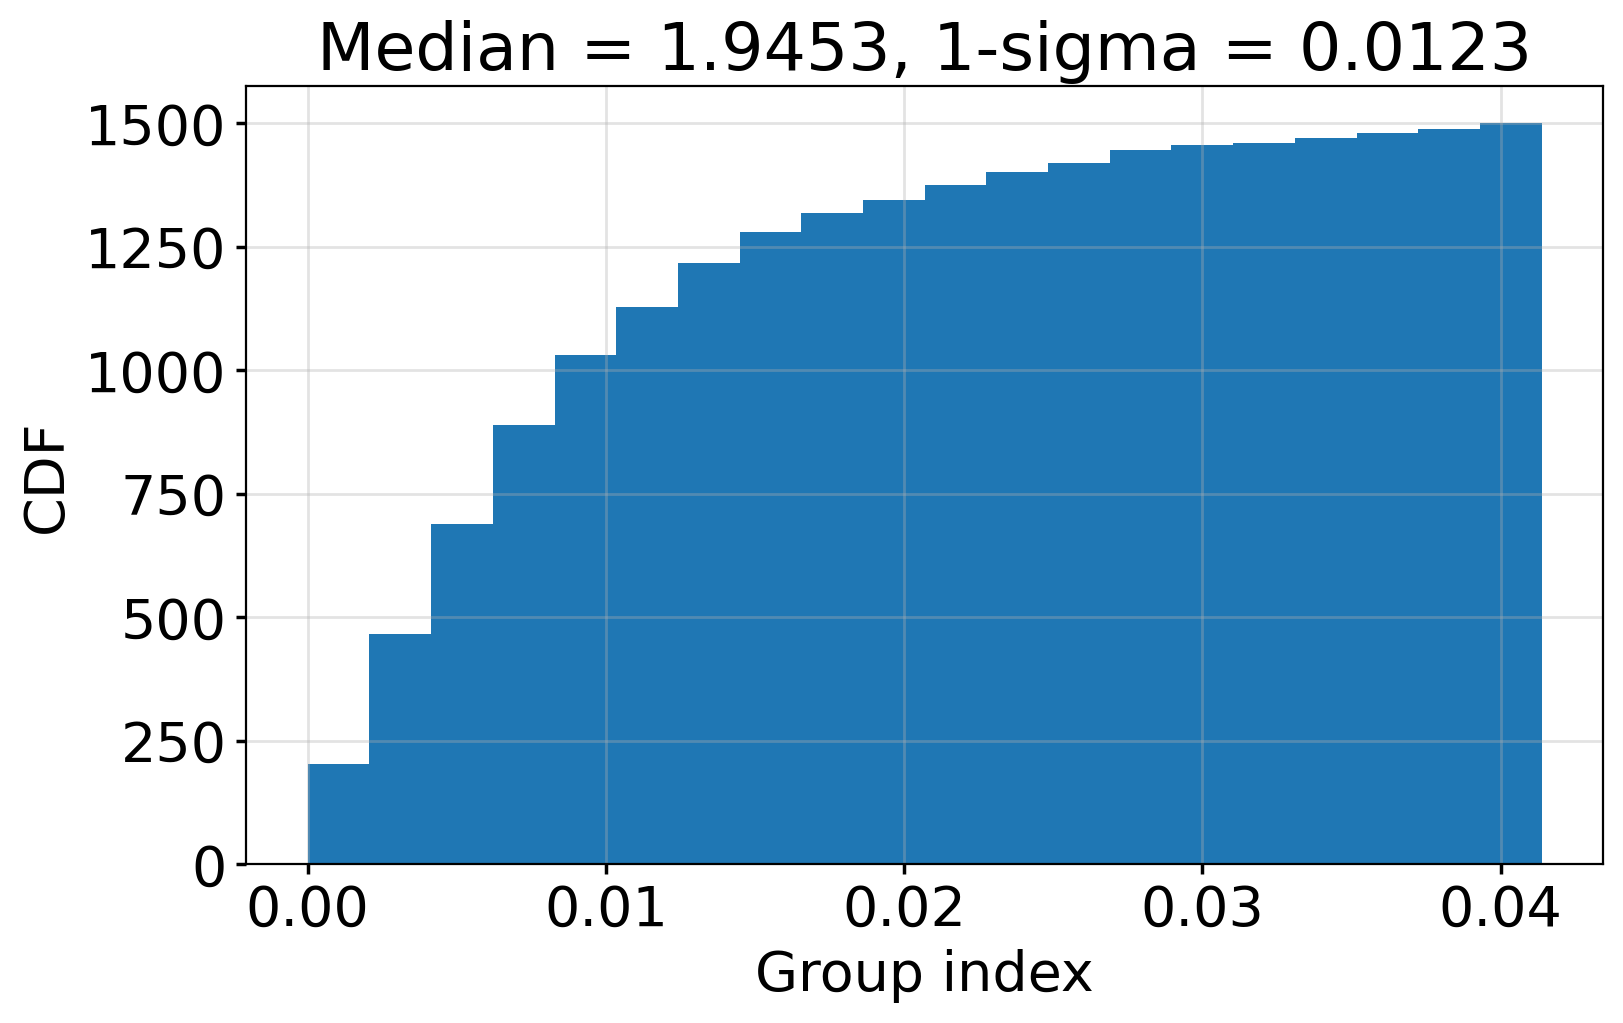

In [37]:
plt.figure()
plt.hist(rand_dataset["neff_freq0"], bins=20)
plt.grid(True)
plt.xlabel('Effective index')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_dataset["neff_freq0"]):0.4f}, 1-sigma = {np.std(rand_dataset["neff_freq0"]):0.4f}')

plt.figure()
plt.hist(rand_dataset["ng_freq0"], bins=20)
plt.grid(True)
plt.xlabel('Group index')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_dataset["ng_freq0"]):0.4f}, 1-sigma = {np.std(rand_dataset["ng_freq0"]):0.4f}')

plt.figure()
plt.hist(np.abs(rand_dataset["neff_freq0"]-np.median(rand_dataset["neff_freq0"])), bins=20, cumulative = True)
plt.grid(True)
plt.xlabel('Effective index')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(rand_dataset["neff_freq0"]):0.4f}, 1-sigma = {np.std(rand_dataset["neff_freq0"]):0.4f}')

plt.figure()
plt.hist(np.abs(rand_dataset["ng_freq0"]-np.median(rand_dataset["ng_freq0"])), bins=20, cumulative = True)
plt.grid(True)
plt.xlabel('Group index')
plt.ylabel('CDF')
plt.title(
    f'Median = {np.median(rand_dataset["ng_freq0"]):0.4f}, 1-sigma = {np.std(rand_dataset["ng_freq0"]):0.4f}')

